In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import os
import random

seed = 42

2023-01-15 00:45:39.346043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 00:45:39.552348: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-15 00:45:40.250635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-15 00:45:40.250726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

In [3]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
            
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test 
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [4]:
class RandomizedNetwork(keras.Model):
    
    def __init__(self, input_size, output_size, layers, init=None, reg=None):
        super().__init__()
        
        if init is None:
            init = initializers.RandomNormal(mean=0, stddev=1, seed=None)
        
        self.reg = reg
        
        self.model = Sequential()
                    
            
        units = layers[0]["units"]
        activation = layers[0]["activation"]
        self.model.add(Dense(units, input_dim=input_size, activation=activation,
                    kernel_initializer = init, bias_initializer = init))
        self.model.layers[0].trainable = False
        
        
        
        for layer in layers[1:]:
            activation = layer["activation"]
            units = layer["units"]
            self.model.add(Dense(units, activation=activation, 
                        kernel_initializer = init, bias_initializer = init))
            self.model.layers[-1].trainable = False
        
        self.model.add(Dense(output_size, activation="linear",
                    kernel_initializer = init, bias_initializer = init))
        
        
        self.compile(loss="mse", metrics = mee)
        
        
        
                
    def lms_solve(self, x, y):
        
        n = x.shape[0]
        
        # x_b = np.append(x, np.ones((n,1)), axis=-1)
        for layer in self.model.layers[:-1]:
            x = layer(x)
        
        H = x.numpy()
        H = np.append(H, np.ones((n,1)), axis=-1)
        # H = self.model.layers[0](x).numpy()
        
        # if regularization is used apply direct solution
        if self.reg is not None:
            H_t = H.transpose()
            H = np.matmul(H_t, H)
            I = np.identity(H.shape[0])
            H = H + self.reg*I
            H_star = np.linalg.inv(H)
            W = np.matmul(H_star, H_t)
            W = np.matmul(W, y)
        # if regularization is not used apply numpy LMS solver
        else:
            W, _, _, _ = np.linalg.lstsq(H.T.dot(H), H.T.dot(y))
            
        b = W[-1:][0]
        W = W[:-1]
        
        # print(W.shape)
        # print(b.shape)
        # print(self.model.layers[-1].get_weights()[0].shape)
        # print(self.model.layers[-1].get_weights()[1].shape)
        self.model.layers[-1].set_weights([W, b])

        
    def call(self, x):
        return self.model(x)
    
    def summary(self):
        self.model.summary()
        

In [5]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("initialization")
    keys.remove("trials_train")
    keys.remove("trials_test")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        
        configurations.append(dict_conf)
        
        
    return configurations


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

    

def get_model(config, input_size, output_size):
    
    init_method = config["initialization"]["type"]
    reg = config["regularization"]
        
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
        
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1
    
    layers = []
    for l in range(1, n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        layers.append({ 
            "activation": activation,
            "units": n_units
        })
        
    model = RandomizedNetwork(input_size, output_size, layers, init, reg)
        
    return model
    
    

def get_metrics(model, x_train, y_train, x_test=None, y_test=None):
    train_loss, train_metric  = model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_metric  = model.evaluate(x_test, y_test, verbose=0) if x_test is not None else [None, None]
    return train_loss, train_metric, test_loss, test_metric
    

def fit_model_k_fold(x_train, y_train, config, n_folds):
    

    train_metric = "mee"
    val_metric = "val_mee"

    trials = config["trials_train"]

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                
                model.lms_solve(x_train_fold, y_train_fold)
                
                trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold)

                trials_val_loss.append(trial_val_loss)
                trials_train_loss.append(trial_train_loss)
                trials_val_acc.append(trial_val_acc)
                trials_train_acc.append(trial_train_acc)

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    train_metric = "mee"
    val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
                
            model.lms_solve(x_train, y_train)

            trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train, y_train, x_val, y_val)

            trials_val_loss.append(trial_val_loss)
            trials_train_loss.append(trial_train_loss)
            trials_val_acc.append(trial_val_acc)
            trials_train_acc.append(trial_train_acc)
            
            pbar.update(1)
    
    # get the mean metrics among the trials
    # med_idx = median_index(trials_val_loss)
    # med_val_loss = trials_val_loss[med_idx]
    # med_train_loss = trials_train_loss[med_idx]
    # med_val_acc = trials_val_acc[med_idx]
    # med_train_acc = trials_train_acc[med_idx]
    
    med_val_loss = np.mean(trials_val_loss)
    med_train_loss = np.mean(trials_train_loss)
    med_val_acc = np.mean(trials_val_acc)
    med_train_acc = np.mean(trials_train_acc)
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Mean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    
def fit_final_model(x_train, y_train, config):

    train_metric = "mee"
    val_metric = "val_mee"
    train_loss = "mse"
    val_loss = "mse"

    trials = config["trials_test"]

            
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    models = []
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=None)

    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
                
            model.lms_solve(x_train, y_train)
            
            models.append(model)

            trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train, y_train, x_val, y_val)

            trials_val_loss.append(trial_val_loss)
            trials_train_loss.append(trial_train_loss)
            trials_val_acc.append(trial_val_acc)
            trials_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc}")

            pbar.update(1)
        
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
        
    med_model = models[med_idx]
    
    
    y_pred = med_model.predict(x_val)
    y_pred = y_scaler.inverse_transform(y_pred)
    y_val = y_scaler.inverse_transform(y_val)

    mse_val = mse(y_val, y_pred)
    mee_val = mee(y_val, y_pred)

    print(f"\nValidation MSE: {mse_val}")
    print(f"Validation MEE: {mee_val}")
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss


def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    global y_scaler
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scale: 
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test = y_scaler.inverse_transform(y_test)
    
    
    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)
    
    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)
    
    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")
    
    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
    
    return model

In [15]:
normal = {
    "type": "normal",
    "mean": 0,
    "std": 1
}

unif = {
    "type": "uniform",
    "min": -1,
    "max": 1
}

'''params = {
    "trials_train": 10,
    "trials_test": 10,
    "initialization": normal,
    "regularization": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "layers": [
        {
            "activations": ["tanh", "relu"],
            "units": [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        }
    ]
}'''

'''params = {
    "trials_train": 1,
    "trials_test": 10,
    "initialization": normal,
    "regularization": [0.1],
    "layers": [
        {
            "activations": ["relu"],
            "units": [100],
        }
    ]
}'''


params = {
    "trials_train": 1,
    "trials_test": 10,
    "initialization": normal,
    "regularization": [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "layers": [
        {
            "activations": ["tanh", "relu"],
            "units": [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        }
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.2
}


# ML Cup

In [16]:
x_train, y_train, x_test, y_test = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1194, 9) (1194, 2)
(298, 9) (298, 2)


In [17]:
model = grid_search(params, x_train, y_train, k_fold_val)
assess_model(model, x_train, y_train, x_test, y_test, True)

Testing configuration 1/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 1/4 median val_loss: 0.17572638392448425, std val_loss 0.0
Fold 1/4 median train_loss: 0.18406568467617035, std train_loss 0.0
Fold 1/4 median val_mee: 0.4830959439277649, std val_mee 0.0
Fold 1/4 median train_mee: 0.5113689303398132, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Fold 2/4 median val_loss: 0.20080462098121643, std val_loss 0.0
Fold 2/4 median train_loss: 0.20623910427093506, std train_loss 0.0
Fold 2/4 median val_mee: 0.5452169179916382, std val_mee 0.0
Fold 2/4 median train_mee: 0.5381940007209778, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 3/4 median val_loss: 0.20585425198078156, std val_loss 0.0
Fold 3/4 median train_loss: 0.18121419847011566, std train_loss 0.0
Fold 3/4 median val_mee: 0.5448856949806213, std val_mee 0.0
Fold 3/4 median train_mee: 0.5094262361526489, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Fold 4/4 median val_loss: 0.18786895275115967, std val_loss 0.0
Fold 4/4 median train_loss: 0.20335693657398224, std train_loss 0.0
Fold 4/4 median val_mee: 0.5160106420516968, std val_mee 0.0
Fold 4/4 median train_mee: 0.5468296408653259, train_mee 0.0

Mean val_loss: 0.19256355240941048, std val_loss: 0.011726971207889663
Mean train_loss: 0.19371898099780083, std train_loss: 0.011171385214028166
Mean val_mee: 0.5223022997379303, std val_mee: 0.025552948766995535
Mean train_mee: 0.5223022997379303, std train_mee: 0.016359236106278128



Testing configuration 2/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Fold 1/4 median val_loss: 0.13261175155639648, std val_loss 0.0
Fold 1/4 median train_loss: 0.10234016925096512, std train_loss 0.0
Fold 1/4 median val_mee: 0.40688616037368774, std val_mee 0.0
Fold 1/4 median train_mee: 0.36634063720703125, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 2/4 median val_loss: 0.11402276903390884, std val_loss 0.0
Fold 2/4 median train_loss: 0.09843382239341736, std train_loss 0.0
Fold 2/4 median val_mee: 0.3776428997516632, std val_mee 0.0
Fold 2/4 median train_mee: 0.35595086216926575, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Fold 3/4 median val_loss: 0.10217100381851196, std val_loss 0.0
Fold 3/4 median train_loss: 0.1130089983344078, std train_loss 0.0
Fold 3/4 median val_mee: 0.37388038635253906, std val_mee 0.0
Fold 3/4 median train_mee: 0.3867325484752655, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


Fold 4/4 median val_loss: 0.124834805727005, std val_loss 0.0
Fold 4/4 median train_loss: 0.1052042692899704, std train_loss 0.0
Fold 4/4 median val_mee: 0.4060368537902832, std val_mee 0.0
Fold 4/4 median train_mee: 0.3700864613056183, train_mee 0.0

Mean val_loss: 0.11841008253395557, std val_loss: 0.011466480153084588
Mean train_loss: 0.10474681481719017, std train_loss: 0.0053413190620597885
Mean val_mee: 0.3911115750670433, std val_mee: 0.015410390697748287
Mean train_mee: 0.3911115750670433, std train_mee: 0.011074261435668597



Testing configuration 3/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Fold 1/4 median val_loss: 0.09880074113607407, std val_loss 0.0
Fold 1/4 median train_loss: 0.08749261498451233, std train_loss 0.0
Fold 1/4 median val_mee: 0.3553773760795593, std val_mee 0.0
Fold 1/4 median train_mee: 0.32724255323410034, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Fold 2/4 median val_loss: 0.10003028064966202, std val_loss 0.0
Fold 2/4 median train_loss: 0.08262427896261215, std train_loss 0.0
Fold 2/4 median val_mee: 0.35733312368392944, std val_mee 0.0
Fold 2/4 median train_mee: 0.3249622881412506, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Fold 3/4 median val_loss: 0.102498859167099, std val_loss 0.0
Fold 3/4 median train_loss: 0.08479472249746323, std train_loss 0.0
Fold 3/4 median val_mee: 0.3609357178211212, std val_mee 0.0
Fold 3/4 median train_mee: 0.32889029383659363, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Fold 4/4 median val_loss: 0.12601865828037262, std val_loss 0.0
Fold 4/4 median train_loss: 0.08245193213224411, std train_loss 0.0
Fold 4/4 median val_mee: 0.384529173374176, std val_mee 0.0
Fold 4/4 median train_mee: 0.32189521193504333, train_mee 0.0

Mean val_loss: 0.10683713480830193, std val_loss: 0.011154240954012414
Mean train_loss: 0.08434088714420795, std train_loss: 0.0020404809233094405
Mean val_mee: 0.3645438477396965, std val_mee: 0.011709510945488054
Mean train_mee: 0.3645438477396965, std train_mee: 0.002625310374057002



Testing configuration 4/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Fold 1/4 median val_loss: 0.1212344691157341, std val_loss 0.0
Fold 1/4 median train_loss: 0.06784932315349579, std train_loss 0.0
Fold 1/4 median val_mee: 0.3859463334083557, std val_mee 0.0
Fold 1/4 median train_mee: 0.28665661811828613, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 2/4 median val_loss: 0.10788263380527496, std val_loss 0.0
Fold 2/4 median train_loss: 0.07067142426967621, std train_loss 0.0
Fold 2/4 median val_mee: 0.3555678129196167, std val_mee 0.0
Fold 2/4 median train_mee: 0.2943192422389984, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 3/4 median val_loss: 0.0955389142036438, std val_loss 0.0
Fold 3/4 median train_loss: 0.07384652644395828, std train_loss 0.0
Fold 3/4 median val_mee: 0.3565065860748291, std val_mee 0.0
Fold 3/4 median train_mee: 0.30523422360420227, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 4/4 median val_loss: 0.12498017400503159, std val_loss 0.0
Fold 4/4 median train_loss: 0.06340838223695755, std train_loss 0.0
Fold 4/4 median val_mee: 0.3899015486240387, std val_mee 0.0
Fold 4/4 median train_mee: 0.288283109664917, train_mee 0.0

Mean val_loss: 0.11240904778242111, std val_loss: 0.011629822727298926
Mean train_loss: 0.06894391402602196, std train_loss: 0.0038360181675923415
Mean val_mee: 0.37198057025671005, std val_mee: 0.01600801983317689
Mean train_mee: 0.37198057025671005, std train_mee: 0.007286119883012968



Testing configuration 5/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Fold 1/4 median val_loss: 0.12223337590694427, std val_loss 0.0
Fold 1/4 median train_loss: 0.060666438192129135, std train_loss 0.0
Fold 1/4 median val_mee: 0.40682172775268555, std val_mee 0.0
Fold 1/4 median train_mee: 0.27153149247169495, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Fold 2/4 median val_loss: 0.13898509740829468, std val_loss 0.0
Fold 2/4 median train_loss: 0.05534202978014946, std train_loss 0.0
Fold 2/4 median val_mee: 0.43724483251571655, std val_mee 0.0
Fold 2/4 median train_mee: 0.262547105550766, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Fold 3/4 median val_loss: 0.13036592304706573, std val_loss 0.0
Fold 3/4 median train_loss: 0.055727917701005936, std train_loss 0.0
Fold 3/4 median val_mee: 0.39466285705566406, std val_mee 0.0
Fold 3/4 median train_mee: 0.2632266879081726, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 4/4 median val_loss: 0.1313420683145523, std val_loss 0.0
Fold 4/4 median train_loss: 0.060969531536102295, std train_loss 0.0
Fold 4/4 median val_mee: 0.40454381704330444, std val_mee 0.0
Fold 4/4 median train_mee: 0.27457714080810547, train_mee 0.0

Mean val_loss: 0.13073161616921425, std val_loss: 0.005933936791887272
Mean train_loss: 0.058176479302346706, std train_loss: 0.002647196350043679
Mean val_mee: 0.41081830859184265, std val_mee: 0.01592719124354236
Mean train_mee: 0.41081830859184265, std train_mee: 0.0052020508124156215



Testing configuration 6/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Fold 1/4 median val_loss: 0.16478319466114044, std val_loss 0.0
Fold 1/4 median train_loss: 0.05007424205541611, std train_loss 0.0
Fold 1/4 median val_mee: 0.4643891453742981, std val_mee 0.0
Fold 1/4 median train_mee: 0.24572066962718964, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Fold 2/4 median val_loss: 0.15443256497383118, std val_loss 0.0
Fold 2/4 median train_loss: 0.04615642875432968, std train_loss 0.0
Fold 2/4 median val_mee: 0.4608129560947418, std val_mee 0.0
Fold 2/4 median train_mee: 0.24213318526744843, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Fold 3/4 median val_loss: 0.1736236959695816, std val_loss 0.0
Fold 3/4 median train_loss: 0.04921741038560867, std train_loss 0.0
Fold 3/4 median val_mee: 0.46322593092918396, std val_mee 0.0
Fold 3/4 median train_mee: 0.2453981339931488, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Fold 4/4 median val_loss: 0.1442498415708542, std val_loss 0.0
Fold 4/4 median train_loss: 0.046184927225112915, std train_loss 0.0
Fold 4/4 median val_mee: 0.44340020418167114, std val_mee 0.0
Fold 4/4 median train_mee: 0.24209275841712952, train_mee 0.0

Mean val_loss: 0.15927232429385185, std val_loss: 0.011016235956742303
Mean train_loss: 0.047908252105116844, std train_loss: 0.0017638127425113363
Mean val_mee: 0.45795705914497375, std val_mee: 0.008502807138678271
Mean train_mee: 0.45795705914497375, std train_mee: 0.0017270430876377598



Testing configuration 7/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


Fold 1/4 median val_loss: 0.2725030779838562, std val_loss 0.0
Fold 1/4 median train_loss: 0.03776700049638748, std train_loss 0.0
Fold 1/4 median val_mee: 0.5709229707717896, std val_mee 0.0
Fold 1/4 median train_mee: 0.22051140666007996, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Fold 2/4 median val_loss: 0.20848025381565094, std val_loss 0.0
Fold 2/4 median train_loss: 0.039544813334941864, std train_loss 0.0
Fold 2/4 median val_mee: 0.5151235461235046, std val_mee 0.0
Fold 2/4 median train_mee: 0.22075167298316956, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Fold 3/4 median val_loss: 0.23519983887672424, std val_loss 0.0
Fold 3/4 median train_loss: 0.038324255496263504, std train_loss 0.0
Fold 3/4 median val_mee: 0.5512998700141907, std val_mee 0.0
Fold 3/4 median train_mee: 0.21928195655345917, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Fold 4/4 median val_loss: 0.19511069357395172, std val_loss 0.0
Fold 4/4 median train_loss: 0.036066822707653046, std train_loss 0.0
Fold 4/4 median val_mee: 0.5218197107315063, std val_mee 0.0
Fold 4/4 median train_mee: 0.2106926143169403, train_mee 0.0

Mean val_loss: 0.22782346606254578, std val_loss: 0.02955911002234165
Mean train_loss: 0.037925723008811474, std train_loss: 0.001251097997093033
Mean val_mee: 0.5397915244102478, std val_mee: 0.022544978436228172
Mean train_mee: 0.5397915244102478, std train_mee: 0.004146530825874413



Testing configuration 8/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Fold 1/4 median val_loss: 0.2736174762248993, std val_loss 0.0
Fold 1/4 median train_loss: 0.03321795165538788, std train_loss 0.0
Fold 1/4 median val_mee: 0.5963457226753235, std val_mee 0.0
Fold 1/4 median train_mee: 0.2010965645313263, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Fold 2/4 median val_loss: 0.4667457938194275, std val_loss 0.0
Fold 2/4 median train_loss: 0.029774298891425133, std train_loss 0.0
Fold 2/4 median val_mee: 0.7615780234336853, std val_mee 0.0
Fold 2/4 median train_mee: 0.19043968617916107, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Fold 3/4 median val_loss: 0.309878945350647, std val_loss 0.0
Fold 3/4 median train_loss: 0.031123440712690353, std train_loss 0.0
Fold 3/4 median val_mee: 0.6284826993942261, std val_mee 0.0
Fold 3/4 median train_mee: 0.1959543228149414, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Fold 4/4 median val_loss: 0.3342185914516449, std val_loss 0.0
Fold 4/4 median train_loss: 0.028803305700421333, std train_loss 0.0
Fold 4/4 median val_mee: 0.6546999216079712, std val_mee 0.0
Fold 4/4 median train_mee: 0.18623141944408417, train_mee 0.0

Mean val_loss: 0.34611520171165466, std val_loss: 0.07290791377443885
Mean train_loss: 0.030729749239981174, std train_loss: 0.0016560656927932683
Mean val_mee: 0.6602765917778015, std val_mee: 0.06203040972541477
Mean train_mee: 0.6602765917778015, std train_mee: 0.005610480263782059



Testing configuration 9/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Fold 1/4 median val_loss: 0.632061779499054, std val_loss 0.0
Fold 1/4 median train_loss: 0.020029686391353607, std train_loss 0.0
Fold 1/4 median val_mee: 0.9139466285705566, std val_mee 0.0
Fold 1/4 median train_mee: 0.1554018259048462, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


Fold 2/4 median val_loss: 0.7493876814842224, std val_loss 0.0
Fold 2/4 median train_loss: 0.02402910403907299, std train_loss 0.0
Fold 2/4 median val_mee: 0.9367059469223022, std val_mee 0.0
Fold 2/4 median train_mee: 0.16750822961330414, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 3/4 median val_loss: 0.593779981136322, std val_loss 0.0
Fold 3/4 median train_loss: 0.02077322266995907, std train_loss 0.0
Fold 3/4 median val_mee: 0.8715190887451172, std val_mee 0.0
Fold 3/4 median train_mee: 0.1573406308889389, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Fold 4/4 median val_loss: 0.4968191087245941, std val_loss 0.0
Fold 4/4 median train_loss: 0.02030082233250141, std train_loss 0.0
Fold 4/4 median val_mee: 0.8197035789489746, std val_mee 0.0
Fold 4/4 median train_mee: 0.15642468631267548, train_mee 0.0

Mean val_loss: 0.6180121377110481, std val_loss: 0.09045976125223032
Mean train_loss: 0.02128320885822177, std train_loss: 0.0016075157944248043
Mean val_mee: 0.8854688107967377, std val_mee: 0.044597899863154905
Mean train_mee: 0.8854688107967377, std train_mee: 0.004863346130211059



Testing configuration 10/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Fold 1/4 median val_loss: 1.484449863433838, std val_loss 0.0
Fold 1/4 median train_loss: 0.008938949555158615, std train_loss 0.0
Fold 1/4 median val_mee: 1.3184163570404053, std val_mee 0.0
Fold 1/4 median train_mee: 0.10227244347333908, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Fold 2/4 median val_loss: 1.8556387424468994, std val_loss 0.0
Fold 2/4 median train_loss: 0.010825327597558498, std train_loss 0.0
Fold 2/4 median val_mee: 1.4543073177337646, std val_mee 0.0
Fold 2/4 median train_mee: 0.1089572161436081, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Fold 3/4 median val_loss: 2.090245485305786, std val_loss 0.0
Fold 3/4 median train_loss: 0.010748527944087982, std train_loss 0.0
Fold 3/4 median val_mee: 1.6074672937393188, std val_mee 0.0
Fold 3/4 median train_mee: 0.10949746519327164, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Fold 4/4 median val_loss: 2.0389280319213867, std val_loss 0.0
Fold 4/4 median train_loss: 0.009297629818320274, std train_loss 0.0
Fold 4/4 median val_mee: 1.5714426040649414, std val_mee 0.0
Fold 4/4 median train_mee: 0.10461451858282089, train_mee 0.0

Mean val_loss: 1.8673155307769775, std val_loss: 0.23762948143647372
Mean train_loss: 0.009952608728781343, std train_loss: 0.0008443381897427556
Mean val_mee: 1.4879083931446075, std val_mee: 0.1130584778742977
Mean train_mee: 1.4879083931446075, std train_mee: 0.0030142007550278647



Testing configuration 11/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Fold 1/4 median val_loss: 5.966757297515869, std val_loss 0.0
Fold 1/4 median train_loss: 0.0006547892699018121, std train_loss 0.0
Fold 1/4 median val_mee: 2.530588150024414, std val_mee 0.0
Fold 1/4 median train_mee: 0.026034684851765633, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Fold 2/4 median val_loss: 4.4655938148498535, std val_loss 0.0
Fold 2/4 median train_loss: 0.0007108890567906201, std train_loss 0.0
Fold 2/4 median val_mee: 2.3380680084228516, std val_mee 0.0
Fold 2/4 median train_mee: 0.02788558602333069, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Fold 3/4 median val_loss: 5.907038688659668, std val_loss 0.0
Fold 3/4 median train_loss: 0.0009057094575837255, std train_loss 0.0
Fold 3/4 median val_mee: 2.5465188026428223, std val_mee 0.0
Fold 3/4 median train_mee: 0.032199569046497345, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Fold 4/4 median val_loss: 5.5659403800964355, std val_loss 0.0
Fold 4/4 median train_loss: 0.0011045940918847919, std train_loss 0.0
Fold 4/4 median val_mee: 2.577080249786377, std val_mee 0.0
Fold 4/4 median train_mee: 0.033609308302402496, train_mee 0.0

Mean val_loss: 5.4763325452804565, std val_loss: 0.6032508940736505
Mean train_loss: 0.0008439954690402374, std train_loss: 0.00017694389038957987
Mean val_mee: 2.498063802719116, std val_mee: 0.09387221804781733
Mean train_mee: 2.498063802719116, std train_mee: 0.003083883141856675



Testing configuration 12/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 1/4 median val_loss: 3.273073196411133, std val_loss 0.0
Fold 1/4 median train_loss: 1.545967097626999e-05, std train_loss 0.0
Fold 1/4 median val_mee: 1.898639440536499, std val_mee 0.0
Fold 1/4 median train_mee: 0.0038908645510673523, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Fold 2/4 median val_loss: 2.7808711528778076, std val_loss 0.0
Fold 2/4 median train_loss: 1.863907164079137e-05, std train_loss 0.0
Fold 2/4 median val_mee: 1.8112503290176392, std val_mee 0.0
Fold 2/4 median train_mee: 0.004328635521233082, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


Fold 3/4 median val_loss: 2.967916250228882, std val_loss 0.0
Fold 3/4 median train_loss: 2.0578750991262496e-05, std train_loss 0.0
Fold 3/4 median val_mee: 1.8304561376571655, std val_mee 0.0
Fold 3/4 median train_mee: 0.004390029702335596, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Fold 4/4 median val_loss: 2.697435140609741, std val_loss 0.0
Fold 4/4 median train_loss: 2.183637479902245e-05, std train_loss 0.0
Fold 4/4 median val_mee: 1.8191039562225342, std val_mee 0.0
Fold 4/4 median train_mee: 0.004587793257087469, train_mee 0.0

Mean val_loss: 2.929823935031891, std val_loss: 0.2210557412729219
Mean train_loss: 1.9128467101836577e-05, std train_loss: 2.4049771508618808e-06
Mean val_mee: 1.8398624658584595, std val_mee: 0.03461496013083068
Mean train_mee: 1.8398624658584595, std train_mee: 0.0002545291354823015



Testing configuration 13/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 1/4 median val_loss: 0.17623154819011688, std val_loss 0.0
Fold 1/4 median train_loss: 0.16386942565441132, std train_loss 0.0
Fold 1/4 median val_mee: 0.46964535117149353, std val_mee 0.0
Fold 1/4 median train_mee: 0.46613091230392456, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Fold 2/4 median val_loss: 0.20204097032546997, std val_loss 0.0
Fold 2/4 median train_loss: 0.18436957895755768, std train_loss 0.0
Fold 2/4 median val_mee: 0.524315595626831, std val_mee 0.0
Fold 2/4 median train_mee: 0.5160554647445679, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Fold 3/4 median val_loss: 0.16759566962718964, std val_loss 0.0
Fold 3/4 median train_loss: 0.17495009303092957, std train_loss 0.0
Fold 3/4 median val_mee: 0.4891652464866638, std val_mee 0.0
Fold 3/4 median train_mee: 0.5007911920547485, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


Fold 4/4 median val_loss: 0.26841387152671814, std val_loss 0.0
Fold 4/4 median train_loss: 0.28392237424850464, std train_loss 0.0
Fold 4/4 median val_mee: 0.5899999737739563, std val_mee 0.0
Fold 4/4 median train_mee: 0.6320003867149353, train_mee 0.0

Mean val_loss: 0.20357051491737366, std val_loss: 0.03952407177402136
Mean train_loss: 0.2017778679728508, std train_loss: 0.047977984391426184
Mean val_mee: 0.5182815417647362, std val_mee: 0.045807152776651365
Mean train_mee: 0.5182815417647362, std train_mee: 0.06229895373571063



Testing configuration 14/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Fold 1/4 median val_loss: 0.10926062613725662, std val_loss 0.0
Fold 1/4 median train_loss: 0.08972647786140442, std train_loss 0.0
Fold 1/4 median val_mee: 0.3619775176048279, std val_mee 0.0
Fold 1/4 median train_mee: 0.3331109881401062, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Fold 2/4 median val_loss: 0.09315554797649384, std val_loss 0.0
Fold 2/4 median train_loss: 0.09248612821102142, std train_loss 0.0
Fold 2/4 median val_mee: 0.3478491008281708, std val_mee 0.0
Fold 2/4 median train_mee: 0.33983850479125977, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 3/4 median val_loss: 0.09311002492904663, std val_loss 0.0
Fold 3/4 median train_loss: 0.09180574864149094, std train_loss 0.0
Fold 3/4 median val_mee: 0.3433564305305481, std val_mee 0.0
Fold 3/4 median train_mee: 0.34350821375846863, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 4/4 median val_loss: 0.11247842013835907, std val_loss 0.0
Fold 4/4 median train_loss: 0.08787823468446732, std train_loss 0.0
Fold 4/4 median val_mee: 0.3620228171348572, std val_mee 0.0
Fold 4/4 median train_mee: 0.3359105587005615, train_mee 0.0

Mean val_loss: 0.10200115479528904, std val_loss: 0.008941056474559493
Mean train_loss: 0.09047414734959602, std train_loss: 0.0018110080905304248
Mean val_mee: 0.353801466524601, std val_mee: 0.008351165359163037
Mean train_mee: 0.353801466524601, std train_mee: 0.003935569073749331



Testing configuration 15/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


Fold 1/4 median val_loss: 0.09562764316797256, std val_loss 0.0
Fold 1/4 median train_loss: 0.08151314407587051, std train_loss 0.0
Fold 1/4 median val_mee: 0.3556855618953705, std val_mee 0.0
Fold 1/4 median train_mee: 0.3135485351085663, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Fold 2/4 median val_loss: 0.10492665320634842, std val_loss 0.0
Fold 2/4 median train_loss: 0.07983733713626862, std train_loss 0.0
Fold 2/4 median val_mee: 0.3421248495578766, std val_mee 0.0
Fold 2/4 median train_mee: 0.31728318333625793, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 3/4 median val_loss: 0.1083352267742157, std val_loss 0.0
Fold 3/4 median train_loss: 0.08054250478744507, std train_loss 0.0
Fold 3/4 median val_mee: 0.38281112909317017, std val_mee 0.0
Fold 3/4 median train_mee: 0.3153345286846161, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Fold 4/4 median val_loss: 0.10288643836975098, std val_loss 0.0
Fold 4/4 median train_loss: 0.08298975229263306, std train_loss 0.0
Fold 4/4 median val_mee: 0.33929988741874695, std val_mee 0.0
Fold 4/4 median train_mee: 0.32386335730552673, train_mee 0.0

Mean val_loss: 0.10294399037957191, std val_loss: 0.00465103833842845
Mean train_loss: 0.08122068457305431, std train_loss: 0.0011820227482702687
Mean val_mee: 0.35498035699129105, std val_mee: 0.017220557388841443
Mean train_mee: 0.35498035699129105, std train_mee: 0.0039000784403591827



Testing configuration 16/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Fold 1/4 median val_loss: 0.11885666847229004, std val_loss 0.0
Fold 1/4 median train_loss: 0.06815105676651001, std train_loss 0.0
Fold 1/4 median val_mee: 0.3891499936580658, std val_mee 0.0
Fold 1/4 median train_mee: 0.28953543305397034, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Fold 2/4 median val_loss: 0.1104610413312912, std val_loss 0.0
Fold 2/4 median train_loss: 0.07047721743583679, std train_loss 0.0
Fold 2/4 median val_mee: 0.35743585228919983, std val_mee 0.0
Fold 2/4 median train_mee: 0.29801779985427856, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 3/4 median val_loss: 0.11498478055000305, std val_loss 0.0
Fold 3/4 median train_loss: 0.0656370222568512, std train_loss 0.0
Fold 3/4 median val_mee: 0.3732040822505951, std val_mee 0.0
Fold 3/4 median train_mee: 0.2912895381450653, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Fold 4/4 median val_loss: 0.10579543560743332, std val_loss 0.0
Fold 4/4 median train_loss: 0.0731714591383934, std train_loss 0.0
Fold 4/4 median val_mee: 0.38279861211776733, std val_mee 0.0
Fold 4/4 median train_mee: 0.29680076241493225, train_mee 0.0

Mean val_loss: 0.1125244814902544, std val_loss: 0.004890999571191842
Mean train_loss: 0.06935918889939785, std train_loss: 0.0027882566214763194
Mean val_mee: 0.375647135078907, std val_mee: 0.01194874618542377
Mean train_mee: 0.375647135078907, std train_mee: 0.0035789027703861114



Testing configuration 17/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Fold 1/4 median val_loss: 0.13670557737350464, std val_loss 0.0
Fold 1/4 median train_loss: 0.06092074140906334, std train_loss 0.0
Fold 1/4 median val_mee: 0.4208070635795593, std val_mee 0.0
Fold 1/4 median train_mee: 0.27887770533561707, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Fold 2/4 median val_loss: 0.13979211449623108, std val_loss 0.0
Fold 2/4 median train_loss: 0.057282932102680206, std train_loss 0.0
Fold 2/4 median val_mee: 0.443293035030365, std val_mee 0.0
Fold 2/4 median train_mee: 0.2698912024497986, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Fold 3/4 median val_loss: 0.13519352674484253, std val_loss 0.0
Fold 3/4 median train_loss: 0.05675060302019119, std train_loss 0.0
Fold 3/4 median val_mee: 0.41978541016578674, std val_mee 0.0
Fold 3/4 median train_mee: 0.2687224745750427, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Fold 4/4 median val_loss: 0.1400754600763321, std val_loss 0.0
Fold 4/4 median train_loss: 0.05986471846699715, std train_loss 0.0
Fold 4/4 median val_mee: 0.4248696267604828, std val_mee 0.0
Fold 4/4 median train_mee: 0.27824872732162476, train_mee 0.0

Mean val_loss: 0.13794166967272758, std val_loss: 0.0020650315527630855
Mean train_loss: 0.05870474874973297, std train_loss: 0.001738994057012469
Mean val_mee: 0.42718878388404846, std val_mee: 0.00949028043848547
Mean train_mee: 0.42718878388404846, std train_mee: 0.004651916254886333



Testing configuration 18/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Fold 1/4 median val_loss: 0.16499117016792297, std val_loss 0.0
Fold 1/4 median train_loss: 0.04926919937133789, std train_loss 0.0
Fold 1/4 median val_mee: 0.45829272270202637, std val_mee 0.0
Fold 1/4 median train_mee: 0.25197210907936096, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Fold 2/4 median val_loss: 0.17397631704807281, std val_loss 0.0
Fold 2/4 median train_loss: 0.047078631818294525, std train_loss 0.0
Fold 2/4 median val_mee: 0.48496413230895996, std val_mee 0.0
Fold 2/4 median train_mee: 0.24607300758361816, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 3/4 median val_loss: 0.17019490897655487, std val_loss 0.0
Fold 3/4 median train_loss: 0.05051962286233902, std train_loss 0.0
Fold 3/4 median val_mee: 0.47017771005630493, std val_mee 0.0
Fold 3/4 median train_mee: 0.25238004326820374, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 4/4 median val_loss: 0.16303738951683044, std val_loss 0.0
Fold 4/4 median train_loss: 0.05081687122583389, std train_loss 0.0
Fold 4/4 median val_mee: 0.4583299160003662, std val_mee 0.0
Fold 4/4 median train_mee: 0.2526434063911438, train_mee 0.0

Mean val_loss: 0.16804994642734528, std val_loss: 0.004307103784972267
Mean train_loss: 0.04942108131945133, std train_loss: 0.0014718322574126788
Mean val_mee: 0.46794112026691437, std val_mee: 0.010957327410152139
Mean train_mee: 0.46794112026691437, std train_mee: 0.0027206921062411147



Testing configuration 19/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Fold 1/4 median val_loss: 0.25545647740364075, std val_loss 0.0
Fold 1/4 median train_loss: 0.04092269390821457, std train_loss 0.0
Fold 1/4 median val_mee: 0.550986647605896, std val_mee 0.0
Fold 1/4 median train_mee: 0.22750990092754364, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


Fold 2/4 median val_loss: 0.22430925071239471, std val_loss 0.0
Fold 2/4 median train_loss: 0.037977736443281174, std train_loss 0.0
Fold 2/4 median val_mee: 0.5490015745162964, std val_mee 0.0
Fold 2/4 median train_mee: 0.2232903242111206, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Fold 3/4 median val_loss: 0.21529273688793182, std val_loss 0.0
Fold 3/4 median train_loss: 0.038174305111169815, std train_loss 0.0
Fold 3/4 median val_mee: 0.5400208234786987, std val_mee 0.0
Fold 3/4 median train_mee: 0.21894797682762146, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Fold 4/4 median val_loss: 0.24697832763195038, std val_loss 0.0
Fold 4/4 median train_loss: 0.04543399438261986, std train_loss 0.0
Fold 4/4 median val_mee: 0.5762004256248474, std val_mee 0.0
Fold 4/4 median train_mee: 0.23173284530639648, train_mee 0.0

Mean val_loss: 0.23550919815897942, std val_loss: 0.01630627953628827
Mean train_loss: 0.040627182461321354, std train_loss: 0.003009524022141115
Mean val_mee: 0.5540523678064346, std val_mee: 0.013438097470965422
Mean train_mee: 0.5540523678064346, std train_mee: 0.0047600527600032165



Testing configuration 20/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Fold 1/4 median val_loss: 0.37472930550575256, std val_loss 0.0
Fold 1/4 median train_loss: 0.03466082736849785, std train_loss 0.0
Fold 1/4 median val_mee: 0.6980177164077759, std val_mee 0.0
Fold 1/4 median train_mee: 0.20329256355762482, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


Fold 2/4 median val_loss: 0.35622888803482056, std val_loss 0.0
Fold 2/4 median train_loss: 0.030388424172997475, std train_loss 0.0
Fold 2/4 median val_mee: 0.6581578254699707, std val_mee 0.0
Fold 2/4 median train_mee: 0.19308659434318542, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Fold 3/4 median val_loss: 0.3372230529785156, std val_loss 0.0
Fold 3/4 median train_loss: 0.030228789895772934, std train_loss 0.0
Fold 3/4 median val_mee: 0.6788791418075562, std val_mee 0.0
Fold 3/4 median train_mee: 0.19492791593074799, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Fold 4/4 median val_loss: 0.33761781454086304, std val_loss 0.0
Fold 4/4 median train_loss: 0.030521292239427567, std train_loss 0.0
Fold 4/4 median val_mee: 0.6436678171157837, std val_mee 0.0
Fold 4/4 median train_mee: 0.19620147347450256, train_mee 0.0

Mean val_loss: 0.35144976526498795, std val_loss: 0.015479819213957198
Mean train_loss: 0.031449833419173956, std train_loss: 0.0018567584481420823
Mean val_mee: 0.6696806252002716, std val_mee: 0.020597600248220226
Mean train_mee: 0.6696806252002716, std train_mee: 0.003865937645834196



Testing configuration 21/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 1/4 median val_loss: 0.5400615930557251, std val_loss 0.0
Fold 1/4 median train_loss: 0.022876502946019173, std train_loss 0.0
Fold 1/4 median val_mee: 0.8380430936813354, std val_mee 0.0
Fold 1/4 median train_mee: 0.16756585240364075, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Fold 2/4 median val_loss: 0.9532032608985901, std val_loss 0.0
Fold 2/4 median train_loss: 0.02352272905409336, std train_loss 0.0
Fold 2/4 median val_mee: 1.085193395614624, std val_mee 0.0
Fold 2/4 median train_mee: 0.17004582285881042, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Fold 3/4 median val_loss: 0.7059462666511536, std val_loss 0.0
Fold 3/4 median train_loss: 0.019714584574103355, std train_loss 0.0
Fold 3/4 median val_mee: 0.9287188649177551, std val_mee 0.0
Fold 3/4 median train_mee: 0.15631715953350067, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


Fold 4/4 median val_loss: 0.584418773651123, std val_loss 0.0
Fold 4/4 median train_loss: 0.01911253109574318, std train_loss 0.0
Fold 4/4 median val_mee: 0.8931204676628113, std val_mee 0.0
Fold 4/4 median train_mee: 0.1564808189868927, train_mee 0.0

Mean val_loss: 0.695907473564148, std val_loss: 0.16048330771955405
Mean train_loss: 0.021306586917489767, std train_loss: 0.001918611132860917
Mean val_mee: 0.9362689554691315, std val_mee: 0.09184988386480103
Mean train_mee: 0.9362689554691315, std train_mee: 0.006265349260801468



Testing configuration 22/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Fold 1/4 median val_loss: 1.4385404586791992, std val_loss 0.0
Fold 1/4 median train_loss: 0.013696067035198212, std train_loss 0.0
Fold 1/4 median val_mee: 1.2992401123046875, std val_mee 0.0
Fold 1/4 median train_mee: 0.12759801745414734, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Fold 2/4 median val_loss: 1.8361626863479614, std val_loss 0.0
Fold 2/4 median train_loss: 0.01177896000444889, std train_loss 0.0
Fold 2/4 median val_mee: 1.484869122505188, std val_mee 0.0
Fold 2/4 median train_mee: 0.11761929839849472, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Fold 3/4 median val_loss: 2.2094974517822266, std val_loss 0.0
Fold 3/4 median train_loss: 0.011020663194358349, std train_loss 0.0
Fold 3/4 median val_mee: 1.6219297647476196, std val_mee 0.0
Fold 3/4 median train_mee: 0.11297689378261566, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Fold 4/4 median val_loss: 1.6208206415176392, std val_loss 0.0
Fold 4/4 median train_loss: 0.010790189728140831, std train_loss 0.0
Fold 4/4 median val_mee: 1.3396589756011963, std val_mee 0.0
Fold 4/4 median train_mee: 0.11608697474002838, train_mee 0.0

Mean val_loss: 1.7762553095817566, std val_loss: 0.28700997549118357
Mean train_loss: 0.01182146999053657, std train_loss: 0.0011424482136166596
Mean val_mee: 1.4364244937896729, std val_mee: 0.12741880516457113
Mean train_mee: 1.4364244937896729, std train_mee: 0.005473965288924656



Testing configuration 23/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Fold 1/4 median val_loss: 5.8061347007751465, std val_loss 0.0
Fold 1/4 median train_loss: 0.001043675234541297, std train_loss 0.0
Fold 1/4 median val_mee: 2.477778673171997, std val_mee 0.0
Fold 1/4 median train_mee: 0.0342867374420166, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Fold 2/4 median val_loss: 7.039336204528809, std val_loss 0.0
Fold 2/4 median train_loss: 0.0017374271992594004, std train_loss 0.0
Fold 2/4 median val_mee: 2.9556069374084473, std val_mee 0.0
Fold 2/4 median train_mee: 0.044850904494524, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Fold 3/4 median val_loss: 6.864694595336914, std val_loss 0.0
Fold 3/4 median train_loss: 0.0021952828392386436, std train_loss 0.0
Fold 3/4 median val_mee: 2.815086841583252, std val_mee 0.0
Fold 3/4 median train_mee: 0.04839465767145157, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


Fold 4/4 median val_loss: 5.7984232902526855, std val_loss 0.0
Fold 4/4 median train_loss: 0.0018477983539924026, std train_loss 0.0
Fold 4/4 median val_mee: 2.5980300903320312, std val_mee 0.0
Fold 4/4 median train_mee: 0.04477778449654579, train_mee 0.0

Mean val_loss: 6.377147197723389, std val_loss: 0.5781810655847558
Mean train_loss: 0.0017060459067579359, std train_loss: 0.0004180808012011187
Mean val_mee: 2.711625635623932, std val_mee: 0.185620208030527
Mean train_mee: 2.711625635623932, std train_mee: 0.005281704339570292



Testing configuration 24/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Fold 1/4 median val_loss: 3.4948694705963135, std val_loss 0.0
Fold 1/4 median train_loss: 4.0118586184689775e-05, std train_loss 0.0
Fold 1/4 median val_mee: 2.0059680938720703, std val_mee 0.0
Fold 1/4 median train_mee: 0.00661964388564229, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Fold 2/4 median val_loss: 2.3470141887664795, std val_loss 0.0
Fold 2/4 median train_loss: 1.5917892596917227e-05, std train_loss 0.0
Fold 2/4 median val_mee: 1.7647584676742554, std val_mee 0.0
Fold 2/4 median train_mee: 0.004256037063896656, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Fold 3/4 median val_loss: 3.7269976139068604, std val_loss 0.0
Fold 3/4 median train_loss: 2.8486427254392765e-05, std train_loss 0.0
Fold 3/4 median val_mee: 1.9212204217910767, std val_mee 0.0
Fold 3/4 median train_mee: 0.005613908637315035, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


Fold 4/4 median val_loss: 2.3790738582611084, std val_loss 0.0
Fold 4/4 median train_loss: 2.772589141386561e-05, std train_loss 0.0
Fold 4/4 median val_mee: 1.7267862558364868, std val_mee 0.0
Fold 4/4 median train_mee: 0.00533581618219614, train_mee 0.0

Mean val_loss: 2.9869887828826904, std val_loss: 0.6294211427252213
Mean train_loss: 2.8062199362466345e-05, std train_loss: 8.560574197497286e-06
Mean val_mee: 1.8546833097934723, std val_mee: 0.1137523700936951
Mean train_mee: 1.8546833097934723, std train_mee: 0.0008416289167989049



Testing configuration 25/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 1/4 median val_loss: 0.19943805038928986, std val_loss 0.0
Fold 1/4 median train_loss: 0.2070530652999878, std train_loss 0.0
Fold 1/4 median val_mee: 0.5350332260131836, std val_mee 0.0
Fold 1/4 median train_mee: 0.5452043414115906, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Fold 2/4 median val_loss: 0.16030828654766083, std val_loss 0.0
Fold 2/4 median train_loss: 0.16120846569538116, std train_loss 0.0
Fold 2/4 median val_mee: 0.47794389724731445, std val_mee 0.0
Fold 2/4 median train_mee: 0.47378450632095337, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Fold 3/4 median val_loss: 0.17947717010974884, std val_loss 0.0
Fold 3/4 median train_loss: 0.18469591438770294, std train_loss 0.0
Fold 3/4 median val_mee: 0.49670353531837463, std val_mee 0.0
Fold 3/4 median train_mee: 0.5122717618942261, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


Fold 4/4 median val_loss: 0.2331078052520752, std val_loss 0.0
Fold 4/4 median train_loss: 0.22683434188365936, std train_loss 0.0
Fold 4/4 median val_mee: 0.5806640982627869, std val_mee 0.0
Fold 4/4 median train_mee: 0.5674111247062683, train_mee 0.0

Mean val_loss: 0.19308282807469368, std val_loss: 0.026933585677013563
Mean train_loss: 0.19494794681668282, std train_loss: 0.02452923174052585
Mean val_mee: 0.5225861892104149, std val_mee: 0.03934087648133592
Mean train_mee: 0.5225861892104149, std train_mee: 0.03532531909400108



Testing configuration 26/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Fold 1/4 median val_loss: 0.13087564706802368, std val_loss 0.0
Fold 1/4 median train_loss: 0.12192076444625854, std train_loss 0.0
Fold 1/4 median val_mee: 0.41916537284851074, std val_mee 0.0
Fold 1/4 median train_mee: 0.3954923450946808, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Fold 2/4 median val_loss: 0.12805303931236267, std val_loss 0.0
Fold 2/4 median train_loss: 0.11487489938735962, std train_loss 0.0
Fold 2/4 median val_mee: 0.42004284262657166, std val_mee 0.0
Fold 2/4 median train_mee: 0.39206767082214355, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Fold 3/4 median val_loss: 0.10879500210285187, std val_loss 0.0
Fold 3/4 median train_loss: 0.10804522782564163, std train_loss 0.0
Fold 3/4 median val_mee: 0.37734538316726685, std val_mee 0.0
Fold 3/4 median train_mee: 0.37541723251342773, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Fold 4/4 median val_loss: 0.12625472247600555, std val_loss 0.0
Fold 4/4 median train_loss: 0.10025442391633987, std train_loss 0.0
Fold 4/4 median val_mee: 0.3965083658695221, std val_mee 0.0
Fold 4/4 median train_mee: 0.3669182360172272, train_mee 0.0

Mean val_loss: 0.12349460273981094, std val_loss: 0.008645167424712451
Mean train_loss: 0.11127382889389992, std train_loss: 0.00803392955334402
Mean val_mee: 0.40326549112796783, std val_mee: 0.017690368145460388
Mean train_mee: 0.40326549112796783, std train_mee: 0.011761118029641943



Testing configuration 27/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Fold 1/4 median val_loss: 0.10470807552337646, std val_loss 0.0
Fold 1/4 median train_loss: 0.08741749078035355, std train_loss 0.0
Fold 1/4 median val_mee: 0.3595462739467621, std val_mee 0.0
Fold 1/4 median train_mee: 0.3339404761791229, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 2/4 median val_loss: 0.10954228788614273, std val_loss 0.0
Fold 2/4 median train_loss: 0.08101877570152283, std train_loss 0.0
Fold 2/4 median val_mee: 0.3768565356731415, std val_mee 0.0
Fold 2/4 median train_mee: 0.31795334815979004, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Fold 3/4 median val_loss: 0.10778767615556717, std val_loss 0.0
Fold 3/4 median train_loss: 0.08793962746858597, std train_loss 0.0
Fold 3/4 median val_mee: 0.36507880687713623, std val_mee 0.0
Fold 3/4 median train_mee: 0.33418604731559753, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


Fold 4/4 median val_loss: 0.09700381755828857, std val_loss 0.0
Fold 4/4 median train_loss: 0.08582121133804321, std train_loss 0.0
Fold 4/4 median val_mee: 0.3568114638328552, std val_mee 0.0
Fold 4/4 median train_mee: 0.32726332545280457, train_mee 0.0

Mean val_loss: 0.10476046428084373, std val_loss: 0.004800993691078336
Mean train_loss: 0.08554927632212639, std train_loss: 0.0027296239847037795
Mean val_mee: 0.36457327008247375, std val_mee: 0.007691724569735916
Mean train_mee: 0.36457327008247375, std train_mee: 0.006606498630044951



Testing configuration 28/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Fold 1/4 median val_loss: 0.10886865109205246, std val_loss 0.0
Fold 1/4 median train_loss: 0.06933809071779251, std train_loss 0.0
Fold 1/4 median val_mee: 0.3846069574356079, std val_mee 0.0
Fold 1/4 median train_mee: 0.29318174719810486, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 2/4 median val_loss: 0.10114532709121704, std val_loss 0.0
Fold 2/4 median train_loss: 0.07229416817426682, std train_loss 0.0
Fold 2/4 median val_mee: 0.3600376844406128, std val_mee 0.0
Fold 2/4 median train_mee: 0.3000672459602356, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.10346022993326187, std val_loss 0.0
Fold 3/4 median train_loss: 0.07003509253263474, std train_loss 0.0
Fold 3/4 median val_mee: 0.35008275508880615, std val_mee 0.0
Fold 3/4 median train_mee: 0.29702481627464294, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Fold 4/4 median val_loss: 0.1254854053258896, std val_loss 0.0
Fold 4/4 median train_loss: 0.06433937698602676, std train_loss 0.0
Fold 4/4 median val_mee: 0.38758379220962524, std val_mee 0.0
Fold 4/4 median train_mee: 0.28576022386550903, train_mee 0.0

Mean val_loss: 0.10973990336060524, std val_loss: 0.009512898510162989
Mean train_loss: 0.0690016821026802, std train_loss: 0.0029051102132890447
Mean val_mee: 0.370577797293663, std val_mee: 0.015946488103215445
Mean train_mee: 0.370577797293663, std train_mee: 0.005350797741115912



Testing configuration 29/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Fold 1/4 median val_loss: 0.15073810517787933, std val_loss 0.0
Fold 1/4 median train_loss: 0.05243494361639023, std train_loss 0.0
Fold 1/4 median val_mee: 0.43368783593177795, std val_mee 0.0
Fold 1/4 median train_mee: 0.25706204771995544, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Fold 2/4 median val_loss: 0.12251312285661697, std val_loss 0.0
Fold 2/4 median train_loss: 0.058330897241830826, std train_loss 0.0
Fold 2/4 median val_mee: 0.4000605046749115, std val_mee 0.0
Fold 2/4 median train_mee: 0.2671026289463043, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


Fold 3/4 median val_loss: 0.13435061275959015, std val_loss 0.0
Fold 3/4 median train_loss: 0.055624332278966904, std train_loss 0.0
Fold 3/4 median val_mee: 0.4035934507846832, std val_mee 0.0
Fold 3/4 median train_mee: 0.2610352635383606, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Fold 4/4 median val_loss: 0.11884541064500809, std val_loss 0.0
Fold 4/4 median train_loss: 0.05557214841246605, std train_loss 0.0
Fold 4/4 median val_mee: 0.3825441002845764, std val_mee 0.0
Fold 4/4 median train_mee: 0.26421311497688293, train_mee 0.0

Mean val_loss: 0.13161181285977364, std val_loss: 0.012440691982478082
Mean train_loss: 0.0554905803874135, std train_loss: 0.002087394238106553
Mean val_mee: 0.4049714729189873, std val_mee: 0.01839587659002722
Mean train_mee: 0.4049714729189873, std train_mee: 0.0037332830052276616



Testing configuration 30/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Fold 1/4 median val_loss: 0.1692686229944229, std val_loss 0.0
Fold 1/4 median train_loss: 0.043381813913583755, std train_loss 0.0
Fold 1/4 median val_mee: 0.45274925231933594, std val_mee 0.0
Fold 1/4 median train_mee: 0.23138293623924255, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Fold 2/4 median val_loss: 0.15369659662246704, std val_loss 0.0
Fold 2/4 median train_loss: 0.04702821001410484, std train_loss 0.0
Fold 2/4 median val_mee: 0.4479362368583679, std val_mee 0.0
Fold 2/4 median train_mee: 0.24122270941734314, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Fold 3/4 median val_loss: 0.1400688737630844, std val_loss 0.0
Fold 3/4 median train_loss: 0.04620148986577988, std train_loss 0.0
Fold 3/4 median val_mee: 0.4377164840698242, std val_mee 0.0
Fold 3/4 median train_mee: 0.23845724761486053, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Fold 4/4 median val_loss: 0.15551918745040894, std val_loss 0.0
Fold 4/4 median train_loss: 0.04776797071099281, std train_loss 0.0
Fold 4/4 median val_mee: 0.45447397232055664, std val_mee 0.0
Fold 4/4 median train_mee: 0.24308133125305176, train_mee 0.0

Mean val_loss: 0.15463832020759583, std val_loss: 0.010343806114578614
Mean train_loss: 0.04609487112611532, std train_loss: 0.0016615076508150633
Mean val_mee: 0.4482189863920212, std val_mee: 0.006519790270110293
Mean train_mee: 0.4482189863920212, std train_mee: 0.004445530530325745



Testing configuration 31/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Fold 1/4 median val_loss: 0.2063310742378235, std val_loss 0.0
Fold 1/4 median train_loss: 0.040996432304382324, std train_loss 0.0
Fold 1/4 median val_mee: 0.5136259198188782, std val_mee 0.0
Fold 1/4 median train_mee: 0.22289367020130157, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Fold 2/4 median val_loss: 0.20764829218387604, std val_loss 0.0
Fold 2/4 median train_loss: 0.037588849663734436, std train_loss 0.0
Fold 2/4 median val_mee: 0.5220528841018677, std val_mee 0.0
Fold 2/4 median train_mee: 0.21936316788196564, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Fold 3/4 median val_loss: 0.24604694545269012, std val_loss 0.0
Fold 3/4 median train_loss: 0.03845101594924927, std train_loss 0.0
Fold 3/4 median val_mee: 0.6074872016906738, std val_mee 0.0
Fold 3/4 median train_mee: 0.2163458913564682, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Fold 4/4 median val_loss: 0.2077343463897705, std val_loss 0.0
Fold 4/4 median train_loss: 0.03769902139902115, std train_loss 0.0
Fold 4/4 median val_mee: 0.5087388753890991, std val_mee 0.0
Fold 4/4 median train_mee: 0.21989062428474426, train_mee 0.0

Mean val_loss: 0.21694016456604004, std val_loss: 0.01681400808728152
Mean train_loss: 0.038683829829096794, std train_loss: 0.0013757872035521567
Mean val_mee: 0.5379762202501297, std val_mee: 0.040413762014112405
Mean train_mee: 0.5379762202501297, std train_mee: 0.00232249110097313



Testing configuration 32/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 1/4 median val_loss: 0.30180346965789795, std val_loss 0.0
Fold 1/4 median train_loss: 0.03139900416135788, std train_loss 0.0
Fold 1/4 median val_mee: 0.6240129470825195, std val_mee 0.0
Fold 1/4 median train_mee: 0.19234716892242432, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Fold 2/4 median val_loss: 0.33420872688293457, std val_loss 0.0
Fold 2/4 median train_loss: 0.029266877099871635, std train_loss 0.0
Fold 2/4 median val_mee: 0.6746551394462585, std val_mee 0.0
Fold 2/4 median train_mee: 0.18836429715156555, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


Fold 3/4 median val_loss: 0.415095716714859, std val_loss 0.0
Fold 3/4 median train_loss: 0.02601291425526142, std train_loss 0.0
Fold 3/4 median val_mee: 0.7319237589836121, std val_mee 0.0
Fold 3/4 median train_mee: 0.17890965938568115, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 4/4 median val_loss: 0.3729637861251831, std val_loss 0.0
Fold 4/4 median train_loss: 0.02792167477309704, std train_loss 0.0
Fold 4/4 median val_mee: 0.6761487722396851, std val_mee 0.0
Fold 4/4 median train_mee: 0.18279409408569336, train_mee 0.0

Mean val_loss: 0.35601792484521866, std val_loss: 0.0424034078044691
Mean train_loss: 0.028650117572396994, std train_loss: 0.001963557997708661
Mean val_mee: 0.6766851544380188, std val_mee: 0.038177459077885896
Mean train_mee: 0.6766851544380188, std train_mee: 0.005142940181374535



Testing configuration 33/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 1/4 median val_loss: 0.4729953706264496, std val_loss 0.0
Fold 1/4 median train_loss: 0.02110263705253601, std train_loss 0.0
Fold 1/4 median val_mee: 0.7806203961372375, std val_mee 0.0
Fold 1/4 median train_mee: 0.15424789488315582, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Fold 2/4 median val_loss: 0.7498971819877625, std val_loss 0.0
Fold 2/4 median train_loss: 0.024079659953713417, std train_loss 0.0
Fold 2/4 median val_mee: 0.9047220945358276, std val_mee 0.0
Fold 2/4 median train_mee: 0.1660977452993393, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.7175387144088745, std val_loss 0.0
Fold 3/4 median train_loss: 0.018808891996741295, std train_loss 0.0
Fold 3/4 median val_mee: 0.925833523273468, std val_mee 0.0
Fold 3/4 median train_mee: 0.15276801586151123, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 4/4 median val_loss: 0.6613181829452515, std val_loss 0.0
Fold 4/4 median train_loss: 0.01986060105264187, std train_loss 0.0
Fold 4/4 median val_mee: 0.9038617014884949, std val_mee 0.0
Fold 4/4 median train_mee: 0.15290740132331848, train_mee 0.0

Mean val_loss: 0.6504373624920845, std val_loss: 0.10723677057585221
Mean train_loss: 0.020962947513908148, std train_loss: 0.0019741157825303854
Mean val_mee: 0.878759428858757, std val_mee: 0.057339829544387426
Mean train_mee: 0.878759428858757, std train_mee: 0.00556828187811894



Testing configuration 34/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 1/4 median val_loss: 2.1042022705078125, std val_loss 0.0
Fold 1/4 median train_loss: 0.011515109799802303, std train_loss 0.0
Fold 1/4 median val_mee: 1.5410597324371338, std val_mee 0.0
Fold 1/4 median train_mee: 0.11460679024457932, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Fold 2/4 median val_loss: 1.3636492490768433, std val_loss 0.0
Fold 2/4 median train_loss: 0.01193783525377512, std train_loss 0.0
Fold 2/4 median val_mee: 1.3175538778305054, std val_mee 0.0
Fold 2/4 median train_mee: 0.11389708518981934, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Fold 3/4 median val_loss: 2.067176580429077, std val_loss 0.0
Fold 3/4 median train_loss: 0.00986604206264019, std train_loss 0.0
Fold 3/4 median val_mee: 1.533037781715393, std val_mee 0.0
Fold 3/4 median train_mee: 0.10659049451351166, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


Fold 4/4 median val_loss: 2.1298298835754395, std val_loss 0.0
Fold 4/4 median train_loss: 0.00940393004566431, std train_loss 0.0
Fold 4/4 median val_mee: 1.500761866569519, std val_mee 0.0
Fold 4/4 median train_mee: 0.10377546399831772, train_mee 0.0

Mean val_loss: 1.916214495897293, std val_loss: 0.3198002658753688
Mean train_loss: 0.010680729290470481, std train_loss: 0.001068929116926881
Mean val_mee: 1.4731033146381378, std val_mee: 0.09106431497850687
Mean train_mee: 1.4731033146381378, std train_mee: 0.004649194731499711



Testing configuration 35/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Fold 1/4 median val_loss: 5.754728317260742, std val_loss 0.0
Fold 1/4 median train_loss: 0.0011118862312287092, std train_loss 0.0
Fold 1/4 median val_mee: 2.5541036128997803, std val_mee 0.0
Fold 1/4 median train_mee: 0.035265110433101654, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Fold 2/4 median val_loss: 6.991435527801514, std val_loss 0.0
Fold 2/4 median train_loss: 0.0009284690022468567, std train_loss 0.0
Fold 2/4 median val_mee: 2.754289388656616, std val_mee 0.0
Fold 2/4 median train_mee: 0.0310361348092556, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Fold 3/4 median val_loss: 7.5358757972717285, std val_loss 0.0
Fold 3/4 median train_loss: 0.0017841120716184378, std train_loss 0.0
Fold 3/4 median val_mee: 2.7243893146514893, std val_mee 0.0
Fold 3/4 median train_mee: 0.043407637625932693, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Fold 4/4 median val_loss: 6.580341339111328, std val_loss 0.0
Fold 4/4 median train_loss: 0.0012836384121328592, std train_loss 0.0
Fold 4/4 median val_mee: 2.5920162200927734, std val_mee 0.0
Fold 4/4 median train_mee: 0.03576838597655296, train_mee 0.0

Mean val_loss: 6.715595245361328, std val_loss: 0.6500974769087426
Mean train_loss: 0.0012770264293067157, std train_loss: 0.0003185683333036325
Mean val_mee: 2.656199634075165, std val_mee: 0.0848742314563586
Mean train_mee: 2.656199634075165, std train_mee: 0.00445985369015692



Testing configuration 36/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Fold 1/4 median val_loss: 1.9815877676010132, std val_loss 0.0
Fold 1/4 median train_loss: 2.0873683752142824e-05, std train_loss 0.0
Fold 1/4 median val_mee: 1.577300786972046, std val_mee 0.0
Fold 1/4 median train_mee: 0.004432995337992907, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Fold 2/4 median val_loss: 3.056652307510376, std val_loss 0.0
Fold 2/4 median train_loss: 2.019864223257173e-05, std train_loss 0.0
Fold 2/4 median val_mee: 1.7576535940170288, std val_mee 0.0
Fold 2/4 median train_mee: 0.004479642957448959, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Fold 3/4 median val_loss: 2.76371169090271, std val_loss 0.0
Fold 3/4 median train_loss: 2.913908065238502e-05, std train_loss 0.0
Fold 3/4 median val_mee: 1.8051536083221436, std val_mee 0.0
Fold 3/4 median train_mee: 0.005434912163764238, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Fold 4/4 median val_loss: 2.8306877613067627, std val_loss 0.0
Fold 4/4 median train_loss: 2.1451776774483733e-05, std train_loss 0.0
Fold 4/4 median val_mee: 1.8173364400863647, std val_mee 0.0
Fold 4/4 median train_mee: 0.004528979305177927, train_mee 0.0

Mean val_loss: 2.6581598818302155, std val_loss: 0.40541740609900473
Mean train_loss: 2.2915795852895826e-05, std train_loss: 3.6202821432172254e-06
Mean val_mee: 1.7393611073493958, std val_mee: 0.09618597638037582
Mean train_mee: 1.7393611073493958, std train_mee: 0.00041464698269499494



Testing configuration 37/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


Fold 1/4 median val_loss: 0.1594233363866806, std val_loss 0.0
Fold 1/4 median train_loss: 0.1783016473054886, std train_loss 0.0
Fold 1/4 median val_mee: 0.4625319540500641, std val_mee 0.0
Fold 1/4 median train_mee: 0.49409276247024536, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Fold 2/4 median val_loss: 0.1772134155035019, std val_loss 0.0
Fold 2/4 median train_loss: 0.188718780875206, std train_loss 0.0
Fold 2/4 median val_mee: 0.5193386077880859, std val_mee 0.0
Fold 2/4 median train_mee: 0.5129089951515198, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 3/4 median val_loss: 0.15680663287639618, std val_loss 0.0
Fold 3/4 median train_loss: 0.13452008366584778, std train_loss 0.0
Fold 3/4 median val_mee: 0.4846741259098053, std val_mee 0.0
Fold 3/4 median train_mee: 0.4370953142642975, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


Fold 4/4 median val_loss: 0.12503546476364136, std val_loss 0.0
Fold 4/4 median train_loss: 0.11045127362012863, std train_loss 0.0
Fold 4/4 median val_mee: 0.3996891975402832, std val_mee 0.0
Fold 4/4 median train_mee: 0.3796084523200989, train_mee 0.0

Mean val_loss: 0.154619712382555, std val_loss: 0.018798673840952698
Mean train_loss: 0.15299794636666775, std train_loss: 0.0318900692652866
Mean val_mee: 0.46655847132205963, std val_mee: 0.04359367030876937
Mean train_mee: 0.46655847132205963, std train_mee: 0.05216015314027612



Testing configuration 38/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Fold 1/4 median val_loss: 0.09336645156145096, std val_loss 0.0
Fold 1/4 median train_loss: 0.09305280447006226, std train_loss 0.0
Fold 1/4 median val_mee: 0.3345997929573059, std val_mee 0.0
Fold 1/4 median train_mee: 0.34391090273857117, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Fold 2/4 median val_loss: 0.10699522495269775, std val_loss 0.0
Fold 2/4 median train_loss: 0.08462664484977722, std train_loss 0.0
Fold 2/4 median val_mee: 0.3564937114715576, std val_mee 0.0
Fold 2/4 median train_mee: 0.3242129385471344, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Fold 3/4 median val_loss: 0.10232522338628769, std val_loss 0.0
Fold 3/4 median train_loss: 0.08908740431070328, std train_loss 0.0
Fold 3/4 median val_mee: 0.3543730080127716, std val_mee 0.0
Fold 3/4 median train_mee: 0.33603164553642273, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Fold 4/4 median val_loss: 0.10073486715555191, std val_loss 0.0
Fold 4/4 median train_loss: 0.09045755863189697, std train_loss 0.0
Fold 4/4 median val_mee: 0.3528470993041992, std val_mee 0.0
Fold 4/4 median train_mee: 0.3391103148460388, train_mee 0.0

Mean val_loss: 0.10085544176399708, std val_loss: 0.004897874746038024
Mean train_loss: 0.08930610306560993, std train_loss: 0.00305404566413063
Mean val_mee: 0.3495784029364586, std val_mee: 0.008744324771322727
Mean train_mee: 0.3495784029364586, std train_mee: 0.007263909035715744



Testing configuration 39/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Fold 1/4 median val_loss: 0.10938024520874023, std val_loss 0.0
Fold 1/4 median train_loss: 0.07793425023555756, std train_loss 0.0
Fold 1/4 median val_mee: 0.35736212134361267, std val_mee 0.0
Fold 1/4 median train_mee: 0.3106183409690857, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Fold 2/4 median val_loss: 0.10979313403367996, std val_loss 0.0
Fold 2/4 median train_loss: 0.07621227204799652, std train_loss 0.0
Fold 2/4 median val_mee: 0.36334481835365295, std val_mee 0.0
Fold 2/4 median train_mee: 0.30725619196891785, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Fold 3/4 median val_loss: 0.08411140739917755, std val_loss 0.0
Fold 3/4 median train_loss: 0.08548780530691147, std train_loss 0.0
Fold 3/4 median val_mee: 0.32492825388908386, std val_mee 0.0
Fold 3/4 median train_mee: 0.3249584138393402, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 4/4 median val_loss: 0.0901675671339035, std val_loss 0.0
Fold 4/4 median train_loss: 0.08408159017562866, std train_loss 0.0
Fold 4/4 median val_mee: 0.32899993658065796, std val_mee 0.0
Fold 4/4 median train_mee: 0.3234598934650421, train_mee 0.0

Mean val_loss: 0.09836308844387531, std val_loss: 0.011426949150020547
Mean train_loss: 0.08092897944152355, std train_loss: 0.00393502158078399
Mean val_mee: 0.34365878254175186, std val_mee: 0.016889611961391625
Mean train_mee: 0.34365878254175186, std train_mee: 0.007746052910060428



Testing configuration 40/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Fold 1/4 median val_loss: 0.1163618415594101, std val_loss 0.0
Fold 1/4 median train_loss: 0.06699370592832565, std train_loss 0.0
Fold 1/4 median val_mee: 0.38138869404792786, std val_mee 0.0
Fold 1/4 median train_mee: 0.29173383116722107, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Fold 2/4 median val_loss: 0.11734898388385773, std val_loss 0.0
Fold 2/4 median train_loss: 0.06677243113517761, std train_loss 0.0
Fold 2/4 median val_mee: 0.3754640817642212, std val_mee 0.0
Fold 2/4 median train_mee: 0.2897595763206482, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 3/4 median val_loss: 0.10090872645378113, std val_loss 0.0
Fold 3/4 median train_loss: 0.07265385240316391, std train_loss 0.0
Fold 3/4 median val_mee: 0.36052656173706055, std val_mee 0.0
Fold 3/4 median train_mee: 0.3005015254020691, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Fold 4/4 median val_loss: 0.10006683319807053, std val_loss 0.0
Fold 4/4 median train_loss: 0.0704275444149971, std train_loss 0.0
Fold 4/4 median val_mee: 0.3657992482185364, std val_mee 0.0
Fold 4/4 median train_mee: 0.291448175907135, train_mee 0.0

Mean val_loss: 0.10867159627377987, std val_loss: 0.008196661267248221
Mean train_loss: 0.06921188347041607, std train_loss: 0.00245948271849568
Mean val_mee: 0.3707946464419365, std val_mee: 0.008130575591922562
Mean train_mee: 0.3707946464419365, std train_mee: 0.004191179122807838



Testing configuration 41/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Fold 1/4 median val_loss: 0.12914404273033142, std val_loss 0.0
Fold 1/4 median train_loss: 0.05891692265868187, std train_loss 0.0
Fold 1/4 median val_mee: 0.4315755367279053, std val_mee 0.0
Fold 1/4 median train_mee: 0.2761114537715912, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Fold 2/4 median val_loss: 0.11583125591278076, std val_loss 0.0
Fold 2/4 median train_loss: 0.06067267060279846, std train_loss 0.0
Fold 2/4 median val_mee: 0.39956358075141907, std val_mee 0.0
Fold 2/4 median train_mee: 0.2744719088077545, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Fold 3/4 median val_loss: 0.13836292922496796, std val_loss 0.0
Fold 3/4 median train_loss: 0.060101866722106934, std train_loss 0.0
Fold 3/4 median val_mee: 0.4257493019104004, std val_mee 0.0
Fold 3/4 median train_mee: 0.27336421608924866, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 4/4 median val_loss: 0.13281472027301788, std val_loss 0.0
Fold 4/4 median train_loss: 0.06042195111513138, std train_loss 0.0
Fold 4/4 median val_mee: 0.436882883310318, std val_mee 0.0
Fold 4/4 median train_mee: 0.275229275226593, train_mee 0.0

Mean val_loss: 0.1290382370352745, std val_loss: 0.008301313981721499
Mean train_loss: 0.06002835277467966, std train_loss: 0.000672819871966353
Mean val_mee: 0.4234428256750107, std val_mee: 0.014338011621695925
Mean train_mee: 0.4234428256750107, std train_mee: 0.0010091052408503682



Testing configuration 42/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Fold 1/4 median val_loss: 0.15939931571483612, std val_loss 0.0
Fold 1/4 median train_loss: 0.049573224037885666, std train_loss 0.0
Fold 1/4 median val_mee: 0.46617135405540466, std val_mee 0.0
Fold 1/4 median train_mee: 0.2506568133831024, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Fold 2/4 median val_loss: 0.16094091534614563, std val_loss 0.0
Fold 2/4 median train_loss: 0.04959224537014961, std train_loss 0.0
Fold 2/4 median val_mee: 0.46012386679649353, std val_mee 0.0
Fold 2/4 median train_mee: 0.2517797350883484, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Fold 3/4 median val_loss: 0.17761720716953278, std val_loss 0.0
Fold 3/4 median train_loss: 0.049558766186237335, std train_loss 0.0
Fold 3/4 median val_mee: 0.4785134792327881, std val_mee 0.0
Fold 3/4 median train_mee: 0.25064772367477417, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 4/4 median val_loss: 0.15828807651996613, std val_loss 0.0
Fold 4/4 median train_loss: 0.052823830395936966, std train_loss 0.0
Fold 4/4 median val_mee: 0.4662904143333435, std val_mee 0.0
Fold 4/4 median train_mee: 0.25624772906303406, train_mee 0.0

Mean val_loss: 0.16406137868762016, std val_loss: 0.007882950373714184
Mean train_loss: 0.050387016497552395, std train_loss: 0.001406945260654907
Mean val_mee: 0.46777477860450745, std val_mee: 0.006682635151121437
Mean train_mee: 0.46777477860450745, std train_mee: 0.002306564738223342



Testing configuration 43/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 1/4 median val_loss: 0.21698230504989624, std val_loss 0.0
Fold 1/4 median train_loss: 0.03838213533163071, std train_loss 0.0
Fold 1/4 median val_mee: 0.530926525592804, std val_mee 0.0
Fold 1/4 median train_mee: 0.22224709391593933, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


Fold 2/4 median val_loss: 0.20109568536281586, std val_loss 0.0
Fold 2/4 median train_loss: 0.04359352961182594, std train_loss 0.0
Fold 2/4 median val_mee: 0.5347947478294373, std val_mee 0.0
Fold 2/4 median train_mee: 0.23234353959560394, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


Fold 3/4 median val_loss: 0.2434581220149994, std val_loss 0.0
Fold 3/4 median train_loss: 0.03870788961648941, std train_loss 0.0
Fold 3/4 median val_mee: 0.5572999715805054, std val_mee 0.0
Fold 3/4 median train_mee: 0.22028909623622894, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Fold 4/4 median val_loss: 0.2556404769420624, std val_loss 0.0
Fold 4/4 median train_loss: 0.043543364852666855, std train_loss 0.0
Fold 4/4 median val_mee: 0.5618628263473511, std val_mee 0.0
Fold 4/4 median train_mee: 0.23065125942230225, train_mee 0.0

Mean val_loss: 0.22929414734244347, std val_loss: 0.021456246063498732
Mean train_loss: 0.04105672985315323, std train_loss: 0.0025144190655267324
Mean val_mee: 0.5462210178375244, std val_mee: 0.013526737677824648
Mean train_mee: 0.5462210178375244, std train_mee: 0.005195850573526512



Testing configuration 44/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Fold 1/4 median val_loss: 0.3427683413028717, std val_loss 0.0
Fold 1/4 median train_loss: 0.033551473170518875, std train_loss 0.0
Fold 1/4 median val_mee: 0.666801929473877, std val_mee 0.0
Fold 1/4 median train_mee: 0.20582345128059387, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Fold 2/4 median val_loss: 0.36614733934402466, std val_loss 0.0
Fold 2/4 median train_loss: 0.030188165605068207, std train_loss 0.0
Fold 2/4 median val_mee: 0.7093633413314819, std val_mee 0.0
Fold 2/4 median train_mee: 0.19302083551883698, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Fold 3/4 median val_loss: 0.5004754662513733, std val_loss 0.0
Fold 3/4 median train_loss: 0.02945847250521183, std train_loss 0.0
Fold 3/4 median val_mee: 0.7834560871124268, std val_mee 0.0
Fold 3/4 median train_mee: 0.1908794492483139, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Fold 4/4 median val_loss: 0.3448916971683502, std val_loss 0.0
Fold 4/4 median train_loss: 0.029992444440722466, std train_loss 0.0
Fold 4/4 median val_mee: 0.6365826725959778, std val_mee 0.0
Fold 4/4 median train_mee: 0.19624796509742737, train_mee 0.0

Mean val_loss: 0.38857071101665497, std val_loss: 0.06525181063286602
Mean train_loss: 0.030797638930380344, std train_loss: 0.001612200796806994
Mean val_mee: 0.6990510076284409, std val_mee: 0.05516533692602647
Mean train_mee: 0.6990510076284409, std train_mee: 0.005715882289872048



Testing configuration 45/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


Fold 1/4 median val_loss: 0.6665109395980835, std val_loss 0.0
Fold 1/4 median train_loss: 0.022133322432637215, std train_loss 0.0
Fold 1/4 median val_mee: 0.9106537699699402, std val_mee 0.0
Fold 1/4 median train_mee: 0.16597768664360046, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


Fold 2/4 median val_loss: 0.6374205350875854, std val_loss 0.0
Fold 2/4 median train_loss: 0.023686178028583527, std train_loss 0.0
Fold 2/4 median val_mee: 0.9016054272651672, std val_mee 0.0
Fold 2/4 median train_mee: 0.168331578373909, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Fold 3/4 median val_loss: 0.7158960700035095, std val_loss 0.0
Fold 3/4 median train_loss: 0.02180084027349949, std train_loss 0.0
Fold 3/4 median val_mee: 0.9243672490119934, std val_mee 0.0
Fold 3/4 median train_mee: 0.16230222582817078, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Fold 4/4 median val_loss: 0.5185397267341614, std val_loss 0.0
Fold 4/4 median train_loss: 0.02103961631655693, std train_loss 0.0
Fold 4/4 median val_mee: 0.831595778465271, std val_mee 0.0
Fold 4/4 median train_mee: 0.1607757955789566, train_mee 0.0

Mean val_loss: 0.634591817855835, std val_loss: 0.07263831847754249
Mean train_loss: 0.02216498926281929, std train_loss: 0.0009635983089211705
Mean val_mee: 0.892055556178093, std val_mee: 0.03583477294787554
Mean train_mee: 0.892055556178093, std train_mee: 0.002977860223835336



Testing configuration 46/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 1/4 median val_loss: 2.6047818660736084, std val_loss 0.0
Fold 1/4 median train_loss: 0.010626377537846565, std train_loss 0.0
Fold 1/4 median val_mee: 1.6362555027008057, std val_mee 0.0
Fold 1/4 median train_mee: 0.1117691919207573, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Fold 2/4 median val_loss: 1.5960910320281982, std val_loss 0.0
Fold 2/4 median train_loss: 0.010308018885552883, std train_loss 0.0
Fold 2/4 median val_mee: 1.395137071609497, std val_mee 0.0
Fold 2/4 median train_mee: 0.11101970821619034, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Fold 3/4 median val_loss: 2.608983278274536, std val_loss 0.0
Fold 3/4 median train_loss: 0.011983289383351803, std train_loss 0.0
Fold 3/4 median val_mee: 1.6727091073989868, std val_mee 0.0
Fold 3/4 median train_mee: 0.11574732512235641, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 4/4 median val_loss: 1.8231523036956787, std val_loss 0.0
Fold 4/4 median train_loss: 0.010511905886232853, std train_loss 0.0
Fold 4/4 median val_mee: 1.4719713926315308, std val_mee 0.0
Fold 4/4 median train_mee: 0.11511225253343582, train_mee 0.0

Mean val_loss: 2.1582521200180054, std val_loss: 0.45575880871489904
Mean train_loss: 0.010857397923246026, std train_loss: 0.0006599591034877443
Mean val_mee: 1.544018268585205, std val_mee: 0.11448297089468652
Mean train_mee: 1.544018268585205, std train_mee: 0.0020473446468292035



Testing configuration 47/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


Fold 1/4 median val_loss: 5.40824556350708, std val_loss 0.0
Fold 1/4 median train_loss: 0.0025274401996284723, std train_loss 0.0
Fold 1/4 median val_mee: 2.5165956020355225, std val_mee 0.0
Fold 1/4 median train_mee: 0.053248245269060135, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 2/4 median val_loss: 5.12521505355835, std val_loss 0.0
Fold 2/4 median train_loss: 0.001617866801097989, std train_loss 0.0
Fold 2/4 median val_mee: 2.476707935333252, std val_mee 0.0
Fold 2/4 median train_mee: 0.04102950543165207, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Fold 3/4 median val_loss: 5.376239776611328, std val_loss 0.0
Fold 3/4 median train_loss: 0.0013960570795461535, std train_loss 0.0
Fold 3/4 median val_mee: 2.4980344772338867, std val_mee 0.0
Fold 3/4 median train_mee: 0.03865087404847145, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Fold 4/4 median val_loss: 4.083494663238525, std val_loss 0.0
Fold 4/4 median train_loss: 0.0007621528347954154, std train_loss 0.0
Fold 4/4 median val_mee: 2.221820116043091, std val_mee 0.0
Fold 4/4 median train_mee: 0.03032904677093029, train_mee 0.0

Mean val_loss: 4.998298764228821, std val_loss: 0.5394140512549342
Mean train_loss: 0.0015758792287670076, std train_loss: 0.0006327949681953627
Mean val_mee: 2.428289532661438, std val_mee: 0.1200377866525007
Mean train_mee: 2.428289532661438, std train_mee: 0.008204728139945843



Testing configuration 48/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Fold 1/4 median val_loss: 2.6615476608276367, std val_loss 0.0
Fold 1/4 median train_loss: 1.80361184902722e-05, std train_loss 0.0
Fold 1/4 median val_mee: 1.8189659118652344, std val_mee 0.0
Fold 1/4 median train_mee: 0.004392052534967661, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


Fold 2/4 median val_loss: 3.932030439376831, std val_loss 0.0
Fold 2/4 median train_loss: 3.276844654465094e-05, std train_loss 0.0
Fold 2/4 median val_mee: 2.014625310897827, std val_mee 0.0
Fold 2/4 median train_mee: 0.005788165610283613, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Fold 3/4 median val_loss: 3.644798755645752, std val_loss 0.0
Fold 3/4 median train_loss: 3.582932549761608e-05, std train_loss 0.0
Fold 3/4 median val_mee: 2.1492221355438232, std val_mee 0.0
Fold 3/4 median train_mee: 0.0060425554402172565, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


Fold 4/4 median val_loss: 2.789872407913208, std val_loss 0.0
Fold 4/4 median train_loss: 2.705788028833922e-05, std train_loss 0.0
Fold 4/4 median val_mee: 1.8748849630355835, std val_mee 0.0
Fold 4/4 median train_mee: 0.005382760893553495, train_mee 0.0

Mean val_loss: 3.257062315940857, std val_loss: 0.542868683234539
Mean train_loss: 2.842294270521961e-05, std train_loss: 6.772876463516373e-06
Mean val_mee: 1.964424580335617, std val_mee: 0.12830219898673093
Mean train_mee: 1.964424580335617, std train_mee: 0.0006284500091895384



Testing configuration 49/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Fold 1/4 median val_loss: 0.21642521023750305, std val_loss 0.0
Fold 1/4 median train_loss: 0.21928595006465912, std train_loss 0.0
Fold 1/4 median val_mee: 0.5558234453201294, std val_mee 0.0
Fold 1/4 median train_mee: 0.5608018040657043, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Fold 2/4 median val_loss: 0.21093808114528656, std val_loss 0.0
Fold 2/4 median train_loss: 0.1984303891658783, std train_loss 0.0
Fold 2/4 median val_mee: 0.5378161072731018, std val_mee 0.0
Fold 2/4 median train_mee: 0.5250036716461182, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 3/4 median val_loss: 0.18407940864562988, std val_loss 0.0
Fold 3/4 median train_loss: 0.18776223063468933, std train_loss 0.0
Fold 3/4 median val_mee: 0.5110100507736206, std val_mee 0.0
Fold 3/4 median train_mee: 0.518569827079773, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 4/4 median val_loss: 0.19805321097373962, std val_loss 0.0
Fold 4/4 median train_loss: 0.19586768746376038, std train_loss 0.0
Fold 4/4 median val_mee: 0.5425223112106323, std val_mee 0.0
Fold 4/4 median train_mee: 0.5248401761054993, train_mee 0.0

Mean val_loss: 0.20237397775053978, std val_loss: 0.012491409904734824
Mean train_loss: 0.20033656433224678, std train_loss: 0.011627526089025278
Mean val_mee: 0.536792978644371, std val_mee: 0.01628488620877668
Mean train_mee: 0.536792978644371, std train_mee: 0.01665649875802758



Testing configuration 50/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Fold 1/4 median val_loss: 0.13164491951465607, std val_loss 0.0
Fold 1/4 median train_loss: 0.10023551434278488, std train_loss 0.0
Fold 1/4 median val_mee: 0.4035797119140625, std val_mee 0.0
Fold 1/4 median train_mee: 0.3666737973690033, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Fold 2/4 median val_loss: 0.1132422387599945, std val_loss 0.0
Fold 2/4 median train_loss: 0.1111772358417511, std train_loss 0.0
Fold 2/4 median val_mee: 0.39204519987106323, std val_mee 0.0
Fold 2/4 median train_mee: 0.3841931223869324, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 3/4 median val_loss: 0.1323847472667694, std val_loss 0.0
Fold 3/4 median train_loss: 0.11260992288589478, std train_loss 0.0
Fold 3/4 median val_mee: 0.4093099534511566, std val_mee 0.0
Fold 3/4 median train_mee: 0.38436153531074524, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Fold 4/4 median val_loss: 0.12322083115577698, std val_loss 0.0
Fold 4/4 median train_loss: 0.10598266869783401, std train_loss 0.0
Fold 4/4 median val_mee: 0.3761112093925476, std val_mee 0.0
Fold 4/4 median train_mee: 0.3641263544559479, train_mee 0.0

Mean val_loss: 0.12512318417429924, std val_loss: 0.007746598307327442
Mean train_loss: 0.10750133544206619, std train_loss: 0.004865912410495203
Mean val_mee: 0.3952615186572075, std val_mee: 0.012684931125990112
Mean train_mee: 0.3952615186572075, std train_mee: 0.009481687515647276



Testing configuration 51/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Fold 1/4 median val_loss: 0.10803452134132385, std val_loss 0.0
Fold 1/4 median train_loss: 0.08874876797199249, std train_loss 0.0
Fold 1/4 median val_mee: 0.3742743730545044, std val_mee 0.0
Fold 1/4 median train_mee: 0.3335265815258026, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Fold 2/4 median val_loss: 0.09479351341724396, std val_loss 0.0
Fold 2/4 median train_loss: 0.08431713283061981, std train_loss 0.0
Fold 2/4 median val_mee: 0.35675662755966187, std val_mee 0.0
Fold 2/4 median train_mee: 0.3203740119934082, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Fold 3/4 median val_loss: 0.11628001183271408, std val_loss 0.0
Fold 3/4 median train_loss: 0.08078690618276596, std train_loss 0.0
Fold 3/4 median val_mee: 0.38382619619369507, std val_mee 0.0
Fold 3/4 median train_mee: 0.3260979652404785, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Fold 4/4 median val_loss: 0.1077752485871315, std val_loss 0.0
Fold 4/4 median train_loss: 0.08408446609973907, std train_loss 0.0
Fold 4/4 median val_mee: 0.3720349073410034, std val_mee 0.0
Fold 4/4 median train_mee: 0.32876771688461304, train_mee 0.0

Mean val_loss: 0.10672082379460335, std val_loss: 0.0076888949412965354
Mean train_loss: 0.08448431827127934, std train_loss: 0.0028303807223080146
Mean val_mee: 0.3717230260372162, std val_mee: 0.009709356991787597
Mean train_mee: 0.3717230260372162, std train_mee: 0.004751096678063249



Testing configuration 52/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Fold 1/4 median val_loss: 0.10340971499681473, std val_loss 0.0
Fold 1/4 median train_loss: 0.06972892582416534, std train_loss 0.0
Fold 1/4 median val_mee: 0.3557390570640564, std val_mee 0.0
Fold 1/4 median train_mee: 0.29611465334892273, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Fold 2/4 median val_loss: 0.10797079652547836, std val_loss 0.0
Fold 2/4 median train_loss: 0.06905949860811234, std train_loss 0.0
Fold 2/4 median val_mee: 0.3749365210533142, std val_mee 0.0
Fold 2/4 median train_mee: 0.28905126452445984, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Fold 3/4 median val_loss: 0.12864695489406586, std val_loss 0.0
Fold 3/4 median train_loss: 0.06576242297887802, std train_loss 0.0
Fold 3/4 median val_mee: 0.39672327041625977, std val_mee 0.0
Fold 3/4 median train_mee: 0.2847214341163635, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 4/4 median val_loss: 0.12219157814979553, std val_loss 0.0
Fold 4/4 median train_loss: 0.06771524250507355, std train_loss 0.0
Fold 4/4 median val_mee: 0.37515100836753845, std val_mee 0.0
Fold 4/4 median train_mee: 0.29486632347106934, train_mee 0.0

Mean val_loss: 0.11555476114153862, std val_loss: 0.010252701380732886
Mean train_loss: 0.06806652247905731, std train_loss: 0.0015150790904725044
Mean val_mee: 0.3756374642252922, std val_mee: 0.014502463505463924
Mean train_mee: 0.3756374642252922, std train_mee: 0.004587594383125046



Testing configuration 53/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 1/4 median val_loss: 0.12654082477092743, std val_loss 0.0
Fold 1/4 median train_loss: 0.05758706107735634, std train_loss 0.0
Fold 1/4 median val_mee: 0.4027685523033142, std val_mee 0.0
Fold 1/4 median train_mee: 0.2653335630893707, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Fold 2/4 median val_loss: 0.1354450136423111, std val_loss 0.0
Fold 2/4 median train_loss: 0.050583723932504654, std train_loss 0.0
Fold 2/4 median val_mee: 0.4207906723022461, std val_mee 0.0
Fold 2/4 median train_mee: 0.2524692118167877, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 3/4 median val_loss: 0.11523474752902985, std val_loss 0.0
Fold 3/4 median train_loss: 0.05980425328016281, std train_loss 0.0
Fold 3/4 median val_mee: 0.38810113072395325, std val_mee 0.0
Fold 3/4 median train_mee: 0.2739972770214081, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 4/4 median val_loss: 0.11600372940301895, std val_loss 0.0
Fold 4/4 median train_loss: 0.06140783056616783, std train_loss 0.0
Fold 4/4 median val_mee: 0.3775060176849365, std val_mee 0.0
Fold 4/4 median train_mee: 0.2762567400932312, train_mee 0.0

Mean val_loss: 0.12330607883632183, std val_loss: 0.008310956861331247
Mean train_loss: 0.05734571721404791, std train_loss: 0.004133036549374184
Mean val_mee: 0.3972915932536125, std val_mee: 0.01626451197130503
Mean train_mee: 0.3972915932536125, std train_mee: 0.00933500312984739



Testing configuration 54/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Fold 1/4 median val_loss: 0.16423651576042175, std val_loss 0.0
Fold 1/4 median train_loss: 0.04662135988473892, std train_loss 0.0
Fold 1/4 median val_mee: 0.4685138761997223, std val_mee 0.0
Fold 1/4 median train_mee: 0.24205386638641357, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Fold 2/4 median val_loss: 0.15557250380516052, std val_loss 0.0
Fold 2/4 median train_loss: 0.046654656529426575, std train_loss 0.0
Fold 2/4 median val_mee: 0.4611170291900635, std val_mee 0.0
Fold 2/4 median train_mee: 0.24167875945568085, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 3/4 median val_loss: 0.1529293805360794, std val_loss 0.0
Fold 3/4 median train_loss: 0.04901798814535141, std train_loss 0.0
Fold 3/4 median val_mee: 0.43857240676879883, std val_mee 0.0
Fold 3/4 median train_mee: 0.2502860426902771, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Fold 4/4 median val_loss: 0.14494192600250244, std val_loss 0.0
Fold 4/4 median train_loss: 0.05518406629562378, std train_loss 0.0
Fold 4/4 median val_mee: 0.43100327253341675, std val_mee 0.0
Fold 4/4 median train_mee: 0.2559238374233246, train_mee 0.0

Mean val_loss: 0.15442008152604103, std val_loss: 0.006887453806690656
Mean train_loss: 0.04936951771378517, std train_loss: 0.003494831575045132
Mean val_mee: 0.44980164617300034, std val_mee: 0.015473041996372745
Mean train_mee: 0.44980164617300034, std train_mee: 0.005963838051691811



Testing configuration 55/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Fold 1/4 median val_loss: 0.20688225328922272, std val_loss 0.0
Fold 1/4 median train_loss: 0.038476403802633286, std train_loss 0.0
Fold 1/4 median val_mee: 0.5282488465309143, std val_mee 0.0
Fold 1/4 median train_mee: 0.21816346049308777, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Fold 2/4 median val_loss: 0.21203795075416565, std val_loss 0.0
Fold 2/4 median train_loss: 0.04266955703496933, std train_loss 0.0
Fold 2/4 median val_mee: 0.5324510335922241, std val_mee 0.0
Fold 2/4 median train_mee: 0.2270289659500122, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Fold 3/4 median val_loss: 0.25122612714767456, std val_loss 0.0
Fold 3/4 median train_loss: 0.03704730048775673, std train_loss 0.0
Fold 3/4 median val_mee: 0.5655611753463745, std val_mee 0.0
Fold 3/4 median train_mee: 0.21534787118434906, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


Fold 4/4 median val_loss: 0.24720823764801025, std val_loss 0.0
Fold 4/4 median train_loss: 0.036854151636362076, std train_loss 0.0
Fold 4/4 median val_mee: 0.567670464515686, std val_mee 0.0
Fold 4/4 median train_mee: 0.21371029317378998, train_mee 0.0

Mean val_loss: 0.2293386422097683, std val_loss: 0.020012419682701264
Mean train_loss: 0.038761853240430355, std train_loss: 0.002341508428303129
Mean val_mee: 0.5484828799962997, std val_mee: 0.018208979798132487
Mean train_mee: 0.5484828799962997, std train_mee: 0.005140963616635111



Testing configuration 56/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 1/4 median val_loss: 0.28951334953308105, std val_loss 0.0
Fold 1/4 median train_loss: 0.03099948912858963, std train_loss 0.0
Fold 1/4 median val_mee: 0.6057785153388977, std val_mee 0.0
Fold 1/4 median train_mee: 0.193794846534729, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Fold 2/4 median val_loss: 0.3539500832557678, std val_loss 0.0
Fold 2/4 median train_loss: 0.028977662324905396, std train_loss 0.0
Fold 2/4 median val_mee: 0.6762449741363525, std val_mee 0.0
Fold 2/4 median train_mee: 0.18727174401283264, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 3/4 median val_loss: 0.32071658968925476, std val_loss 0.0
Fold 3/4 median train_loss: 0.032420817762613297, std train_loss 0.0
Fold 3/4 median val_mee: 0.6446431875228882, std val_mee 0.0
Fold 3/4 median train_mee: 0.19531427323818207, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Fold 4/4 median val_loss: 0.30619335174560547, std val_loss 0.0
Fold 4/4 median train_loss: 0.03136055916547775, std train_loss 0.0
Fold 4/4 median val_mee: 0.6220875382423401, std val_mee 0.0
Fold 4/4 median train_mee: 0.19608649611473083, train_mee 0.0

Mean val_loss: 0.3175933435559273, std val_loss: 0.023717151312972806
Mean train_loss: 0.03093963209539652, std train_loss: 0.0012473971724995267
Mean val_mee: 0.6371885538101196, std val_mee: 0.026436748667493543
Mean train_mee: 0.6371885538101196, std train_mee: 0.003473917465785592



Testing configuration 57/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 1/4 median val_loss: 0.6414653062820435, std val_loss 0.0
Fold 1/4 median train_loss: 0.01960570551455021, std train_loss 0.0
Fold 1/4 median val_mee: 0.8577656745910645, std val_mee 0.0
Fold 1/4 median train_mee: 0.15410758554935455, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 2/4 median val_loss: 0.7155959606170654, std val_loss 0.0
Fold 2/4 median train_loss: 0.018835676833987236, std train_loss 0.0
Fold 2/4 median val_mee: 0.9160968661308289, std val_mee 0.0
Fold 2/4 median train_mee: 0.14999596774578094, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.48959892988204956, std val_loss 0.0
Fold 3/4 median train_loss: 0.022107157856225967, std train_loss 0.0
Fold 3/4 median val_mee: 0.8001343011856079, std val_mee 0.0
Fold 3/4 median train_mee: 0.1609264612197876, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


Fold 4/4 median val_loss: 0.5478824973106384, std val_loss 0.0
Fold 4/4 median train_loss: 0.02142549492418766, std train_loss 0.0
Fold 4/4 median val_mee: 0.8267897367477417, std val_mee 0.0
Fold 4/4 median train_mee: 0.15525786578655243, train_mee 0.0

Mean val_loss: 0.5986356735229492, std val_loss: 0.08657219900012086
Mean train_loss: 0.020493508782237768, std train_loss: 0.0013237317433610256
Mean val_mee: 0.8501966446638107, std val_mee: 0.043169002120047296
Mean train_mee: 0.8501966446638107, std train_mee: 0.0039052996344554553



Testing configuration 58/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Fold 1/4 median val_loss: 1.0758476257324219, std val_loss 0.0
Fold 1/4 median train_loss: 0.011697034351527691, std train_loss 0.0
Fold 1/4 median val_mee: 1.1195399761199951, std val_mee 0.0
Fold 1/4 median train_mee: 0.11581630259752274, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Fold 2/4 median val_loss: 1.0122792720794678, std val_loss 0.0
Fold 2/4 median train_loss: 0.011570509523153305, std train_loss 0.0
Fold 2/4 median val_mee: 1.113587737083435, std val_mee 0.0
Fold 2/4 median train_mee: 0.11432754248380661, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


Fold 3/4 median val_loss: 1.3138337135314941, std val_loss 0.0
Fold 3/4 median train_loss: 0.013928482308983803, std train_loss 0.0
Fold 3/4 median val_mee: 1.2146104574203491, std val_mee 0.0
Fold 3/4 median train_mee: 0.12740932404994965, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Fold 4/4 median val_loss: 1.0954276323318481, std val_loss 0.0
Fold 4/4 median train_loss: 0.008649749681353569, std train_loss 0.0
Fold 4/4 median val_mee: 1.0963674783706665, std val_mee 0.0
Fold 4/4 median train_mee: 0.09943193197250366, train_mee 0.0

Mean val_loss: 1.124347060918808, std val_loss: 0.11363638213276425
Mean train_loss: 0.011461443966254592, std train_loss: 0.0018747867253087697
Mean val_mee: 1.1360264122486115, std val_mee: 0.04616161801562031
Mean train_mee: 1.1360264122486115, std train_mee: 0.009939846712709113



Testing configuration 59/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Fold 1/4 median val_loss: 1.7182180881500244, std val_loss 0.0
Fold 1/4 median train_loss: 0.0033146608620882034, std train_loss 0.0
Fold 1/4 median val_mee: 1.417754054069519, std val_mee 0.0
Fold 1/4 median train_mee: 0.05966262146830559, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Fold 2/4 median val_loss: 2.306401252746582, std val_loss 0.0
Fold 2/4 median train_loss: 0.003775720950216055, std train_loss 0.0
Fold 2/4 median val_mee: 1.6843992471694946, std val_mee 0.0
Fold 2/4 median train_mee: 0.06276901066303253, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Fold 3/4 median val_loss: 1.7264142036437988, std val_loss 0.0
Fold 3/4 median train_loss: 0.0036378249060362577, std train_loss 0.0
Fold 3/4 median val_mee: 1.4433033466339111, std val_mee 0.0
Fold 3/4 median train_mee: 0.06297487020492554, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Fold 4/4 median val_loss: 1.966057300567627, std val_loss 0.0
Fold 4/4 median train_loss: 0.0036456703674048185, std train_loss 0.0
Fold 4/4 median val_mee: 1.5362951755523682, std val_mee 0.0
Fold 4/4 median train_mee: 0.061639875173568726, train_mee 0.0

Mean val_loss: 1.929272711277008, std val_loss: 0.23941317364688477
Mean train_loss: 0.0035934692714363337, std train_loss: 0.0001700310120848063
Mean val_mee: 1.5204379558563232, std val_mee: 0.10443716782308342
Mean train_mee: 1.5204379558563232, std train_mee: 0.00131409937256558



Testing configuration 60/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Fold 1/4 median val_loss: 1.4604685306549072, std val_loss 0.0
Fold 1/4 median train_loss: 0.000949567649513483, std train_loss 0.0
Fold 1/4 median val_mee: 1.363398790359497, std val_mee 0.0
Fold 1/4 median train_mee: 0.032257936894893646, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


Fold 2/4 median val_loss: 1.501180648803711, std val_loss 0.0
Fold 2/4 median train_loss: 0.0009016551193781197, std train_loss 0.0
Fold 2/4 median val_mee: 1.368133783340454, std val_mee 0.0
Fold 2/4 median train_mee: 0.02923956885933876, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Fold 3/4 median val_loss: 1.5182207822799683, std val_loss 0.0
Fold 3/4 median train_loss: 0.0007111677550710738, std train_loss 0.0
Fold 3/4 median val_mee: 1.3712289333343506, std val_mee 0.0
Fold 3/4 median train_mee: 0.025473007932305336, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Fold 4/4 median val_loss: 1.8568494319915771, std val_loss 0.0
Fold 4/4 median train_loss: 0.0014540614793077111, std train_loss 0.0
Fold 4/4 median val_mee: 1.5183320045471191, std val_mee 0.0
Fold 4/4 median train_mee: 0.035875678062438965, train_mee 0.0

Mean val_loss: 1.584179848432541, std val_loss: 0.1588180228211543
Mean train_loss: 0.001004113000817597, std train_loss: 0.0002746558588119935
Mean val_mee: 1.4052733778953552, std val_mee: 0.06533396480937566
Mean train_mee: 1.4052733778953552, std train_mee: 0.003829770964020579



Testing configuration 61/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Fold 1/4 median val_loss: 0.20195916295051575, std val_loss 0.0
Fold 1/4 median train_loss: 0.22785374522209167, std train_loss 0.0
Fold 1/4 median val_mee: 0.5395537614822388, std val_mee 0.0
Fold 1/4 median train_mee: 0.5577026605606079, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Fold 2/4 median val_loss: 0.17996203899383545, std val_loss 0.0
Fold 2/4 median train_loss: 0.1556439846754074, std train_loss 0.0
Fold 2/4 median val_mee: 0.4843907356262207, std val_mee 0.0
Fold 2/4 median train_mee: 0.4644072353839874, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Fold 3/4 median val_loss: 0.17013461887836456, std val_loss 0.0
Fold 3/4 median train_loss: 0.16735629737377167, std train_loss 0.0
Fold 3/4 median val_mee: 0.4800534248352051, std val_mee 0.0
Fold 3/4 median train_mee: 0.4874509274959564, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


Fold 4/4 median val_loss: 0.15422098338603973, std val_loss 0.0
Fold 4/4 median train_loss: 0.13224993646144867, std train_loss 0.0
Fold 4/4 median val_mee: 0.46416527032852173, std val_mee 0.0
Fold 4/4 median train_mee: 0.4273050129413605, train_mee 0.0

Mean val_loss: 0.17656920105218887, std val_loss: 0.01729890310902721
Mean train_loss: 0.17077599093317986, std train_loss: 0.03529447132785003
Mean val_mee: 0.49204079806804657, std val_mee: 0.028446209376394357
Mean train_mee: 0.49204079806804657, std train_mee: 0.047544720103846055



Testing configuration 62/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Fold 1/4 median val_loss: 0.10228946805000305, std val_loss 0.0
Fold 1/4 median train_loss: 0.0900828093290329, std train_loss 0.0
Fold 1/4 median val_mee: 0.348114550113678, std val_mee 0.0
Fold 1/4 median train_mee: 0.33736369013786316, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Fold 2/4 median val_loss: 0.10268547385931015, std val_loss 0.0
Fold 2/4 median train_loss: 0.08917483687400818, std train_loss 0.0
Fold 2/4 median val_mee: 0.3691999316215515, std val_mee 0.0
Fold 2/4 median train_mee: 0.33662018179893494, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Fold 3/4 median val_loss: 0.0925750657916069, std val_loss 0.0
Fold 3/4 median train_loss: 0.09133690595626831, std train_loss 0.0
Fold 3/4 median val_mee: 0.3328554332256317, std val_mee 0.0
Fold 3/4 median train_mee: 0.33933019638061523, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Fold 4/4 median val_loss: 0.10672183334827423, std val_loss 0.0
Fold 4/4 median train_loss: 0.0910339206457138, std train_loss 0.0
Fold 4/4 median val_mee: 0.3679564893245697, std val_mee 0.0
Fold 4/4 median train_mee: 0.3388974070549011, train_mee 0.0

Mean val_loss: 0.10106796026229858, std val_loss: 0.005201056836705523
Mean train_loss: 0.0904071182012558, std train_loss: 0.0008486872344738352
Mean val_mee: 0.3545316010713577, std val_mee: 0.015053424371306036
Mean train_mee: 0.3545316010713577, std train_mee: 0.0011036722660687508



Testing configuration 63/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Fold 1/4 median val_loss: 0.10051320493221283, std val_loss 0.0
Fold 1/4 median train_loss: 0.08041403442621231, std train_loss 0.0
Fold 1/4 median val_mee: 0.3564710021018982, std val_mee 0.0
Fold 1/4 median train_mee: 0.318103551864624, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


Fold 2/4 median val_loss: 0.09379852563142776, std val_loss 0.0
Fold 2/4 median train_loss: 0.08541975915431976, std train_loss 0.0
Fold 2/4 median val_mee: 0.336855947971344, std val_mee 0.0
Fold 2/4 median train_mee: 0.3237473964691162, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Fold 3/4 median val_loss: 0.10122308135032654, std val_loss 0.0
Fold 3/4 median train_loss: 0.0795334130525589, std train_loss 0.0
Fold 3/4 median val_mee: 0.36048001050949097, std val_mee 0.0
Fold 3/4 median train_mee: 0.3101870119571686, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Fold 4/4 median val_loss: 0.09819813072681427, std val_loss 0.0
Fold 4/4 median train_loss: 0.08295609802007675, std train_loss 0.0
Fold 4/4 median val_mee: 0.34486323595046997, std val_mee 0.0
Fold 4/4 median train_mee: 0.32182976603507996, train_mee 0.0

Mean val_loss: 0.09843323566019535, std val_loss: 0.0029002294102251393
Mean train_loss: 0.08208082616329193, std train_loss: 0.002301199827991099
Mean val_mee: 0.3496675491333008, std val_mee: 0.009359685395344439
Mean train_mee: 0.3496675491333008, std train_mee: 0.005193290835192015



Testing configuration 64/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Fold 1/4 median val_loss: 0.10702280700206757, std val_loss 0.0
Fold 1/4 median train_loss: 0.06893786042928696, std train_loss 0.0
Fold 1/4 median val_mee: 0.36512717604637146, std val_mee 0.0
Fold 1/4 median train_mee: 0.29747289419174194, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Fold 2/4 median val_loss: 0.11862605065107346, std val_loss 0.0
Fold 2/4 median train_loss: 0.06709720194339752, std train_loss 0.0
Fold 2/4 median val_mee: 0.3843499720096588, std val_mee 0.0
Fold 2/4 median train_mee: 0.28880026936531067, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Fold 3/4 median val_loss: 0.1063922792673111, std val_loss 0.0
Fold 3/4 median train_loss: 0.07192957401275635, std train_loss 0.0
Fold 3/4 median val_mee: 0.36861473321914673, std val_mee 0.0
Fold 3/4 median train_mee: 0.29794755578041077, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


Fold 4/4 median val_loss: 0.10438930988311768, std val_loss 0.0
Fold 4/4 median train_loss: 0.06944304704666138, std train_loss 0.0
Fold 4/4 median val_mee: 0.3519943654537201, std val_mee 0.0
Fold 4/4 median train_mee: 0.29977160692214966, train_mee 0.0

Mean val_loss: 0.10910761170089245, std val_loss: 0.005580826393757486
Mean train_loss: 0.06935192085802555, std train_loss: 0.0017253842464055294
Mean val_mee: 0.3675215616822243, std val_mee: 0.011524076139210635
Mean train_mee: 0.3675215616822243, std train_mee: 0.0042433334798126845



Testing configuration 65/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Fold 1/4 median val_loss: 0.1240035742521286, std val_loss 0.0
Fold 1/4 median train_loss: 0.05988595634698868, std train_loss 0.0
Fold 1/4 median val_mee: 0.4096415042877197, std val_mee 0.0
Fold 1/4 median train_mee: 0.27205294370651245, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Fold 2/4 median val_loss: 0.15126049518585205, std val_loss 0.0
Fold 2/4 median train_loss: 0.057987384498119354, std train_loss 0.0
Fold 2/4 median val_mee: 0.43852123618125916, std val_mee 0.0
Fold 2/4 median train_mee: 0.27076372504234314, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Fold 3/4 median val_loss: 0.13580618798732758, std val_loss 0.0
Fold 3/4 median train_loss: 0.059141334146261215, std train_loss 0.0
Fold 3/4 median val_mee: 0.42064666748046875, std val_mee 0.0
Fold 3/4 median train_mee: 0.27015501260757446, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Fold 4/4 median val_loss: 0.12569107115268707, std val_loss 0.0
Fold 4/4 median train_loss: 0.06032233685255051, std train_loss 0.0
Fold 4/4 median val_mee: 0.42289870977401733, std val_mee 0.0
Fold 4/4 median train_mee: 0.27273768186569214, train_mee 0.0

Mean val_loss: 0.13419033214449883, std val_loss: 0.010839844672871071
Mean train_loss: 0.05933425296097994, std train_loss: 0.000884867042023215
Mean val_mee: 0.42292702943086624, std val_mee: 0.01030637321188888
Mean train_mee: 0.42292702943086624, std train_mee: 0.001020732287150671



Testing configuration 66/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Fold 1/4 median val_loss: 0.19026115536689758, std val_loss 0.0
Fold 1/4 median train_loss: 0.04570549726486206, std train_loss 0.0
Fold 1/4 median val_mee: 0.5058915615081787, std val_mee 0.0
Fold 1/4 median train_mee: 0.2394101321697235, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


Fold 2/4 median val_loss: 0.17475536465644836, std val_loss 0.0
Fold 2/4 median train_loss: 0.05136091634631157, std train_loss 0.0
Fold 2/4 median val_mee: 0.481386661529541, std val_mee 0.0
Fold 2/4 median train_mee: 0.2536565661430359, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Fold 3/4 median val_loss: 0.1665622442960739, std val_loss 0.0
Fold 3/4 median train_loss: 0.05092787370085716, std train_loss 0.0
Fold 3/4 median val_mee: 0.4662943482398987, std val_mee 0.0
Fold 3/4 median train_mee: 0.25612756609916687, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Fold 4/4 median val_loss: 0.17510373890399933, std val_loss 0.0
Fold 4/4 median train_loss: 0.048216111958026886, std train_loss 0.0
Fold 4/4 median val_mee: 0.4744959771633148, std val_mee 0.0
Fold 4/4 median train_mee: 0.250455379486084, train_mee 0.0

Mean val_loss: 0.1766706258058548, std val_loss: 0.008558697773763392
Mean train_loss: 0.04905259981751442, std train_loss: 0.002277486815093968
Mean val_mee: 0.4820171371102333, std val_mee: 0.014783094877251763
Mean train_mee: 0.4820171371102333, std train_mee: 0.006388261227587208



Testing configuration 67/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Fold 1/4 median val_loss: 0.20803213119506836, std val_loss 0.0
Fold 1/4 median train_loss: 0.039009302854537964, std train_loss 0.0
Fold 1/4 median val_mee: 0.5272442102432251, std val_mee 0.0
Fold 1/4 median train_mee: 0.22491534054279327, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 2/4 median val_loss: 0.19976207613945007, std val_loss 0.0
Fold 2/4 median train_loss: 0.04228684678673744, std train_loss 0.0
Fold 2/4 median val_mee: 0.5090938210487366, std val_mee 0.0
Fold 2/4 median train_mee: 0.22980114817619324, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Fold 3/4 median val_loss: 0.2266075313091278, std val_loss 0.0
Fold 3/4 median train_loss: 0.04116247221827507, std train_loss 0.0
Fold 3/4 median val_mee: 0.5302248597145081, std val_mee 0.0
Fold 3/4 median train_mee: 0.22733373939990997, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Fold 4/4 median val_loss: 0.2342122197151184, std val_loss 0.0
Fold 4/4 median train_loss: 0.04128873348236084, std train_loss 0.0
Fold 4/4 median val_mee: 0.580301821231842, std val_mee 0.0
Fold 4/4 median train_mee: 0.22982247173786163, train_mee 0.0

Mean val_loss: 0.21715348958969116, std val_loss: 0.013838710372406367
Mean train_loss: 0.04093683883547783, std train_loss: 0.0011950582299849902
Mean val_mee: 0.5367161780595779, std val_mee: 0.026431790923740744
Mean train_mee: 0.5367161780595779, std train_mee: 0.0020322717467441756



Testing configuration 68/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Fold 1/4 median val_loss: 0.39682939648628235, std val_loss 0.0
Fold 1/4 median train_loss: 0.031409893184900284, std train_loss 0.0
Fold 1/4 median val_mee: 0.7127367258071899, std val_mee 0.0
Fold 1/4 median train_mee: 0.20049913227558136, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Fold 2/4 median val_loss: 0.33707666397094727, std val_loss 0.0
Fold 2/4 median train_loss: 0.035725101828575134, std train_loss 0.0
Fold 2/4 median val_mee: 0.6650277376174927, std val_mee 0.0
Fold 2/4 median train_mee: 0.2079516500234604, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Fold 3/4 median val_loss: 0.3067473769187927, std val_loss 0.0
Fold 3/4 median train_loss: 0.030745165422558784, std train_loss 0.0
Fold 3/4 median val_mee: 0.6445793509483337, std val_mee 0.0
Fold 3/4 median train_mee: 0.19539903104305267, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Fold 4/4 median val_loss: 0.33516356348991394, std val_loss 0.0
Fold 4/4 median train_loss: 0.028987182304263115, std train_loss 0.0
Fold 4/4 median val_mee: 0.6668030619621277, std val_mee 0.0
Fold 4/4 median train_mee: 0.19240537285804749, train_mee 0.0

Mean val_loss: 0.34395425021648407, std val_loss: 0.03280514395385468
Mean train_loss: 0.03171683568507433, std train_loss: 0.0024776784423114224
Mean val_mee: 0.672286719083786, std val_mee: 0.024933233846980235
Mean train_mee: 0.672286719083786, std train_mee: 0.005891078854787498



Testing configuration 69/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Fold 1/4 median val_loss: 0.47584807872772217, std val_loss 0.0
Fold 1/4 median train_loss: 0.023656455799937248, std train_loss 0.0
Fold 1/4 median val_mee: 0.7971277236938477, std val_mee 0.0
Fold 1/4 median train_mee: 0.1684756726026535, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Fold 2/4 median val_loss: 0.6002820730209351, std val_loss 0.0
Fold 2/4 median train_loss: 0.021915320307016373, std train_loss 0.0
Fold 2/4 median val_mee: 0.863235354423523, std val_mee 0.0
Fold 2/4 median train_mee: 0.163671612739563, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Fold 3/4 median val_loss: 0.5564189553260803, std val_loss 0.0
Fold 3/4 median train_loss: 0.023681243881583214, std train_loss 0.0
Fold 3/4 median val_mee: 0.848436176776886, std val_mee 0.0
Fold 3/4 median train_mee: 0.17061558365821838, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Fold 4/4 median val_loss: 0.5687504410743713, std val_loss 0.0
Fold 4/4 median train_loss: 0.020870056003332138, std train_loss 0.0
Fold 4/4 median val_mee: 0.8185969591140747, std val_mee 0.0
Fold 4/4 median train_mee: 0.1599477231502533, train_mee 0.0

Mean val_loss: 0.5503248870372772, std val_loss: 0.04587797433754693
Mean train_loss: 0.022530768997967243, std train_loss: 0.0011966106275334175
Mean val_mee: 0.8318490535020828, std val_mee: 0.02569737969806273
Mean train_mee: 0.8318490535020828, std train_mee: 0.004155369011640852



Testing configuration 70/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Fold 1/4 median val_loss: 1.1890127658843994, std val_loss 0.0
Fold 1/4 median train_loss: 0.012538062408566475, std train_loss 0.0
Fold 1/4 median val_mee: 1.2171134948730469, std val_mee 0.0
Fold 1/4 median train_mee: 0.12420124560594559, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Fold 2/4 median val_loss: 1.0420143604278564, std val_loss 0.0
Fold 2/4 median train_loss: 0.013551478274166584, std train_loss 0.0
Fold 2/4 median val_mee: 1.151214361190796, std val_mee 0.0
Fold 2/4 median train_mee: 0.12771709263324738, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


Fold 3/4 median val_loss: 1.108737826347351, std val_loss 0.0
Fold 3/4 median train_loss: 0.011417719535529613, std train_loss 0.0
Fold 3/4 median val_mee: 1.1562538146972656, std val_mee 0.0
Fold 3/4 median train_mee: 0.11726348102092743, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Fold 4/4 median val_loss: 1.1713842153549194, std val_loss 0.0
Fold 4/4 median train_loss: 0.013277179561555386, std train_loss 0.0
Fold 4/4 median val_mee: 1.2224942445755005, std val_mee 0.0
Fold 4/4 median train_mee: 0.12347693741321564, train_mee 0.0

Mean val_loss: 1.1277872920036316, std val_loss: 0.0578124733740805
Mean train_loss: 0.012696109944954515, std train_loss: 0.0008259173597618023
Mean val_mee: 1.1867689788341522, std val_mee: 0.03313755552236421
Mean train_mee: 1.1867689788341522, std train_mee: 0.003765653433375099



Testing configuration 71/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Fold 1/4 median val_loss: 1.4568361043930054, std val_loss 0.0
Fold 1/4 median train_loss: 0.0046567670069634914, std train_loss 0.0
Fold 1/4 median val_mee: 1.3426597118377686, std val_mee 0.0
Fold 1/4 median train_mee: 0.06893705576658249, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


Fold 2/4 median val_loss: 1.6766886711120605, std val_loss 0.0
Fold 2/4 median train_loss: 0.004663155414164066, std train_loss 0.0
Fold 2/4 median val_mee: 1.4187602996826172, std val_mee 0.0
Fold 2/4 median train_mee: 0.07145466655492783, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Fold 3/4 median val_loss: 1.6191853284835815, std val_loss 0.0
Fold 3/4 median train_loss: 0.003266680985689163, std train_loss 0.0
Fold 3/4 median val_mee: 1.3681200742721558, std val_mee 0.0
Fold 3/4 median train_mee: 0.06003420799970627, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Fold 4/4 median val_loss: 1.4878097772598267, std val_loss 0.0
Fold 4/4 median train_loss: 0.0031039402820169926, std train_loss 0.0
Fold 4/4 median val_mee: 1.3541690111160278, std val_mee 0.0
Fold 4/4 median train_mee: 0.05824006721377373, train_mee 0.0

Mean val_loss: 1.5601299703121185, std val_loss: 0.09079275731104144
Mean train_loss: 0.003922635922208428, std train_loss: 0.000739570314030779
Mean val_mee: 1.3709272742271423, std val_mee: 0.02905070206445045
Mean train_mee: 1.3709272742271423, std train_mee: 0.005636355632516445



Testing configuration 72/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


Fold 1/4 median val_loss: 1.5930180549621582, std val_loss 0.0
Fold 1/4 median train_loss: 0.0009076335118152201, std train_loss 0.0
Fold 1/4 median val_mee: 1.4552191495895386, std val_mee 0.0
Fold 1/4 median train_mee: 0.030979318544268608, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Fold 2/4 median val_loss: 1.8174108266830444, std val_loss 0.0
Fold 2/4 median train_loss: 0.0009994115680456161, std train_loss 0.0
Fold 2/4 median val_mee: 1.472057580947876, std val_mee 0.0
Fold 2/4 median train_mee: 0.03236104175448418, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


Fold 3/4 median val_loss: 1.3697106838226318, std val_loss 0.0
Fold 3/4 median train_loss: 0.0007992543396539986, std train_loss 0.0
Fold 3/4 median val_mee: 1.3519370555877686, std val_mee 0.0
Fold 3/4 median train_mee: 0.02977137826383114, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


Fold 4/4 median val_loss: 1.3455795049667358, std val_loss 0.0
Fold 4/4 median train_loss: 0.0011197160929441452, std train_loss 0.0
Fold 4/4 median val_mee: 1.292962908744812, std val_mee 0.0
Fold 4/4 median train_mee: 0.03202641382813454, train_mee 0.0

Mean val_loss: 1.5314297676086426, std val_loss: 0.19122739439807535
Mean train_loss: 0.000956503878114745, std train_loss: 0.00011789298852464632
Mean val_mee: 1.3930441737174988, std val_mee: 0.07384934140922804
Mean train_mee: 1.3930441737174988, std train_mee: 0.0010114409746876459



Testing configuration 73/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Fold 1/4 median val_loss: 0.16382111608982086, std val_loss 0.0
Fold 1/4 median train_loss: 0.16091425716876984, std train_loss 0.0
Fold 1/4 median val_mee: 0.47687673568725586, std val_mee 0.0
Fold 1/4 median train_mee: 0.4796372056007385, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Fold 2/4 median val_loss: 0.20813772082328796, std val_loss 0.0
Fold 2/4 median train_loss: 0.2166057676076889, std train_loss 0.0
Fold 2/4 median val_mee: 0.5842440128326416, std val_mee 0.0
Fold 2/4 median train_mee: 0.5829103589057922, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Fold 3/4 median val_loss: 0.18931962549686432, std val_loss 0.0
Fold 3/4 median train_loss: 0.19854846596717834, std train_loss 0.0
Fold 3/4 median val_mee: 0.5088938474655151, std val_mee 0.0
Fold 3/4 median train_mee: 0.5272129774093628, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


Fold 4/4 median val_loss: 0.21677590906620026, std val_loss 0.0
Fold 4/4 median train_loss: 0.20845113694667816, std train_loss 0.0
Fold 4/4 median val_mee: 0.5236032605171204, std val_mee 0.0
Fold 4/4 median train_mee: 0.5288850665092468, train_mee 0.0

Mean val_loss: 0.19451359286904335, std val_loss: 0.02031153005611712
Mean train_loss: 0.1961299069225788, std train_loss: 0.021313522676565954
Mean val_mee: 0.5234044641256332, std val_mee: 0.03897716548304276
Mean train_mee: 0.5234044641256332, std train_mee: 0.03655293803758134



Testing configuration 74/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Fold 1/4 median val_loss: 0.1190720647573471, std val_loss 0.0
Fold 1/4 median train_loss: 0.09989164769649506, std train_loss 0.0
Fold 1/4 median val_mee: 0.3892996609210968, std val_mee 0.0
Fold 1/4 median train_mee: 0.36325547099113464, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Fold 2/4 median val_loss: 0.11745277792215347, std val_loss 0.0
Fold 2/4 median train_loss: 0.10699331015348434, std train_loss 0.0
Fold 2/4 median val_mee: 0.39075344800949097, std val_mee 0.0
Fold 2/4 median train_mee: 0.37671032547950745, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 3/4 median val_loss: 0.11632990837097168, std val_loss 0.0
Fold 3/4 median train_loss: 0.10732471942901611, std train_loss 0.0
Fold 3/4 median val_mee: 0.3906303346157074, std val_mee 0.0
Fold 3/4 median train_mee: 0.3726274073123932, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Fold 4/4 median val_loss: 0.1013205349445343, std val_loss 0.0
Fold 4/4 median train_loss: 0.10350929200649261, std train_loss 0.0
Fold 4/4 median val_mee: 0.36295750737190247, std val_mee 0.0
Fold 4/4 median train_mee: 0.36224308609962463, train_mee 0.0

Mean val_loss: 0.11354382149875164, std val_loss: 0.007124121491319612
Mean train_loss: 0.10442974232137203, std train_loss: 0.003016384594598442
Mean val_mee: 0.3834102377295494, std val_mee: 0.01182214046686023
Mean train_mee: 0.3834102377295494, std train_mee: 0.006142559452122275



Testing configuration 75/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Fold 1/4 median val_loss: 0.0937604010105133, std val_loss 0.0
Fold 1/4 median train_loss: 0.08782097697257996, std train_loss 0.0
Fold 1/4 median val_mee: 0.3416324555873871, std val_mee 0.0
Fold 1/4 median train_mee: 0.3340241014957428, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


Fold 2/4 median val_loss: 0.0990486666560173, std val_loss 0.0
Fold 2/4 median train_loss: 0.08888254314661026, std train_loss 0.0
Fold 2/4 median val_mee: 0.35642415285110474, std val_mee 0.0
Fold 2/4 median train_mee: 0.3351929187774658, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


Fold 3/4 median val_loss: 0.1102459579706192, std val_loss 0.0
Fold 3/4 median train_loss: 0.07950059324502945, std train_loss 0.0
Fold 3/4 median val_mee: 0.3716905117034912, std val_mee 0.0
Fold 3/4 median train_mee: 0.31437447667121887, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 4/4 median val_loss: 0.11280293017625809, std val_loss 0.0
Fold 4/4 median train_loss: 0.07898199558258057, std train_loss 0.0
Fold 4/4 median val_mee: 0.37422627210617065, std val_mee 0.0
Fold 4/4 median train_mee: 0.3143206536769867, train_mee 0.0

Mean val_loss: 0.10396448895335197, std val_loss: 0.00784001938565544
Mean train_loss: 0.08379652723670006, std train_loss: 0.004574344691368181
Mean val_mee: 0.3609933480620384, std val_mee: 0.013088747944517292
Mean train_mee: 0.3609933480620384, std train_mee: 0.01013891520516245



Testing configuration 76/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Fold 1/4 median val_loss: 0.11943553388118744, std val_loss 0.0
Fold 1/4 median train_loss: 0.0676039308309555, std train_loss 0.0
Fold 1/4 median val_mee: 0.3758391737937927, std val_mee 0.0
Fold 1/4 median train_mee: 0.2842664122581482, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


Fold 2/4 median val_loss: 0.1124592125415802, std val_loss 0.0
Fold 2/4 median train_loss: 0.06914666295051575, std train_loss 0.0
Fold 2/4 median val_mee: 0.3867380619049072, std val_mee 0.0
Fold 2/4 median train_mee: 0.29184260964393616, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Fold 3/4 median val_loss: 0.10371632874011993, std val_loss 0.0
Fold 3/4 median train_loss: 0.07141777127981186, std train_loss 0.0
Fold 3/4 median val_mee: 0.36430057883262634, std val_mee 0.0
Fold 3/4 median train_mee: 0.29606136679649353, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Fold 4/4 median val_loss: 0.10767439007759094, std val_loss 0.0
Fold 4/4 median train_loss: 0.0667833462357521, std train_loss 0.0
Fold 4/4 median val_mee: 0.3774445652961731, std val_mee 0.0
Fold 4/4 median train_mee: 0.2911064326763153, train_mee 0.0

Mean val_loss: 0.11082136631011963, std val_loss: 0.005858144789512152
Mean train_loss: 0.0687379278242588, std train_loss: 0.0017645795332498554
Mean val_mee: 0.37608059495687485, std val_mee: 0.007972908517291958
Mean train_mee: 0.37608059495687485, std train_mee: 0.004229338299945782



Testing configuration 77/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 1/4 median val_loss: 0.12412256747484207, std val_loss 0.0
Fold 1/4 median train_loss: 0.054494015872478485, std train_loss 0.0
Fold 1/4 median val_mee: 0.39700847864151, std val_mee 0.0
Fold 1/4 median train_mee: 0.25996217131614685, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


Fold 2/4 median val_loss: 0.12116488814353943, std val_loss 0.0
Fold 2/4 median train_loss: 0.05630629137158394, std train_loss 0.0
Fold 2/4 median val_mee: 0.3913038372993469, std val_mee 0.0
Fold 2/4 median train_mee: 0.26145222783088684, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 3/4 median val_loss: 0.13023307919502258, std val_loss 0.0
Fold 3/4 median train_loss: 0.05587451905012131, std train_loss 0.0
Fold 3/4 median val_mee: 0.3986753821372986, std val_mee 0.0
Fold 3/4 median train_mee: 0.2616041302680969, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Fold 4/4 median val_loss: 0.1218060627579689, std val_loss 0.0
Fold 4/4 median train_loss: 0.05858505889773369, std train_loss 0.0
Fold 4/4 median val_mee: 0.3911687731742859, std val_mee 0.0
Fold 4/4 median train_mee: 0.2659020721912384, train_mee 0.0

Mean val_loss: 0.12433164939284325, std val_loss: 0.0035804173506322444
Mean train_loss: 0.056314971297979355, std train_loss: 0.0014716699609614312
Mean val_mee: 0.39453911781311035, std val_mee: 0.0033553199716113936
Mean train_mee: 0.39453911781311035, std train_mee: 0.0022149381196125083



Testing configuration 78/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Fold 1/4 median val_loss: 0.13499845564365387, std val_loss 0.0
Fold 1/4 median train_loss: 0.05080578476190567, std train_loss 0.0
Fold 1/4 median val_mee: 0.4425424635410309, std val_mee 0.0
Fold 1/4 median train_mee: 0.2482660710811615, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Fold 2/4 median val_loss: 0.13504521548748016, std val_loss 0.0
Fold 2/4 median train_loss: 0.050175637006759644, std train_loss 0.0
Fold 2/4 median val_mee: 0.4191189706325531, std val_mee 0.0
Fold 2/4 median train_mee: 0.2498837560415268, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Fold 3/4 median val_loss: 0.1424190253019333, std val_loss 0.0
Fold 3/4 median train_loss: 0.04629746824502945, std train_loss 0.0
Fold 3/4 median val_mee: 0.422903835773468, std val_mee 0.0
Fold 3/4 median train_mee: 0.23847569525241852, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Fold 4/4 median val_loss: 0.157461017370224, std val_loss 0.0
Fold 4/4 median train_loss: 0.04603372886776924, std train_loss 0.0
Fold 4/4 median val_mee: 0.44346779584884644, std val_mee 0.0
Fold 4/4 median train_mee: 0.2389974594116211, train_mee 0.0

Mean val_loss: 0.14248092845082283, std val_loss: 0.009160842245888928
Mean train_loss: 0.048328154720366, std train_loss: 0.002176000860262772
Mean val_mee: 0.4320082664489746, std val_mee: 0.011082810192017411
Mean train_mee: 0.4320082664489746, std train_mee: 0.005203983263447588



Testing configuration 79/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Fold 1/4 median val_loss: 0.20963585376739502, std val_loss 0.0
Fold 1/4 median train_loss: 0.03839287534356117, std train_loss 0.0
Fold 1/4 median val_mee: 0.5086351633071899, std val_mee 0.0
Fold 1/4 median train_mee: 0.21904852986335754, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 2/4 median val_loss: 0.1861378252506256, std val_loss 0.0
Fold 2/4 median train_loss: 0.04175400361418724, std train_loss 0.0
Fold 2/4 median val_mee: 0.4827718138694763, std val_mee 0.0
Fold 2/4 median train_mee: 0.22407449781894684, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Fold 3/4 median val_loss: 0.17672768235206604, std val_loss 0.0
Fold 3/4 median train_loss: 0.03403709456324577, std train_loss 0.0
Fold 3/4 median val_mee: 0.48762741684913635, std val_mee 0.0
Fold 3/4 median train_mee: 0.2050315886735916, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Fold 4/4 median val_loss: 0.17683948576450348, std val_loss 0.0
Fold 4/4 median train_loss: 0.04149940237402916, std train_loss 0.0
Fold 4/4 median val_mee: 0.4849855303764343, std val_mee 0.0
Fold 4/4 median train_mee: 0.22295746207237244, train_mee 0.0

Mean val_loss: 0.18733521178364754, std val_loss: 0.01342974602056521
Mean train_loss: 0.038920843973755836, std train_loss: 0.003114703683776217
Mean val_mee: 0.49100498110055923, std val_mee: 0.010322912556379536
Mean train_mee: 0.49100498110055923, std train_mee: 0.007592067570452802



Testing configuration 80/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 1/4 median val_loss: 0.2515985071659088, std val_loss 0.0
Fold 1/4 median train_loss: 0.032034922391176224, std train_loss 0.0
Fold 1/4 median val_mee: 0.562789797782898, std val_mee 0.0
Fold 1/4 median train_mee: 0.1940041482448578, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Fold 2/4 median val_loss: 0.2256818562746048, std val_loss 0.0
Fold 2/4 median train_loss: 0.03022189438343048, std train_loss 0.0
Fold 2/4 median val_mee: 0.530890703201294, std val_mee 0.0
Fold 2/4 median train_mee: 0.19065861403942108, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Fold 3/4 median val_loss: 0.23025834560394287, std val_loss 0.0
Fold 3/4 median train_loss: 0.03071795590221882, std train_loss 0.0
Fold 3/4 median val_mee: 0.5532375574111938, std val_mee 0.0
Fold 3/4 median train_mee: 0.1897771656513214, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 4/4 median val_loss: 0.28348806500434875, std val_loss 0.0
Fold 4/4 median train_loss: 0.02967975102365017, std train_loss 0.0
Fold 4/4 median val_mee: 0.6013737320899963, std val_mee 0.0
Fold 4/4 median train_mee: 0.19201448559761047, train_mee 0.0

Mean val_loss: 0.2477566935122013, std val_loss: 0.022830796413202993
Mean train_loss: 0.030663630925118923, std train_loss: 0.0008727173541295478
Mean val_mee: 0.5620729476213455, std val_mee: 0.02547283857976445
Mean train_mee: 0.5620729476213455, std train_mee: 0.001593731429321434



Testing configuration 81/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Fold 1/4 median val_loss: 0.31165018677711487, std val_loss 0.0
Fold 1/4 median train_loss: 0.022481776773929596, std train_loss 0.0
Fold 1/4 median val_mee: 0.6407986283302307, std val_mee 0.0
Fold 1/4 median train_mee: 0.15777899324893951, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


Fold 2/4 median val_loss: 0.3970268964767456, std val_loss 0.0
Fold 2/4 median train_loss: 0.02135428786277771, std train_loss 0.0
Fold 2/4 median val_mee: 0.6999474763870239, std val_mee 0.0
Fold 2/4 median train_mee: 0.15839160978794098, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Fold 3/4 median val_loss: 0.3540709316730499, std val_loss 0.0
Fold 3/4 median train_loss: 0.024462398141622543, std train_loss 0.0
Fold 3/4 median val_mee: 0.690571665763855, std val_mee 0.0
Fold 3/4 median train_mee: 0.16989611089229584, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Fold 4/4 median val_loss: 0.3175429403781891, std val_loss 0.0
Fold 4/4 median train_loss: 0.019735654816031456, std train_loss 0.0
Fold 4/4 median val_mee: 0.6249464154243469, std val_mee 0.0
Fold 4/4 median train_mee: 0.15027470886707306, train_mee 0.0

Mean val_loss: 0.34507273882627487, std val_loss: 0.03411436193067648
Mean train_loss: 0.022008529398590326, std train_loss: 0.0017204233302824505
Mean val_mee: 0.6640660464763641, std val_mee: 0.03186590320028591
Mean train_mee: 0.6640660464763641, std train_mee: 0.007012271238449714



Testing configuration 82/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Fold 1/4 median val_loss: 0.4989420473575592, std val_loss 0.0
Fold 1/4 median train_loss: 0.014138457365334034, std train_loss 0.0
Fold 1/4 median val_mee: 0.7404589056968689, std val_mee 0.0
Fold 1/4 median train_mee: 0.12917368113994598, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Fold 2/4 median val_loss: 0.5088763236999512, std val_loss 0.0
Fold 2/4 median train_loss: 0.016608336940407753, std train_loss 0.0
Fold 2/4 median val_mee: 0.8210288882255554, std val_mee 0.0
Fold 2/4 median train_mee: 0.1364203244447708, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


Fold 3/4 median val_loss: 0.4962138235569, std val_loss 0.0
Fold 3/4 median train_loss: 0.013538855127990246, std train_loss 0.0
Fold 3/4 median val_mee: 0.8101996183395386, std val_mee 0.0
Fold 3/4 median train_mee: 0.12110477685928345, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Fold 4/4 median val_loss: 0.41284823417663574, std val_loss 0.0
Fold 4/4 median train_loss: 0.02056267485022545, std train_loss 0.0
Fold 4/4 median val_mee: 0.7439655065536499, std val_mee 0.0
Fold 4/4 median train_mee: 0.1517474204301834, train_mee 0.0

Mean val_loss: 0.47922010719776154, std val_loss: 0.03860847712911855
Mean train_loss: 0.01621208107098937, std train_loss: 0.0027627313098162257
Mean val_mee: 0.7789132297039032, std val_mee: 0.036921014323814144
Mean train_mee: 0.7789132297039032, std train_mee: 0.011279550731367976



Testing configuration 83/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Fold 1/4 median val_loss: 0.5219327211380005, std val_loss 0.0
Fold 1/4 median train_loss: 0.010793524794280529, std train_loss 0.0
Fold 1/4 median val_mee: 0.7845422029495239, std val_mee 0.0
Fold 1/4 median train_mee: 0.10525772720575333, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Fold 2/4 median val_loss: 0.4584195017814636, std val_loss 0.0
Fold 2/4 median train_loss: 0.010534362867474556, std train_loss 0.0
Fold 2/4 median val_mee: 0.8013002276420593, std val_mee 0.0
Fold 2/4 median train_mee: 0.10527799278497696, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


Fold 3/4 median val_loss: 0.4338732659816742, std val_loss 0.0
Fold 3/4 median train_loss: 0.008349652402102947, std train_loss 0.0
Fold 3/4 median val_mee: 0.7569587826728821, std val_mee 0.0
Fold 3/4 median train_mee: 0.09205199778079987, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


Fold 4/4 median val_loss: 0.5317057967185974, std val_loss 0.0
Fold 4/4 median train_loss: 0.009270145557820797, std train_loss 0.0
Fold 4/4 median val_mee: 0.8285599946975708, std val_mee 0.0
Fold 4/4 median train_mee: 0.09776027500629425, train_mee 0.0

Mean val_loss: 0.48648282140493393, std val_loss: 0.041403889060771755
Mean train_loss: 0.009736921405419707, std train_loss: 0.0009867520694457025
Mean val_mee: 0.792840301990509, std val_mee: 0.025999080105611017
Mean train_mee: 0.792840301990509, std train_mee: 0.0055600749947476765



Testing configuration 84/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Fold 1/4 median val_loss: 0.5094524621963501, std val_loss 0.0
Fold 1/4 median train_loss: 0.005392605904489756, std train_loss 0.0
Fold 1/4 median val_mee: 0.8040832281112671, std val_mee 0.0
Fold 1/4 median train_mee: 0.07539265602827072, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Fold 2/4 median val_loss: 0.5214865207672119, std val_loss 0.0
Fold 2/4 median train_loss: 0.005982133559882641, std train_loss 0.0
Fold 2/4 median val_mee: 0.8242543935775757, std val_mee 0.0
Fold 2/4 median train_mee: 0.07695663720369339, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


Fold 3/4 median val_loss: 0.6200956106185913, std val_loss 0.0
Fold 3/4 median train_loss: 0.005399704910814762, std train_loss 0.0
Fold 3/4 median val_mee: 0.9061042666435242, std val_mee 0.0
Fold 3/4 median train_mee: 0.07720842212438583, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


Fold 4/4 median val_loss: 0.5118576884269714, std val_loss 0.0
Fold 4/4 median train_loss: 0.005745155271142721, std train_loss 0.0
Fold 4/4 median val_mee: 0.8288335800170898, std val_mee 0.0
Fold 4/4 median train_mee: 0.07740660011768341, train_mee 0.0

Mean val_loss: 0.5407230705022812, std val_loss: 0.046046460766278316
Mean train_loss: 0.00562989991158247, std train_loss: 0.00024831961515493165
Mean val_mee: 0.8408188670873642, std val_mee: 0.03882563410622861
Mean train_mee: 0.8408188670873642, std train_mee: 0.0007946756891745147



Testing configuration 85/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Fold 1/4 median val_loss: 0.18628902733325958, std val_loss 0.0
Fold 1/4 median train_loss: 0.2107456922531128, std train_loss 0.0
Fold 1/4 median val_mee: 0.5183011293411255, std val_mee 0.0
Fold 1/4 median train_mee: 0.5438011884689331, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Fold 2/4 median val_loss: 0.14951306581497192, std val_loss 0.0
Fold 2/4 median train_loss: 0.14289040863513947, std train_loss 0.0
Fold 2/4 median val_mee: 0.44334205985069275, std val_mee 0.0
Fold 2/4 median train_mee: 0.43131470680236816, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 3/4 median val_loss: 0.12620875239372253, std val_loss 0.0
Fold 3/4 median train_loss: 0.12663492560386658, std train_loss 0.0
Fold 3/4 median val_mee: 0.4148940443992615, std val_mee 0.0
Fold 3/4 median train_mee: 0.4089421331882477, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Fold 4/4 median val_loss: 0.20545694231987, std val_loss 0.0
Fold 4/4 median train_loss: 0.17044885456562042, std train_loss 0.0
Fold 4/4 median val_mee: 0.5245218276977539, std val_mee 0.0
Fold 4/4 median train_mee: 0.48350790143013, train_mee 0.0

Mean val_loss: 0.166866946965456, std val_loss: 0.030905707094666102
Mean train_loss: 0.16267997026443481, std train_loss: 0.031865110966541946
Mean val_mee: 0.4752647653222084, std val_mee: 0.04728125921338866
Mean train_mee: 0.4752647653222084, std train_mee: 0.051997697797557405



Testing configuration 86/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 1/4 median val_loss: 0.09533441811800003, std val_loss 0.0
Fold 1/4 median train_loss: 0.09148243814706802, std train_loss 0.0
Fold 1/4 median val_mee: 0.34547147154808044, std val_mee 0.0
Fold 1/4 median train_mee: 0.34063562750816345, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Fold 2/4 median val_loss: 0.10129126161336899, std val_loss 0.0
Fold 2/4 median train_loss: 0.09304310381412506, std train_loss 0.0
Fold 2/4 median val_mee: 0.3536760210990906, std val_mee 0.0
Fold 2/4 median train_mee: 0.343324214220047, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Fold 3/4 median val_loss: 0.09921608120203018, std val_loss 0.0
Fold 3/4 median train_loss: 0.09177850186824799, std train_loss 0.0
Fold 3/4 median val_mee: 0.3671188950538635, std val_mee 0.0
Fold 3/4 median train_mee: 0.3405947685241699, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 4/4 median val_loss: 0.11067324876785278, std val_loss 0.0
Fold 4/4 median train_loss: 0.08573778718709946, std train_loss 0.0
Fold 4/4 median val_mee: 0.35862797498703003, std val_mee 0.0
Fold 4/4 median train_mee: 0.3362163007259369, train_mee 0.0

Mean val_loss: 0.101628752425313, std val_loss: 0.0056426155491544035
Mean train_loss: 0.09051045775413513, std train_loss: 0.0028171511392811968
Mean val_mee: 0.35622359067201614, std val_mee: 0.007851542808448343
Mean train_mee: 0.35622359067201614, std train_mee: 0.0025483316292068034



Testing configuration 87/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Fold 1/4 median val_loss: 0.09251481294631958, std val_loss 0.0
Fold 1/4 median train_loss: 0.08250315487384796, std train_loss 0.0
Fold 1/4 median val_mee: 0.33589300513267517, std val_mee 0.0
Fold 1/4 median train_mee: 0.3152093291282654, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


Fold 2/4 median val_loss: 0.10309012979269028, std val_loss 0.0
Fold 2/4 median train_loss: 0.08103698492050171, std train_loss 0.0
Fold 2/4 median val_mee: 0.35691410303115845, std val_mee 0.0
Fold 2/4 median train_mee: 0.31838980317115784, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Fold 3/4 median val_loss: 0.09942945837974548, std val_loss 0.0
Fold 3/4 median train_loss: 0.08427579700946808, std train_loss 0.0
Fold 3/4 median val_mee: 0.35109633207321167, std val_mee 0.0
Fold 3/4 median train_mee: 0.32205286622047424, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Fold 4/4 median val_loss: 0.10582098364830017, std val_loss 0.0
Fold 4/4 median train_loss: 0.07953276485204697, std train_loss 0.0
Fold 4/4 median val_mee: 0.36737391352653503, std val_mee 0.0
Fold 4/4 median train_mee: 0.3122689723968506, train_mee 0.0

Mean val_loss: 0.10021384619176388, std val_loss: 0.004990074522578545
Mean train_loss: 0.08183717541396618, std train_loss: 0.0017564891681098116
Mean val_mee: 0.3528193384408951, std val_mee: 0.011380600414490861
Mean train_mee: 0.3528193384408951, std train_mee: 0.003641791209357376



Testing configuration 88/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Fold 1/4 median val_loss: 0.11161324381828308, std val_loss 0.0
Fold 1/4 median train_loss: 0.06857669353485107, std train_loss 0.0
Fold 1/4 median val_mee: 0.38476794958114624, std val_mee 0.0
Fold 1/4 median train_mee: 0.28874295949935913, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Fold 2/4 median val_loss: 0.10234570503234863, std val_loss 0.0
Fold 2/4 median train_loss: 0.07013639062643051, std train_loss 0.0
Fold 2/4 median val_mee: 0.36876368522644043, std val_mee 0.0
Fold 2/4 median train_mee: 0.2918546795845032, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Fold 3/4 median val_loss: 0.09828421473503113, std val_loss 0.0
Fold 3/4 median train_loss: 0.0749220997095108, std train_loss 0.0
Fold 3/4 median val_mee: 0.35251766443252563, std val_mee 0.0
Fold 3/4 median train_mee: 0.3036239743232727, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Fold 4/4 median val_loss: 0.11763308942317963, std val_loss 0.0
Fold 4/4 median train_loss: 0.06557711958885193, std train_loss 0.0
Fold 4/4 median val_mee: 0.3679153025150299, std val_mee 0.0
Fold 4/4 median train_mee: 0.28740113973617554, train_mee 0.0

Mean val_loss: 0.10746906325221062, std val_loss: 0.007600853608327772
Mean train_loss: 0.06980307586491108, std train_loss: 0.0033792833529638507
Mean val_mee: 0.36849115043878555, std val_mee: 0.011407150406156558
Mean train_mee: 0.36849115043878555, std train_mee: 0.006395596933749035



Testing configuration 89/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Fold 1/4 median val_loss: 0.13072524964809418, std val_loss 0.0
Fold 1/4 median train_loss: 0.06016428396105766, std train_loss 0.0
Fold 1/4 median val_mee: 0.409600168466568, std val_mee 0.0
Fold 1/4 median train_mee: 0.27384909987449646, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Fold 2/4 median val_loss: 0.11923211067914963, std val_loss 0.0
Fold 2/4 median train_loss: 0.06243982911109924, std train_loss 0.0
Fold 2/4 median val_mee: 0.38049954175949097, std val_mee 0.0
Fold 2/4 median train_mee: 0.2805720269680023, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Fold 3/4 median val_loss: 0.12681445479393005, std val_loss 0.0
Fold 3/4 median train_loss: 0.06001266837120056, std train_loss 0.0
Fold 3/4 median val_mee: 0.4194391369819641, std val_mee 0.0
Fold 3/4 median train_mee: 0.2707647979259491, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Fold 4/4 median val_loss: 0.13599200546741486, std val_loss 0.0
Fold 4/4 median train_loss: 0.055930811911821365, std train_loss 0.0
Fold 4/4 median val_mee: 0.4370512068271637, std val_mee 0.0
Fold 4/4 median train_mee: 0.2679058909416199, train_mee 0.0

Mean val_loss: 0.12819095514714718, std val_loss: 0.006112173961469352
Mean train_loss: 0.05963689833879471, std train_loss: 0.002345785381825867
Mean val_mee: 0.4116475135087967, std val_mee: 0.02049661433248638
Mean train_mee: 0.4116475135087967, std train_mee: 0.0047091565865170736



Testing configuration 90/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Fold 1/4 median val_loss: 0.14747872948646545, std val_loss 0.0
Fold 1/4 median train_loss: 0.050973668694496155, std train_loss 0.0
Fold 1/4 median val_mee: 0.4396156668663025, std val_mee 0.0
Fold 1/4 median train_mee: 0.2521442174911499, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


Fold 2/4 median val_loss: 0.15334928035736084, std val_loss 0.0
Fold 2/4 median train_loss: 0.04792819917201996, std train_loss 0.0
Fold 2/4 median val_mee: 0.4617282450199127, std val_mee 0.0
Fold 2/4 median train_mee: 0.24555429816246033, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


Fold 3/4 median val_loss: 0.1435011476278305, std val_loss 0.0
Fold 3/4 median train_loss: 0.0533749982714653, std train_loss 0.0
Fold 3/4 median val_mee: 0.4467044472694397, std val_mee 0.0
Fold 3/4 median train_mee: 0.254845529794693, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Fold 4/4 median val_loss: 0.16045182943344116, std val_loss 0.0
Fold 4/4 median train_loss: 0.051317933946847916, std train_loss 0.0
Fold 4/4 median val_mee: 0.45862478017807007, std val_mee 0.0
Fold 4/4 median train_mee: 0.25476548075675964, train_mee 0.0

Mean val_loss: 0.1511952467262745, std val_loss: 0.006390145648358542
Mean train_loss: 0.05089870002120733, std train_loss: 0.0019453345281490975
Mean val_mee: 0.45166828483343124, std val_mee: 0.008937294188634813
Mean train_mee: 0.45166828483343124, std train_mee: 0.003781322717526752



Testing configuration 91/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Fold 1/4 median val_loss: 0.20446285605430603, std val_loss 0.0
Fold 1/4 median train_loss: 0.037457674741744995, std train_loss 0.0
Fold 1/4 median val_mee: 0.5310190320014954, std val_mee 0.0
Fold 1/4 median train_mee: 0.21735814213752747, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Fold 2/4 median val_loss: 0.17059914767742157, std val_loss 0.0
Fold 2/4 median train_loss: 0.04358193278312683, std train_loss 0.0
Fold 2/4 median val_mee: 0.48192334175109863, std val_mee 0.0
Fold 2/4 median train_mee: 0.23501501977443695, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Fold 3/4 median val_loss: 0.19185525178909302, std val_loss 0.0
Fold 3/4 median train_loss: 0.040107905864715576, std train_loss 0.0
Fold 3/4 median val_mee: 0.5033268332481384, std val_mee 0.0
Fold 3/4 median train_mee: 0.22069086134433746, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Fold 4/4 median val_loss: 0.17036768794059753, std val_loss 0.0
Fold 4/4 median train_loss: 0.043021149933338165, std train_loss 0.0
Fold 4/4 median val_mee: 0.47340378165245056, std val_mee 0.0
Fold 4/4 median train_mee: 0.23240375518798828, train_mee 0.0

Mean val_loss: 0.18432123586535454, std val_loss: 0.014538255257260269
Mean train_loss: 0.04104216583073139, std train_loss: 0.0024539871791623685
Mean val_mee: 0.49741824716329575, std val_mee: 0.022252588494203827
Mean train_mee: 0.49741824716329575, std train_mee: 0.007493475982997208



Testing configuration 92/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Fold 1/4 median val_loss: 0.2985633313655853, std val_loss 0.0
Fold 1/4 median train_loss: 0.032661207020282745, std train_loss 0.0
Fold 1/4 median val_mee: 0.6207265257835388, std val_mee 0.0
Fold 1/4 median train_mee: 0.2002551257610321, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Fold 2/4 median val_loss: 0.2188940942287445, std val_loss 0.0
Fold 2/4 median train_loss: 0.03165721520781517, std train_loss 0.0
Fold 2/4 median val_mee: 0.5551832318305969, std val_mee 0.0
Fold 2/4 median train_mee: 0.20005765557289124, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Fold 3/4 median val_loss: 0.24044425785541534, std val_loss 0.0
Fold 3/4 median train_loss: 0.03418882191181183, std train_loss 0.0
Fold 3/4 median val_mee: 0.5636433959007263, std val_mee 0.0
Fold 3/4 median train_mee: 0.20253999531269073, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Fold 4/4 median val_loss: 0.2696913480758667, std val_loss 0.0
Fold 4/4 median train_loss: 0.03385147824883461, std train_loss 0.0
Fold 4/4 median val_mee: 0.5730313062667847, std val_mee 0.0
Fold 4/4 median train_mee: 0.20304904878139496, train_mee 0.0

Mean val_loss: 0.25689825788140297, std val_loss: 0.0300611546557981
Mean train_loss: 0.03308968059718609, std train_loss: 0.001002994764371221
Mean val_mee: 0.5781461149454117, std val_mee: 0.025381467232985063
Mean train_mee: 0.5781461149454117, std train_mee: 0.0013331168490769208



Testing configuration 93/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 1/4 median val_loss: 0.31038427352905273, std val_loss 0.0
Fold 1/4 median train_loss: 0.025289731100201607, std train_loss 0.0
Fold 1/4 median val_mee: 0.6464369893074036, std val_mee 0.0
Fold 1/4 median train_mee: 0.1771353781223297, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 2/4 median val_loss: 0.2737974524497986, std val_loss 0.0
Fold 2/4 median train_loss: 0.026389464735984802, std train_loss 0.0
Fold 2/4 median val_mee: 0.6195371150970459, std val_mee 0.0
Fold 2/4 median train_mee: 0.17508076131343842, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.33340921998023987, std val_loss 0.0
Fold 3/4 median train_loss: 0.02242516353726387, std train_loss 0.0
Fold 3/4 median val_mee: 0.6769334077835083, std val_mee 0.0
Fold 3/4 median train_mee: 0.16914084553718567, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Fold 4/4 median val_loss: 0.35894298553466797, std val_loss 0.0
Fold 4/4 median train_loss: 0.024499308317899704, std train_loss 0.0
Fold 4/4 median val_mee: 0.6715795993804932, std val_mee 0.0
Fold 4/4 median train_mee: 0.17069654166698456, train_mee 0.0

Mean val_loss: 0.3191334828734398, std val_loss: 0.03130693809206688
Mean train_loss: 0.024650916922837496, std train_loss: 0.0014497926881354717
Mean val_mee: 0.6536217778921127, std val_mee: 0.022799675796282313
Mean train_mee: 0.6536217778921127, std train_mee: 0.003226034603140807



Testing configuration 94/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Fold 1/4 median val_loss: 0.3847586214542389, std val_loss 0.0
Fold 1/4 median train_loss: 0.014938087202608585, std train_loss 0.0
Fold 1/4 median val_mee: 0.7235844731330872, std val_mee 0.0
Fold 1/4 median train_mee: 0.13306081295013428, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Fold 2/4 median val_loss: 0.4195673167705536, std val_loss 0.0
Fold 2/4 median train_loss: 0.01615102030336857, std train_loss 0.0
Fold 2/4 median val_mee: 0.7471981644630432, std val_mee 0.0
Fold 2/4 median train_mee: 0.136186882853508, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


Fold 3/4 median val_loss: 0.36332711577415466, std val_loss 0.0
Fold 3/4 median train_loss: 0.016544336453080177, std train_loss 0.0
Fold 3/4 median val_mee: 0.6926510334014893, std val_mee 0.0
Fold 3/4 median train_mee: 0.13849756121635437, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Fold 4/4 median val_loss: 0.4200095236301422, std val_loss 0.0
Fold 4/4 median train_loss: 0.017176583409309387, std train_loss 0.0
Fold 4/4 median val_mee: 0.7668641805648804, std val_mee 0.0
Fold 4/4 median train_mee: 0.14089703559875488, train_mee 0.0

Mean val_loss: 0.39691564440727234, std val_loss: 0.024095684163519246
Mean train_loss: 0.01620250684209168, std train_loss: 0.0008165599381140716
Mean val_mee: 0.732574462890625, std val_mee: 0.02767822936837686
Mean train_mee: 0.732574462890625, std train_mee: 0.00289416633982979



Testing configuration 95/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Fold 1/4 median val_loss: 0.5181683897972107, std val_loss 0.0
Fold 1/4 median train_loss: 0.011896438896656036, std train_loss 0.0
Fold 1/4 median val_mee: 0.8161436915397644, std val_mee 0.0
Fold 1/4 median train_mee: 0.1173778548836708, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Fold 2/4 median val_loss: 0.5139545798301697, std val_loss 0.0
Fold 2/4 median train_loss: 0.012617156840860844, std train_loss 0.0
Fold 2/4 median val_mee: 0.8291317224502563, std val_mee 0.0
Fold 2/4 median train_mee: 0.1189211830496788, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Fold 3/4 median val_loss: 0.4981745183467865, std val_loss 0.0
Fold 3/4 median train_loss: 0.01187946181744337, std train_loss 0.0
Fold 3/4 median val_mee: 0.7768985033035278, std val_mee 0.0
Fold 3/4 median train_mee: 0.11536812037229538, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Fold 4/4 median val_loss: 0.39937761425971985, std val_loss 0.0
Fold 4/4 median train_loss: 0.00864250585436821, std train_loss 0.0
Fold 4/4 median val_mee: 0.7614607810974121, std val_mee 0.0
Fold 4/4 median train_mee: 0.1009712964296341, train_mee 0.0

Mean val_loss: 0.4824187755584717, std val_loss: 0.04851963460790474
Mean train_loss: 0.011258890852332115, std train_loss: 0.0015396373586598956
Mean val_mee: 0.7959086745977402, std val_mee: 0.027664376002811932
Mean train_mee: 0.7959086745977402, std train_mee: 0.007148807936632647



Testing configuration 96/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Fold 1/4 median val_loss: 0.5281554460525513, std val_loss 0.0
Fold 1/4 median train_loss: 0.00707605853676796, std train_loss 0.0
Fold 1/4 median val_mee: 0.8310562372207642, std val_mee 0.0
Fold 1/4 median train_mee: 0.08698196709156036, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Fold 2/4 median val_loss: 0.5772594213485718, std val_loss 0.0
Fold 2/4 median train_loss: 0.008770853281021118, std train_loss 0.0
Fold 2/4 median val_mee: 0.8869473338127136, std val_mee 0.0
Fold 2/4 median train_mee: 0.09670108556747437, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


Fold 3/4 median val_loss: 0.5289268493652344, std val_loss 0.0
Fold 3/4 median train_loss: 0.00587013503536582, std train_loss 0.0
Fold 3/4 median val_mee: 0.8505565524101257, std val_mee 0.0
Fold 3/4 median train_mee: 0.0821761041879654, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Fold 4/4 median val_loss: 0.5460128784179688, std val_loss 0.0
Fold 4/4 median train_loss: 0.007003798149526119, std train_loss 0.0
Fold 4/4 median val_mee: 0.8355382680892944, std val_mee 0.0
Fold 4/4 median train_mee: 0.09001567214727402, train_mee 0.0

Mean val_loss: 0.5450886487960815, std val_loss: 0.01989817782495715
Mean train_loss: 0.007180211250670254, std train_loss: 0.0010354239625261737
Mean val_mee: 0.8510245978832245, std val_mee: 0.021961465463722796
Mean train_mee: 0.8510245978832245, std train_mee: 0.005267171982102691



Testing configuration 97/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Fold 1/4 median val_loss: 0.20813775062561035, std val_loss 0.0
Fold 1/4 median train_loss: 0.22621320188045502, std train_loss 0.0
Fold 1/4 median val_mee: 0.5527397394180298, std val_mee 0.0
Fold 1/4 median train_mee: 0.573659360408783, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 2/4 median val_loss: 0.17146636545658112, std val_loss 0.0
Fold 2/4 median train_loss: 0.1736668348312378, std train_loss 0.0
Fold 2/4 median val_mee: 0.4974445402622223, std val_mee 0.0
Fold 2/4 median train_mee: 0.5047106146812439, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Fold 3/4 median val_loss: 0.16028235852718353, std val_loss 0.0
Fold 3/4 median train_loss: 0.19629622995853424, std train_loss 0.0
Fold 3/4 median val_mee: 0.47517719864845276, std val_mee 0.0
Fold 3/4 median train_mee: 0.5230511426925659, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Fold 4/4 median val_loss: 0.19061245024204254, std val_loss 0.0
Fold 4/4 median train_loss: 0.16671426594257355, std train_loss 0.0
Fold 4/4 median val_mee: 0.5296305418014526, std val_mee 0.0
Fold 4/4 median train_mee: 0.48918548226356506, train_mee 0.0

Mean val_loss: 0.18262473121285439, std val_loss: 0.018292133271034166
Mean train_loss: 0.19072263315320015, std train_loss: 0.023226856236112627
Mean val_mee: 0.5137480050325394, std val_mee: 0.029690572549380824
Mean train_mee: 0.5137480050325394, std train_mee: 0.0317954841401642



Testing configuration 98/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Fold 1/4 median val_loss: 0.11353892832994461, std val_loss 0.0
Fold 1/4 median train_loss: 0.10439490526914597, std train_loss 0.0
Fold 1/4 median val_mee: 0.3815907835960388, std val_mee 0.0
Fold 1/4 median train_mee: 0.37581667304039, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 2/4 median val_loss: 0.10576754808425903, std val_loss 0.0
Fold 2/4 median train_loss: 0.11538311094045639, std train_loss 0.0
Fold 2/4 median val_mee: 0.38255780935287476, std val_mee 0.0
Fold 2/4 median train_mee: 0.38585203886032104, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


Fold 3/4 median val_loss: 0.12356248497962952, std val_loss 0.0
Fold 3/4 median train_loss: 0.10286664962768555, std train_loss 0.0
Fold 3/4 median val_mee: 0.402127742767334, std val_mee 0.0
Fold 3/4 median train_mee: 0.3714821934700012, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 4/4 median val_loss: 0.11796063929796219, std val_loss 0.0
Fold 4/4 median train_loss: 0.10871933400630951, std train_loss 0.0
Fold 4/4 median val_mee: 0.40034931898117065, std val_mee 0.0
Fold 4/4 median train_mee: 0.3848938047885895, train_mee 0.0

Mean val_loss: 0.11520740017294884, std val_loss: 0.006505427994251604
Mean train_loss: 0.10784099996089935, std train_loss: 0.004854756394129281
Mean val_mee: 0.39165641367435455, std val_mee: 0.009608809045858573
Mean train_mee: 0.39165641367435455, std train_mee: 0.006068219406768638



Testing configuration 99/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Fold 1/4 median val_loss: 0.10852460563182831, std val_loss 0.0
Fold 1/4 median train_loss: 0.0836644172668457, std train_loss 0.0
Fold 1/4 median val_mee: 0.36788925528526306, std val_mee 0.0
Fold 1/4 median train_mee: 0.32343265414237976, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 2/4 median val_loss: 0.10884436219930649, std val_loss 0.0
Fold 2/4 median train_loss: 0.084353506565094, std train_loss 0.0
Fold 2/4 median val_mee: 0.38255682587623596, std val_mee 0.0
Fold 2/4 median train_mee: 0.3296906054019928, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Fold 3/4 median val_loss: 0.07523535937070847, std val_loss 0.0
Fold 3/4 median train_loss: 0.09557671844959259, std train_loss 0.0
Fold 3/4 median val_mee: 0.3124637007713318, std val_mee 0.0
Fold 3/4 median train_mee: 0.3410549759864807, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 4/4 median val_loss: 0.11745087057352066, std val_loss 0.0
Fold 4/4 median train_loss: 0.08487953990697861, std train_loss 0.0
Fold 4/4 median val_mee: 0.3730580508708954, std val_mee 0.0
Fold 4/4 median train_mee: 0.32862356305122375, train_mee 0.0

Mean val_loss: 0.10251379944384098, std val_loss: 0.01615112381993143
Mean train_loss: 0.08711854554712772, std train_loss: 0.004902302465510993
Mean val_mee: 0.35899195820093155, std val_mee: 0.02737333824361114
Mean train_mee: 0.35899195820093155, std train_mee: 0.00642981940926157



Testing configuration 100/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Fold 1/4 median val_loss: 0.09478775411844254, std val_loss 0.0
Fold 1/4 median train_loss: 0.06864422559738159, std train_loss 0.0
Fold 1/4 median val_mee: 0.3565535247325897, std val_mee 0.0
Fold 1/4 median train_mee: 0.29137322306632996, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Fold 2/4 median val_loss: 0.1127343699336052, std val_loss 0.0
Fold 2/4 median train_loss: 0.0668715089559555, std train_loss 0.0
Fold 2/4 median val_mee: 0.37295106053352356, std val_mee 0.0
Fold 2/4 median train_mee: 0.284263551235199, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 3/4 median val_loss: 0.10215616971254349, std val_loss 0.0
Fold 3/4 median train_loss: 0.06840169429779053, std train_loss 0.0
Fold 3/4 median val_mee: 0.35090523958206177, std val_mee 0.0
Fold 3/4 median train_mee: 0.2901863753795624, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 4/4 median val_loss: 0.10589614510536194, std val_loss 0.0
Fold 4/4 median train_loss: 0.06836767494678497, std train_loss 0.0
Fold 4/4 median val_mee: 0.35027843713760376, std val_mee 0.0
Fold 4/4 median train_mee: 0.2917247712612152, train_mee 0.0

Mean val_loss: 0.10389360971748829, std val_loss: 0.006482755840304669
Mean train_loss: 0.06807127594947815, std train_loss: 0.0007008460580407464
Mean val_mee: 0.3576720654964447, std val_mee: 0.009153612620814077
Mean train_mee: 0.3576720654964447, std train_mee: 0.003012431940327202



Testing configuration 101/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Fold 1/4 median val_loss: 0.09383353590965271, std val_loss 0.0
Fold 1/4 median train_loss: 0.06304141134023666, std train_loss 0.0
Fold 1/4 median val_mee: 0.3485599160194397, std val_mee 0.0
Fold 1/4 median train_mee: 0.27701351046562195, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


Fold 2/4 median val_loss: 0.10729969292879105, std val_loss 0.0
Fold 2/4 median train_loss: 0.05932193249464035, std train_loss 0.0
Fold 2/4 median val_mee: 0.378018319606781, std val_mee 0.0
Fold 2/4 median train_mee: 0.27036237716674805, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


Fold 3/4 median val_loss: 0.1295846700668335, std val_loss 0.0
Fold 3/4 median train_loss: 0.05633828788995743, std train_loss 0.0
Fold 3/4 median val_mee: 0.3924809694290161, std val_mee 0.0
Fold 3/4 median train_mee: 0.262299120426178, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 4/4 median val_loss: 0.11396144330501556, std val_loss 0.0
Fold 4/4 median train_loss: 0.054596900939941406, std train_loss 0.0
Fold 4/4 median val_mee: 0.37645891308784485, std val_mee 0.0
Fold 4/4 median train_mee: 0.2581600248813629, train_mee 0.0

Mean val_loss: 0.1111698355525732, std val_loss: 0.012868804269129175
Mean train_loss: 0.05832463316619396, std train_loss: 0.003204846228788296
Mean val_mee: 0.3738795295357704, std val_mee: 0.015897163249138174
Mean train_mee: 0.3738795295357704, std train_mee: 0.007276891461839323



Testing configuration 102/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Fold 1/4 median val_loss: 0.15201476216316223, std val_loss 0.0
Fold 1/4 median train_loss: 0.046013593673706055, std train_loss 0.0
Fold 1/4 median val_mee: 0.4307068884372711, std val_mee 0.0
Fold 1/4 median train_mee: 0.24050815403461456, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Fold 2/4 median val_loss: 0.12327288836240768, std val_loss 0.0
Fold 2/4 median train_loss: 0.048977166414260864, std train_loss 0.0
Fold 2/4 median val_mee: 0.3909953832626343, std val_mee 0.0
Fold 2/4 median train_mee: 0.24347122013568878, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Fold 3/4 median val_loss: 0.11594831198453903, std val_loss 0.0
Fold 3/4 median train_loss: 0.04959883168339729, std train_loss 0.0
Fold 3/4 median val_mee: 0.3902042508125305, std val_mee 0.0
Fold 3/4 median train_mee: 0.24473537504673004, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Fold 4/4 median val_loss: 0.10895074903964996, std val_loss 0.0
Fold 4/4 median train_loss: 0.055892061442136765, std train_loss 0.0
Fold 4/4 median val_mee: 0.38760384917259216, std val_mee 0.0
Fold 4/4 median train_mee: 0.25530579686164856, train_mee 0.0

Mean val_loss: 0.12504667788743973, std val_loss: 0.0163728669325027
Mean train_loss: 0.050120413303375244, std train_loss: 0.0035971151824786634
Mean val_mee: 0.399877592921257, std val_mee: 0.017843468297908123
Mean train_mee: 0.399877592921257, std train_mee: 0.005584624554905864



Testing configuration 103/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Fold 1/4 median val_loss: 0.14125466346740723, std val_loss 0.0
Fold 1/4 median train_loss: 0.03750113397836685, std train_loss 0.0
Fold 1/4 median val_mee: 0.4174362123012543, std val_mee 0.0
Fold 1/4 median train_mee: 0.2129657119512558, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Fold 2/4 median val_loss: 0.12276548147201538, std val_loss 0.0
Fold 2/4 median train_loss: 0.04573630169034004, std train_loss 0.0
Fold 2/4 median val_mee: 0.3954154849052429, std val_mee 0.0
Fold 2/4 median train_mee: 0.2344285398721695, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


Fold 3/4 median val_loss: 0.15533088147640228, std val_loss 0.0
Fold 3/4 median train_loss: 0.040044356137514114, std train_loss 0.0
Fold 3/4 median val_mee: 0.4342602789402008, std val_mee 0.0
Fold 3/4 median train_mee: 0.21776925027370453, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Fold 4/4 median val_loss: 0.11633671075105667, std val_loss 0.0
Fold 4/4 median train_loss: 0.04257236048579216, std train_loss 0.0
Fold 4/4 median val_mee: 0.408355176448822, std val_mee 0.0
Fold 4/4 median train_mee: 0.22420333325862885, train_mee 0.0

Mean val_loss: 0.1339219342917204, std val_loss: 0.015377080860926474
Mean train_loss: 0.04146353807300329, std train_loss: 0.0030496196339851135
Mean val_mee: 0.41386678814888, std val_mee: 0.014137394653507657
Mean train_mee: 0.41386678814888, std train_mee: 0.00803700542606636



Testing configuration 104/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Fold 1/4 median val_loss: 0.15374845266342163, std val_loss 0.0
Fold 1/4 median train_loss: 0.03249878063797951, std train_loss 0.0
Fold 1/4 median val_mee: 0.4547673165798187, std val_mee 0.0
Fold 1/4 median train_mee: 0.19596877694129944, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Fold 2/4 median val_loss: 0.15575499832630157, std val_loss 0.0
Fold 2/4 median train_loss: 0.03321484476327896, std train_loss 0.0
Fold 2/4 median val_mee: 0.43351322412490845, std val_mee 0.0
Fold 2/4 median train_mee: 0.19778668880462646, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Fold 3/4 median val_loss: 0.1325506716966629, std val_loss 0.0
Fold 3/4 median train_loss: 0.03661288693547249, std train_loss 0.0
Fold 3/4 median val_mee: 0.41876107454299927, std val_mee 0.0
Fold 3/4 median train_mee: 0.20617224276065826, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Fold 4/4 median val_loss: 0.18485289812088013, std val_loss 0.0
Fold 4/4 median train_loss: 0.034688226878643036, std train_loss 0.0
Fold 4/4 median val_mee: 0.47697409987449646, std val_mee 0.0
Fold 4/4 median train_mee: 0.19964496791362762, train_mee 0.0

Mean val_loss: 0.15672675520181656, std val_loss: 0.018610329971463918
Mean train_loss: 0.0342536848038435, std train_loss: 0.0015742886309299175
Mean val_mee: 0.4460039287805557, std val_mee: 0.02198942514659939
Mean train_mee: 0.4460039287805557, std train_mee: 0.0038511843280657336



Testing configuration 105/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Fold 1/4 median val_loss: 0.161307692527771, std val_loss 0.0
Fold 1/4 median train_loss: 0.029296377673745155, std train_loss 0.0
Fold 1/4 median val_mee: 0.4680606722831726, std val_mee 0.0
Fold 1/4 median train_mee: 0.18149051070213318, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


Fold 2/4 median val_loss: 0.15793439745903015, std val_loss 0.0
Fold 2/4 median train_loss: 0.03135399520397186, std train_loss 0.0
Fold 2/4 median val_mee: 0.4620380401611328, std val_mee 0.0
Fold 2/4 median train_mee: 0.18922308087348938, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Fold 3/4 median val_loss: 0.1840491145849228, std val_loss 0.0
Fold 3/4 median train_loss: 0.029851218685507774, std train_loss 0.0
Fold 3/4 median val_mee: 0.48497509956359863, std val_mee 0.0
Fold 3/4 median train_mee: 0.18253840506076813, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Fold 4/4 median val_loss: 0.16604077816009521, std val_loss 0.0
Fold 4/4 median train_loss: 0.028872793540358543, std train_loss 0.0
Fold 4/4 median val_mee: 0.47472238540649414, std val_mee 0.0
Fold 4/4 median train_mee: 0.18114325404167175, train_mee 0.0

Mean val_loss: 0.1673329956829548, std val_loss: 0.01007144954757934
Mean train_loss: 0.029843596275895834, std train_loss: 0.000938518669623564
Mean val_mee: 0.47244904935359955, std val_mee: 0.008510536945320845
Mean train_mee: 0.47244904935359955, std train_mee: 0.003287535645714238



Testing configuration 106/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Fold 1/4 median val_loss: 0.1510409116744995, std val_loss 0.0
Fold 1/4 median train_loss: 0.02906542457640171, std train_loss 0.0
Fold 1/4 median val_mee: 0.45799046754837036, std val_mee 0.0
Fold 1/4 median train_mee: 0.17799785733222961, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Fold 2/4 median val_loss: 0.1789695918560028, std val_loss 0.0
Fold 2/4 median train_loss: 0.02529592625796795, std train_loss 0.0
Fold 2/4 median val_mee: 0.47840404510498047, std val_mee 0.0
Fold 2/4 median train_mee: 0.16708309948444366, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Fold 3/4 median val_loss: 0.1751643419265747, std val_loss 0.0
Fold 3/4 median train_loss: 0.021283185109496117, std train_loss 0.0
Fold 3/4 median val_mee: 0.4584565758705139, std val_mee 0.0
Fold 3/4 median train_mee: 0.15334829688072205, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Fold 4/4 median val_loss: 0.1717907190322876, std val_loss 0.0
Fold 4/4 median train_loss: 0.02351583167910576, std train_loss 0.0
Fold 4/4 median val_mee: 0.472064733505249, std val_mee 0.0
Fold 4/4 median train_mee: 0.16434919834136963, train_mee 0.0

Mean val_loss: 0.16924139112234116, std val_loss: 0.010810593885947293
Mean train_loss: 0.024790091905742884, std train_loss: 0.0028485291046189414
Mean val_mee: 0.46672895550727844, std val_mee: 0.008797324602126701
Mean train_mee: 0.46672895550727844, std train_mee: 0.008768400340666805



Testing configuration 107/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Fold 1/4 median val_loss: 0.17337967455387115, std val_loss 0.0
Fold 1/4 median train_loss: 0.022537367418408394, std train_loss 0.0
Fold 1/4 median val_mee: 0.458037793636322, std val_mee 0.0
Fold 1/4 median train_mee: 0.15452337265014648, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Fold 2/4 median val_loss: 0.1892009824514389, std val_loss 0.0
Fold 2/4 median train_loss: 0.019588857889175415, std train_loss 0.0
Fold 2/4 median val_mee: 0.49683302640914917, std val_mee 0.0
Fold 2/4 median train_mee: 0.147188201546669, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


Fold 3/4 median val_loss: 0.19218552112579346, std val_loss 0.0
Fold 3/4 median train_loss: 0.0212992113083601, std train_loss 0.0
Fold 3/4 median val_mee: 0.49626055359840393, std val_mee 0.0
Fold 3/4 median train_mee: 0.1530028134584427, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Fold 4/4 median val_loss: 0.17836381494998932, std val_loss 0.0
Fold 4/4 median train_loss: 0.02152678743004799, std train_loss 0.0
Fold 4/4 median val_mee: 0.47467097640037537, std val_mee 0.0
Fold 4/4 median train_mee: 0.15408000349998474, train_mee 0.0

Mean val_loss: 0.1832824982702732, std val_loss: 0.007690117589022914
Mean train_loss: 0.021238056011497974, std train_loss: 0.0010600908429460169
Mean val_mee: 0.4814505875110626, std val_mee: 0.016202442453182874
Mean train_mee: 0.4814505875110626, std train_mee: 0.0029451272872528934



Testing configuration 108/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Fold 1/4 median val_loss: 0.1850573867559433, std val_loss 0.0
Fold 1/4 median train_loss: 0.01602497138082981, std train_loss 0.0
Fold 1/4 median val_mee: 0.5031208992004395, std val_mee 0.0
Fold 1/4 median train_mee: 0.13181878626346588, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Fold 2/4 median val_loss: 0.19521544873714447, std val_loss 0.0
Fold 2/4 median train_loss: 0.02019154652953148, std train_loss 0.0
Fold 2/4 median val_mee: 0.5150287747383118, std val_mee 0.0
Fold 2/4 median train_mee: 0.14447297155857086, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Fold 3/4 median val_loss: 0.18214628100395203, std val_loss 0.0
Fold 3/4 median train_loss: 0.018387842923402786, std train_loss 0.0
Fold 3/4 median val_mee: 0.4798637330532074, std val_mee 0.0
Fold 3/4 median train_mee: 0.139521986246109, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Fold 4/4 median val_loss: 0.1877187192440033, std val_loss 0.0
Fold 4/4 median train_loss: 0.019708681851625443, std train_loss 0.0
Fold 4/4 median val_mee: 0.4826037287712097, std val_mee 0.0
Fold 4/4 median train_mee: 0.14105620980262756, train_mee 0.0

Mean val_loss: 0.18753445893526077, std val_loss: 0.004852831755764115
Mean train_loss: 0.01857826067134738, std train_loss: 0.0016152467632564733
Mean val_mee: 0.4951542839407921, std val_mee: 0.014575490769323072
Mean train_mee: 0.4951542839407921, std train_mee: 0.004632345838501865



Testing configuration 109/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Fold 1/4 median val_loss: 0.13742601871490479, std val_loss 0.0
Fold 1/4 median train_loss: 0.1309039294719696, std train_loss 0.0
Fold 1/4 median val_mee: 0.4175124764442444, std val_mee 0.0
Fold 1/4 median train_mee: 0.42042312026023865, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Fold 2/4 median val_loss: 0.13379982113838196, std val_loss 0.0
Fold 2/4 median train_loss: 0.1363467574119568, std train_loss 0.0
Fold 2/4 median val_mee: 0.41977864503860474, std val_mee 0.0
Fold 2/4 median train_mee: 0.4315846562385559, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 3/4 median val_loss: 0.16366082429885864, std val_loss 0.0
Fold 3/4 median train_loss: 0.15241391956806183, std train_loss 0.0
Fold 3/4 median val_mee: 0.47013306617736816, std val_mee 0.0
Fold 3/4 median train_mee: 0.45226722955703735, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Fold 4/4 median val_loss: 0.18634364008903503, std val_loss 0.0
Fold 4/4 median train_loss: 0.20475991070270538, std train_loss 0.0
Fold 4/4 median val_mee: 0.5244113206863403, std val_mee 0.0
Fold 4/4 median train_mee: 0.5487572550773621, train_mee 0.0

Mean val_loss: 0.1553075760602951, std val_loss: 0.02130344832068667
Mean train_loss: 0.1561061292886734, std train_loss: 0.02918221423688077
Mean val_mee: 0.4579588770866394, std val_mee: 0.04375437002333355
Mean train_mee: 0.4579588770866394, std train_mee: 0.0506679072023088



Testing configuration 110/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Fold 1/4 median val_loss: 0.11911319196224213, std val_loss 0.0
Fold 1/4 median train_loss: 0.08887235820293427, std train_loss 0.0
Fold 1/4 median val_mee: 0.38261449337005615, std val_mee 0.0
Fold 1/4 median train_mee: 0.3387218117713928, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Fold 2/4 median val_loss: 0.08468344807624817, std val_loss 0.0
Fold 2/4 median train_loss: 0.09476867318153381, std train_loss 0.0
Fold 2/4 median val_mee: 0.326858252286911, std val_mee 0.0
Fold 2/4 median train_mee: 0.3472422957420349, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Fold 3/4 median val_loss: 0.09572757035493851, std val_loss 0.0
Fold 3/4 median train_loss: 0.09101403504610062, std train_loss 0.0
Fold 3/4 median val_mee: 0.3545599579811096, std val_mee 0.0
Fold 3/4 median train_mee: 0.33936795592308044, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


Fold 4/4 median val_loss: 0.09811199456453323, std val_loss 0.0
Fold 4/4 median train_loss: 0.08716172724962234, std train_loss 0.0
Fold 4/4 median val_mee: 0.3495185971260071, std val_mee 0.0
Fold 4/4 median train_mee: 0.33144935965538025, train_mee 0.0

Mean val_loss: 0.09940905123949051, std val_loss: 0.01245323459652817
Mean train_loss: 0.09045419842004776, std train_loss: 0.002840365046782304
Mean val_mee: 0.35338782519102097, std val_mee: 0.019839110315350617
Mean train_mee: 0.35338782519102097, std train_mee: 0.005590342866334268



Testing configuration 111/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Fold 1/4 median val_loss: 0.10454276204109192, std val_loss 0.0
Fold 1/4 median train_loss: 0.08017416298389435, std train_loss 0.0
Fold 1/4 median val_mee: 0.35379916429519653, std val_mee 0.0
Fold 1/4 median train_mee: 0.3229805827140808, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Fold 2/4 median val_loss: 0.1040608361363411, std val_loss 0.0
Fold 2/4 median train_loss: 0.08045068383216858, std train_loss 0.0
Fold 2/4 median val_mee: 0.3586016595363617, std val_mee 0.0
Fold 2/4 median train_mee: 0.3152947723865509, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 3/4 median val_loss: 0.09007778763771057, std val_loss 0.0
Fold 3/4 median train_loss: 0.08557887375354767, std train_loss 0.0
Fold 3/4 median val_mee: 0.33951276540756226, std val_mee 0.0
Fold 3/4 median train_mee: 0.3216194212436676, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 4/4 median val_loss: 0.1061386913061142, std val_loss 0.0
Fold 4/4 median train_loss: 0.07878397405147552, std train_loss 0.0
Fold 4/4 median val_mee: 0.36643511056900024, std val_mee 0.0
Fold 4/4 median train_mee: 0.3159119784832001, train_mee 0.0

Mean val_loss: 0.10120501928031445, std val_loss: 0.006470174270037328
Mean train_loss: 0.08124692365527153, std train_loss: 0.0025795700086808163
Mean val_mee: 0.3545871749520302, std val_mee: 0.009802403388599812
Mean train_mee: 0.3545871749520302, std train_mee: 0.003389751429932857



Testing configuration 112/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Fold 1/4 median val_loss: 0.10462731122970581, std val_loss 0.0
Fold 1/4 median train_loss: 0.07111354917287827, std train_loss 0.0
Fold 1/4 median val_mee: 0.3623531460762024, std val_mee 0.0
Fold 1/4 median train_mee: 0.2967500686645508, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Fold 2/4 median val_loss: 0.09355439245700836, std val_loss 0.0
Fold 2/4 median train_loss: 0.07210902124643326, std train_loss 0.0
Fold 2/4 median val_mee: 0.34585779905319214, std val_mee 0.0
Fold 2/4 median train_mee: 0.295722633600235, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Fold 3/4 median val_loss: 0.10409918427467346, std val_loss 0.0
Fold 3/4 median train_loss: 0.06722036749124527, std train_loss 0.0
Fold 3/4 median val_mee: 0.3584249019622803, std val_mee 0.0
Fold 3/4 median train_mee: 0.2882685363292694, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Fold 4/4 median val_loss: 0.10136578977108002, std val_loss 0.0
Fold 4/4 median train_loss: 0.0667131096124649, std train_loss 0.0
Fold 4/4 median val_mee: 0.3523778021335602, std val_mee 0.0
Fold 4/4 median train_mee: 0.28949174284935, train_mee 0.0

Mean val_loss: 0.10091166943311691, std val_loss: 0.0044244207137836234
Mean train_loss: 0.06928901188075542, std train_loss: 0.0023556289637214588
Mean val_mee: 0.35475341230630875, std val_mee: 0.006245223144713448
Mean train_mee: 0.35475341230630875, std train_mee: 0.0037212154186390158



Testing configuration 113/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Fold 1/4 median val_loss: 0.12254171818494797, std val_loss 0.0
Fold 1/4 median train_loss: 0.05713653936982155, std train_loss 0.0
Fold 1/4 median val_mee: 0.3908097445964813, std val_mee 0.0
Fold 1/4 median train_mee: 0.2631436884403229, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Fold 2/4 median val_loss: 0.11968635767698288, std val_loss 0.0
Fold 2/4 median train_loss: 0.057794585824012756, std train_loss 0.0
Fold 2/4 median val_mee: 0.3810184597969055, std val_mee 0.0
Fold 2/4 median train_mee: 0.26875025033950806, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 3/4 median val_loss: 0.10958913713693619, std val_loss 0.0
Fold 3/4 median train_loss: 0.060598164796829224, std train_loss 0.0
Fold 3/4 median val_mee: 0.3694893717765808, std val_mee 0.0
Fold 3/4 median train_mee: 0.27917808294296265, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Fold 4/4 median val_loss: 0.10343194007873535, std val_loss 0.0
Fold 4/4 median train_loss: 0.06928090006113052, std train_loss 0.0
Fold 4/4 median val_mee: 0.3705233931541443, std val_mee 0.0
Fold 4/4 median train_mee: 0.2892431318759918, train_mee 0.0

Mean val_loss: 0.1138122882694006, std val_loss: 0.0076859331265408184
Mean train_loss: 0.06120254751294851, std train_loss: 0.0048417890147519635
Mean val_mee: 0.377960242331028, std val_mee: 0.008682234392257628
Mean train_mee: 0.377960242331028, std train_mee: 0.00999912304762792



Testing configuration 114/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


Fold 1/4 median val_loss: 0.12094385176897049, std val_loss 0.0
Fold 1/4 median train_loss: 0.05394534766674042, std train_loss 0.0
Fold 1/4 median val_mee: 0.40119948983192444, std val_mee 0.0
Fold 1/4 median train_mee: 0.2570168077945709, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


Fold 2/4 median val_loss: 0.12352225929498672, std val_loss 0.0
Fold 2/4 median train_loss: 0.05299489200115204, std train_loss 0.0
Fold 2/4 median val_mee: 0.4111019968986511, std val_mee 0.0
Fold 2/4 median train_mee: 0.25621479749679565, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Fold 3/4 median val_loss: 0.1453109085559845, std val_loss 0.0
Fold 3/4 median train_loss: 0.04693836346268654, std train_loss 0.0
Fold 3/4 median val_mee: 0.4344048500061035, std val_mee 0.0
Fold 3/4 median train_mee: 0.2413172423839569, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Fold 4/4 median val_loss: 0.12280852347612381, std val_loss 0.0
Fold 4/4 median train_loss: 0.05313262343406677, std train_loss 0.0
Fold 4/4 median val_mee: 0.39644914865493774, std val_mee 0.0
Fold 4/4 median train_mee: 0.2523544728755951, train_mee 0.0

Mean val_loss: 0.12814638577401638, std val_loss: 0.00995455496282821
Mean train_loss: 0.05175280664116144, std train_loss: 0.0028032467645168592
Mean val_mee: 0.4107888713479042, std val_mee: 0.014623580105135401
Mean train_mee: 0.4107888713479042, std train_mee: 0.006262570623071097



Testing configuration 115/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Fold 1/4 median val_loss: 0.150424063205719, std val_loss 0.0
Fold 1/4 median train_loss: 0.04208451509475708, std train_loss 0.0
Fold 1/4 median val_mee: 0.44146403670310974, std val_mee 0.0
Fold 1/4 median train_mee: 0.22616472840309143, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Fold 2/4 median val_loss: 0.12550725042819977, std val_loss 0.0
Fold 2/4 median train_loss: 0.04755418375134468, std train_loss 0.0
Fold 2/4 median val_mee: 0.4115747809410095, std val_mee 0.0
Fold 2/4 median train_mee: 0.23954561352729797, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Fold 3/4 median val_loss: 0.14594575762748718, std val_loss 0.0
Fold 3/4 median train_loss: 0.04445022717118263, std train_loss 0.0
Fold 3/4 median val_mee: 0.429508775472641, std val_mee 0.0
Fold 3/4 median train_mee: 0.23388317227363586, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Fold 4/4 median val_loss: 0.1424933522939682, std val_loss 0.0
Fold 4/4 median train_loss: 0.045617278665304184, std train_loss 0.0
Fold 4/4 median val_mee: 0.42886272072792053, std val_mee 0.0
Fold 4/4 median train_mee: 0.23512741923332214, train_mee 0.0

Mean val_loss: 0.14109260588884354, std val_loss: 0.009427281856148363
Mean train_loss: 0.044926551170647144, std train_loss: 0.0019802532073036044
Mean val_mee: 0.4278525784611702, std val_mee: 0.010653659741132308
Mean train_mee: 0.4278525784611702, std train_mee: 0.004822370537890586



Testing configuration 116/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Fold 1/4 median val_loss: 0.13949304819107056, std val_loss 0.0
Fold 1/4 median train_loss: 0.039425078779459, std train_loss 0.0
Fold 1/4 median val_mee: 0.432964563369751, std val_mee 0.0
Fold 1/4 median train_mee: 0.21780534088611603, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Fold 2/4 median val_loss: 0.15156932175159454, std val_loss 0.0
Fold 2/4 median train_loss: 0.03552021086215973, std train_loss 0.0
Fold 2/4 median val_mee: 0.4442966878414154, std val_mee 0.0
Fold 2/4 median train_mee: 0.20496641099452972, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Fold 3/4 median val_loss: 0.15326741337776184, std val_loss 0.0
Fold 3/4 median train_loss: 0.04032313823699951, std train_loss 0.0
Fold 3/4 median val_mee: 0.4453953802585602, std val_mee 0.0
Fold 3/4 median train_mee: 0.21729114651679993, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Fold 4/4 median val_loss: 0.14020463824272156, std val_loss 0.0
Fold 4/4 median train_loss: 0.0377638004720211, std train_loss 0.0
Fold 4/4 median val_mee: 0.4342004358768463, std val_mee 0.0
Fold 4/4 median train_mee: 0.2141769975423813, train_mee 0.0

Mean val_loss: 0.14613360539078712, std val_loss: 0.006318383498089563
Mean train_loss: 0.038258057087659836, std train_loss: 0.001828017460192578
Mean val_mee: 0.4392142668366432, std val_mee: 0.005662032778116319
Mean train_mee: 0.4392142668366432, std train_mee: 0.005152058606244053



Testing configuration 117/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Fold 1/4 median val_loss: 0.16433018445968628, std val_loss 0.0
Fold 1/4 median train_loss: 0.03198327124118805, std train_loss 0.0
Fold 1/4 median val_mee: 0.4647751450538635, std val_mee 0.0
Fold 1/4 median train_mee: 0.19345614314079285, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 2/4 median val_loss: 0.1355239301919937, std val_loss 0.0
Fold 2/4 median train_loss: 0.03648659586906433, std train_loss 0.0
Fold 2/4 median val_mee: 0.43055135011672974, std val_mee 0.0
Fold 2/4 median train_mee: 0.205255389213562, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.17686977982521057, std val_loss 0.0
Fold 3/4 median train_loss: 0.03184160962700844, std train_loss 0.0
Fold 3/4 median val_mee: 0.5028899312019348, std val_mee 0.0
Fold 3/4 median train_mee: 0.1925560086965561, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Fold 4/4 median val_loss: 0.17062853276729584, std val_loss 0.0
Fold 4/4 median train_loss: 0.03362447768449783, std train_loss 0.0
Fold 4/4 median val_mee: 0.48382359743118286, std val_mee 0.0
Fold 4/4 median train_mee: 0.2046075016260147, train_mee 0.0

Mean val_loss: 0.1618381068110466, std val_loss: 0.015826158126995043
Mean train_loss: 0.03348398860543966, std train_loss: 0.001869822777502278
Mean val_mee: 0.47051000595092773, std val_mee: 0.026717475942482336
Mean train_mee: 0.47051000595092773, std train_mee: 0.005975563528028068



Testing configuration 118/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Fold 1/4 median val_loss: 0.1437602937221527, std val_loss 0.0
Fold 1/4 median train_loss: 0.029733436182141304, std train_loss 0.0
Fold 1/4 median val_mee: 0.4419388175010681, std val_mee 0.0
Fold 1/4 median train_mee: 0.18614676594734192, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 2/4 median val_loss: 0.1698731631040573, std val_loss 0.0
Fold 2/4 median train_loss: 0.027187759056687355, std train_loss 0.0
Fold 2/4 median val_mee: 0.48101598024368286, std val_mee 0.0
Fold 2/4 median train_mee: 0.179111510515213, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 3/4 median val_loss: 0.16583384573459625, std val_loss 0.0
Fold 3/4 median train_loss: 0.02620694227516651, std train_loss 0.0
Fold 3/4 median val_mee: 0.4797278940677643, std val_mee 0.0
Fold 3/4 median train_mee: 0.17547686398029327, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Fold 4/4 median val_loss: 0.18274495005607605, std val_loss 0.0
Fold 4/4 median train_loss: 0.02956981770694256, std train_loss 0.0
Fold 4/4 median val_mee: 0.4884592890739441, std val_mee 0.0
Fold 4/4 median train_mee: 0.18252965807914734, train_mee 0.0

Mean val_loss: 0.16555306315422058, std val_loss: 0.014046599919548887
Mean train_loss: 0.028174488805234432, std train_loss: 0.0015183983841993605
Mean val_mee: 0.47278549522161484, std val_mee: 0.01811852039735924
Mean train_mee: 0.47278549522161484, std train_mee: 0.003961229205651858



Testing configuration 119/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 1/4 median val_loss: 0.1724899709224701, std val_loss 0.0
Fold 1/4 median train_loss: 0.023020925000309944, std train_loss 0.0
Fold 1/4 median val_mee: 0.5031161904335022, std val_mee 0.0
Fold 1/4 median train_mee: 0.1644955575466156, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Fold 2/4 median val_loss: 0.17250296473503113, std val_loss 0.0
Fold 2/4 median train_loss: 0.02534503862261772, std train_loss 0.0
Fold 2/4 median val_mee: 0.4706130623817444, std val_mee 0.0
Fold 2/4 median train_mee: 0.17263975739479065, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


Fold 3/4 median val_loss: 0.18295258283615112, std val_loss 0.0
Fold 3/4 median train_loss: 0.019751694053411484, std train_loss 0.0
Fold 3/4 median val_mee: 0.48737484216690063, std val_mee 0.0
Fold 3/4 median train_mee: 0.153036430478096, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Fold 4/4 median val_loss: 0.18479597568511963, std val_loss 0.0
Fold 4/4 median train_loss: 0.024019846692681313, std train_loss 0.0
Fold 4/4 median val_mee: 0.46846213936805725, std val_mee 0.0
Fold 4/4 median train_mee: 0.16702619194984436, train_mee 0.0

Mean val_loss: 0.178185373544693, std val_loss: 0.00572611836231413
Mean train_loss: 0.023034376092255116, std train_loss: 0.002066790744944151
Mean val_mee: 0.4823915585875511, std val_mee: 0.0140276973613369
Mean train_mee: 0.4823915585875511, std train_mee: 0.007139501313406859



Testing configuration 120/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Fold 1/4 median val_loss: 0.19284285604953766, std val_loss 0.0
Fold 1/4 median train_loss: 0.021091686561703682, std train_loss 0.0
Fold 1/4 median val_mee: 0.4878917634487152, std val_mee 0.0
Fold 1/4 median train_mee: 0.15154710412025452, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Fold 2/4 median val_loss: 0.1768784075975418, std val_loss 0.0
Fold 2/4 median train_loss: 0.02106790617108345, std train_loss 0.0
Fold 2/4 median val_mee: 0.48544377088546753, std val_mee 0.0
Fold 2/4 median train_mee: 0.15054106712341309, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


Fold 3/4 median val_loss: 0.1730174571275711, std val_loss 0.0
Fold 3/4 median train_loss: 0.021202558651566505, std train_loss 0.0
Fold 3/4 median val_mee: 0.4694175720214844, std val_mee 0.0
Fold 3/4 median train_mee: 0.1520204395055771, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


Fold 4/4 median val_loss: 0.21817390620708466, std val_loss 0.0
Fold 4/4 median train_loss: 0.020978499203920364, std train_loss 0.0
Fold 4/4 median val_mee: 0.5192092657089233, std val_mee 0.0
Fold 4/4 median train_mee: 0.15386739373207092, train_mee 0.0

Mean val_loss: 0.1902281567454338, std val_loss: 0.017763906869493702
Mean train_loss: 0.0210851626470685, std train_loss: 7.984243765363913e-05
Mean val_mee: 0.4904905930161476, std val_mee: 0.018035095673544284
Mean train_mee: 0.4904905930161476, std train_mee: 0.0012063408508806057



Testing configuration 121/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


Fold 1/4 median val_loss: 0.19699005782604218, std val_loss 0.0
Fold 1/4 median train_loss: 0.20327042043209076, std train_loss 0.0
Fold 1/4 median val_mee: 0.5349502563476562, std val_mee 0.0
Fold 1/4 median train_mee: 0.5487993359565735, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Fold 2/4 median val_loss: 0.18969827890396118, std val_loss 0.0
Fold 2/4 median train_loss: 0.18717320263385773, std train_loss 0.0
Fold 2/4 median val_mee: 0.5035167932510376, std val_mee 0.0
Fold 2/4 median train_mee: 0.504474937915802, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 3/4 median val_loss: 0.20121343433856964, std val_loss 0.0
Fold 3/4 median train_loss: 0.18330667912960052, std train_loss 0.0
Fold 3/4 median val_mee: 0.5259038209915161, std val_mee 0.0
Fold 3/4 median train_mee: 0.5062072277069092, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 4/4 median val_loss: 0.1643604338169098, std val_loss 0.0
Fold 4/4 median train_loss: 0.1875828206539154, std train_loss 0.0
Fold 4/4 median val_mee: 0.4976549744606018, std val_mee 0.0
Fold 4/4 median train_mee: 0.5353491902351379, train_mee 0.0

Mean val_loss: 0.1880655512213707, std val_loss: 0.014292585835365154
Mean train_loss: 0.1903332807123661, std train_loss: 0.007653329960317974
Mean val_mee: 0.5155064612627029, std val_mee: 0.01539962642981594
Mean train_mee: 0.5155064612627029, std train_mee: 0.018982097867054244



Testing configuration 122/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Fold 1/4 median val_loss: 0.12237892299890518, std val_loss 0.0
Fold 1/4 median train_loss: 0.10483525693416595, std train_loss 0.0
Fold 1/4 median val_mee: 0.3934341073036194, std val_mee 0.0
Fold 1/4 median train_mee: 0.3742518723011017, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


Fold 2/4 median val_loss: 0.1385451853275299, std val_loss 0.0
Fold 2/4 median train_loss: 0.11483502388000488, std train_loss 0.0
Fold 2/4 median val_mee: 0.43450313806533813, std val_mee 0.0
Fold 2/4 median train_mee: 0.39505210518836975, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Fold 3/4 median val_loss: 0.13590094447135925, std val_loss 0.0
Fold 3/4 median train_loss: 0.11349476873874664, std train_loss 0.0
Fold 3/4 median val_mee: 0.4170242249965668, std val_mee 0.0
Fold 3/4 median train_mee: 0.3930986821651459, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Fold 4/4 median val_loss: 0.10019528865814209, std val_loss 0.0
Fold 4/4 median train_loss: 0.10791027545928955, std train_loss 0.0
Fold 4/4 median val_mee: 0.35504233837127686, std val_mee 0.0
Fold 4/4 median train_mee: 0.3709466755390167, train_mee 0.0

Mean val_loss: 0.12425508536398411, std val_loss: 0.015184093602052357
Mean train_loss: 0.11026883125305176, std train_loss: 0.0040725699220270336
Mean val_mee: 0.4000009521842003, std val_mee: 0.0297682425391811
Mean train_mee: 0.4000009521842003, std train_mee: 0.010823513909261855



Testing configuration 123/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Fold 1/4 median val_loss: 0.10063450038433075, std val_loss 0.0
Fold 1/4 median train_loss: 0.08897079527378082, std train_loss 0.0
Fold 1/4 median val_mee: 0.35247349739074707, std val_mee 0.0
Fold 1/4 median train_mee: 0.332224577665329, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Fold 2/4 median val_loss: 0.10332382470369339, std val_loss 0.0
Fold 2/4 median train_loss: 0.09844078123569489, std train_loss 0.0
Fold 2/4 median val_mee: 0.3668121099472046, std val_mee 0.0
Fold 2/4 median train_mee: 0.3519112765789032, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


Fold 3/4 median val_loss: 0.12552474439144135, std val_loss 0.0
Fold 3/4 median train_loss: 0.09025075286626816, std train_loss 0.0
Fold 3/4 median val_mee: 0.3923315107822418, std val_mee 0.0
Fold 3/4 median train_mee: 0.33888840675354004, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


Fold 4/4 median val_loss: 0.109287329018116, std val_loss 0.0
Fold 4/4 median train_loss: 0.0896260142326355, std train_loss 0.0
Fold 4/4 median val_mee: 0.3636477291584015, std val_mee 0.0
Fold 4/4 median train_mee: 0.33653974533081055, train_mee 0.0

Mean val_loss: 0.10969259962439537, std val_loss: 0.009662188003015118
Mean train_loss: 0.09182208590209484, std train_loss: 0.0038480126186452596
Mean val_mee: 0.36881621181964874, std val_mee: 0.014584094397146414
Mean train_mee: 0.36881621181964874, std train_mee: 0.007339911128931887



Testing configuration 124/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Fold 1/4 median val_loss: 0.10551632195711136, std val_loss 0.0
Fold 1/4 median train_loss: 0.07429013401269913, std train_loss 0.0
Fold 1/4 median val_mee: 0.35133880376815796, std val_mee 0.0
Fold 1/4 median train_mee: 0.30103984475135803, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Fold 2/4 median val_loss: 0.10983654111623764, std val_loss 0.0
Fold 2/4 median train_loss: 0.06972721219062805, std train_loss 0.0
Fold 2/4 median val_mee: 0.3536941707134247, std val_mee 0.0
Fold 2/4 median train_mee: 0.2922861576080322, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


Fold 3/4 median val_loss: 0.08583961427211761, std val_loss 0.0
Fold 3/4 median train_loss: 0.07823055237531662, std train_loss 0.0
Fold 3/4 median val_mee: 0.3187064230442047, std val_mee 0.0
Fold 3/4 median train_mee: 0.30310434103012085, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Fold 4/4 median val_loss: 0.10137272626161575, std val_loss 0.0
Fold 4/4 median train_loss: 0.0709277093410492, std train_loss 0.0
Fold 4/4 median val_mee: 0.3521110415458679, std val_mee 0.0
Fold 4/4 median train_mee: 0.2906024754047394, train_mee 0.0

Mean val_loss: 0.10064130090177059, std val_loss: 0.009054600806099076
Mean train_loss: 0.07329390197992325, std train_loss: 0.003304661066084942
Mean val_mee: 0.3439626097679138, std val_mee: 0.01460636355007863
Mean train_mee: 0.3439626097679138, std train_mee: 0.005396714190115596



Testing configuration 125/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Fold 1/4 median val_loss: 0.09341137111186981, std val_loss 0.0
Fold 1/4 median train_loss: 0.06621424853801727, std train_loss 0.0
Fold 1/4 median val_mee: 0.3351110517978668, std val_mee 0.0
Fold 1/4 median train_mee: 0.27671223878860474, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Fold 2/4 median val_loss: 0.11129599809646606, std val_loss 0.0
Fold 2/4 median train_loss: 0.063260018825531, std train_loss 0.0
Fold 2/4 median val_mee: 0.3610379099845886, std val_mee 0.0
Fold 2/4 median train_mee: 0.27420246601104736, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Fold 3/4 median val_loss: 0.09462593495845795, std val_loss 0.0
Fold 3/4 median train_loss: 0.06661417335271835, std train_loss 0.0
Fold 3/4 median val_mee: 0.32546481490135193, std val_mee 0.0
Fold 3/4 median train_mee: 0.28261205554008484, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Fold 4/4 median val_loss: 0.10125456750392914, std val_loss 0.0
Fold 4/4 median train_loss: 0.06479796767234802, std train_loss 0.0
Fold 4/4 median val_mee: 0.34043723344802856, std val_mee 0.0
Fold 4/4 median train_mee: 0.2767244875431061, train_mee 0.0

Mean val_loss: 0.10014696791768074, std val_loss: 0.007095380892492635
Mean train_loss: 0.06522160209715366, std train_loss: 0.0013183205903510783
Mean val_mee: 0.340512752532959, std val_mee: 0.01300871428449606
Mean train_mee: 0.340512752532959, std train_mee: 0.0030908351693162274



Testing configuration 126/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Fold 1/4 median val_loss: 0.10638294368982315, std val_loss 0.0
Fold 1/4 median train_loss: 0.057518862187862396, std train_loss 0.0
Fold 1/4 median val_mee: 0.35681208968162537, std val_mee 0.0
Fold 1/4 median train_mee: 0.263234943151474, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Fold 2/4 median val_loss: 0.092961385846138, std val_loss 0.0
Fold 2/4 median train_loss: 0.05921269580721855, std train_loss 0.0
Fold 2/4 median val_mee: 0.3325662910938263, std val_mee 0.0
Fold 2/4 median train_mee: 0.26491230726242065, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Fold 3/4 median val_loss: 0.09522676467895508, std val_loss 0.0
Fold 3/4 median train_loss: 0.05917008966207504, std train_loss 0.0
Fold 3/4 median val_mee: 0.34295371174812317, std val_mee 0.0
Fold 3/4 median train_mee: 0.2645445764064789, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


Fold 4/4 median val_loss: 0.10208047181367874, std val_loss 0.0
Fold 4/4 median train_loss: 0.05560913681983948, std train_loss 0.0
Fold 4/4 median val_mee: 0.3405321538448334, std val_mee 0.0
Fold 4/4 median train_mee: 0.2512413263320923, train_mee 0.0

Mean val_loss: 0.09916289150714874, std val_loss: 0.005352410560597144
Mean train_loss: 0.05787769611924887, std train_loss: 0.0014771279837635127
Mean val_mee: 0.34321606159210205, std val_mee: 0.008739876711280547
Mean train_mee: 0.34321606159210205, std train_mee: 0.005658969330601107



Testing configuration 127/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Fold 1/4 median val_loss: 0.1020829975605011, std val_loss 0.0
Fold 1/4 median train_loss: 0.05289444699883461, std train_loss 0.0
Fold 1/4 median val_mee: 0.33899226784706116, std val_mee 0.0
Fold 1/4 median train_mee: 0.24896712601184845, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Fold 2/4 median val_loss: 0.08581642806529999, std val_loss 0.0
Fold 2/4 median train_loss: 0.05448075011372566, std train_loss 0.0
Fold 2/4 median val_mee: 0.3180523216724396, std val_mee 0.0
Fold 2/4 median train_mee: 0.25321975350379944, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Fold 3/4 median val_loss: 0.1119336262345314, std val_loss 0.0
Fold 3/4 median train_loss: 0.04933929070830345, std train_loss 0.0
Fold 3/4 median val_mee: 0.3526715636253357, std val_mee 0.0
Fold 3/4 median train_mee: 0.23947487771511078, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Fold 4/4 median val_loss: 0.09528146684169769, std val_loss 0.0
Fold 4/4 median train_loss: 0.052875448018312454, std train_loss 0.0
Fold 4/4 median val_mee: 0.34947147965431213, std val_mee 0.0
Fold 4/4 median train_mee: 0.24638326466083527, train_mee 0.0

Mean val_loss: 0.09877862967550755, std val_loss: 0.009542295322106136
Mean train_loss: 0.052397483959794044, std train_loss: 0.0018820179153628868
Mean val_mee: 0.33979690819978714, std val_mee: 0.013535403341772428
Mean train_mee: 0.33979690819978714, std train_mee: 0.004989043984896969



Testing configuration 128/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Fold 1/4 median val_loss: 0.10566393285989761, std val_loss 0.0
Fold 1/4 median train_loss: 0.04590397700667381, std train_loss 0.0
Fold 1/4 median val_mee: 0.35274261236190796, std val_mee 0.0
Fold 1/4 median train_mee: 0.2304052859544754, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Fold 2/4 median val_loss: 0.09431087970733643, std val_loss 0.0
Fold 2/4 median train_loss: 0.05138168856501579, std train_loss 0.0
Fold 2/4 median val_mee: 0.3465196490287781, std val_mee 0.0
Fold 2/4 median train_mee: 0.24228966236114502, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Fold 3/4 median val_loss: 0.10707344114780426, std val_loss 0.0
Fold 3/4 median train_loss: 0.04831131547689438, std train_loss 0.0
Fold 3/4 median val_mee: 0.3487994074821472, std val_mee 0.0
Fold 3/4 median train_mee: 0.23759207129478455, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


Fold 4/4 median val_loss: 0.09774201363325119, std val_loss 0.0
Fold 4/4 median train_loss: 0.049797337502241135, std train_loss 0.0
Fold 4/4 median val_mee: 0.3412702679634094, std val_mee 0.0
Fold 4/4 median train_mee: 0.23458226025104523, train_mee 0.0

Mean val_loss: 0.10119756683707237, std val_loss: 0.005334829705170453
Mean train_loss: 0.04884857963770628, std train_loss: 0.002017183665181987
Mean val_mee: 0.34733298420906067, std val_mee: 0.004148268203681408
Mean train_mee: 0.34733298420906067, std train_mee: 0.004336370688791985



Testing configuration 129/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Fold 1/4 median val_loss: 0.11369943618774414, std val_loss 0.0
Fold 1/4 median train_loss: 0.04352130740880966, std train_loss 0.0
Fold 1/4 median val_mee: 0.36378008127212524, std val_mee 0.0
Fold 1/4 median train_mee: 0.22568513453006744, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Fold 2/4 median val_loss: 0.09239180386066437, std val_loss 0.0
Fold 2/4 median train_loss: 0.04809705913066864, std train_loss 0.0
Fold 2/4 median val_mee: 0.345306932926178, std val_mee 0.0
Fold 2/4 median train_mee: 0.2335355579853058, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 3/4 median val_loss: 0.10593221336603165, std val_loss 0.0
Fold 3/4 median train_loss: 0.04359337314963341, std train_loss 0.0
Fold 3/4 median val_mee: 0.3578914701938629, std val_mee 0.0
Fold 3/4 median train_mee: 0.21994780004024506, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Fold 4/4 median val_loss: 0.10687949508428574, std val_loss 0.0
Fold 4/4 median train_loss: 0.04519322142004967, std train_loss 0.0
Fold 4/4 median val_mee: 0.35072770714759827, std val_mee 0.0
Fold 4/4 median train_mee: 0.22632181644439697, train_mee 0.0

Mean val_loss: 0.10472573712468147, std val_loss: 0.007725727197247205
Mean train_loss: 0.045101240277290344, std train_loss: 0.0018542682031231442
Mean val_mee: 0.3544265478849411, std val_mee: 0.007006123629161056
Mean train_mee: 0.3544265478849411, std train_mee: 0.004823411898281187



Testing configuration 130/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Fold 1/4 median val_loss: 0.11187292635440826, std val_loss 0.0
Fold 1/4 median train_loss: 0.04223020374774933, std train_loss 0.0
Fold 1/4 median val_mee: 0.37267550826072693, std val_mee 0.0
Fold 1/4 median train_mee: 0.21539904177188873, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Fold 2/4 median val_loss: 0.11328186094760895, std val_loss 0.0
Fold 2/4 median train_loss: 0.038292333483695984, std train_loss 0.0
Fold 2/4 median val_mee: 0.3586447834968567, std val_mee 0.0
Fold 2/4 median train_mee: 0.21124990284442902, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 3/4 median val_loss: 0.09257017076015472, std val_loss 0.0
Fold 3/4 median train_loss: 0.04295129328966141, std train_loss 0.0
Fold 3/4 median val_mee: 0.3383898437023163, std val_mee 0.0
Fold 3/4 median train_mee: 0.22224564850330353, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Fold 4/4 median val_loss: 0.11249267309904099, std val_loss 0.0
Fold 4/4 median train_loss: 0.04069065675139427, std train_loss 0.0
Fold 4/4 median val_mee: 0.35757893323898315, std val_mee 0.0
Fold 4/4 median train_mee: 0.21496129035949707, train_mee 0.0

Mean val_loss: 0.10755440779030323, std val_loss: 0.008665551711991678
Mean train_loss: 0.04104112181812525, std train_loss: 0.0017847502595967244
Mean val_mee: 0.35682226717472076, std val_mee: 0.012196040313092809
Mean train_mee: 0.35682226717472076, std train_mee: 0.003968829308829361



Testing configuration 131/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


Fold 1/4 median val_loss: 0.09234657138586044, std val_loss 0.0
Fold 1/4 median train_loss: 0.04020770639181137, std train_loss 0.0
Fold 1/4 median val_mee: 0.3323204219341278, std val_mee 0.0
Fold 1/4 median train_mee: 0.2098926156759262, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 2/4 median val_loss: 0.12148389220237732, std val_loss 0.0
Fold 2/4 median train_loss: 0.03942634537816048, std train_loss 0.0
Fold 2/4 median val_mee: 0.36994755268096924, std val_mee 0.0
Fold 2/4 median train_mee: 0.20910094678401947, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Fold 3/4 median val_loss: 0.11006984114646912, std val_loss 0.0
Fold 3/4 median train_loss: 0.037645451724529266, std train_loss 0.0
Fold 3/4 median val_mee: 0.3672659993171692, std val_mee 0.0
Fold 3/4 median train_mee: 0.2030308097600937, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Fold 4/4 median val_loss: 0.09895039349794388, std val_loss 0.0
Fold 4/4 median train_loss: 0.040093548595905304, std train_loss 0.0
Fold 4/4 median val_mee: 0.34442439675331116, std val_mee 0.0
Fold 4/4 median train_mee: 0.21046437323093414, train_mee 0.0

Mean val_loss: 0.10571267455816269, std val_loss: 0.011091633849544699
Mean train_loss: 0.039343263022601604, std train_loss: 0.0010246531927615415
Mean val_mee: 0.35348959267139435, std val_mee: 0.015739801416181285
Mean train_mee: 0.35348959267139435, std train_mee: 0.0029791083796484956



Testing configuration 132/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Fold 1/4 median val_loss: 0.11088217794895172, std val_loss 0.0
Fold 1/4 median train_loss: 0.03557131811976433, std train_loss 0.0
Fold 1/4 median val_mee: 0.37641093134880066, std val_mee 0.0
Fold 1/4 median train_mee: 0.19705285131931305, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Fold 2/4 median val_loss: 0.10808277130126953, std val_loss 0.0
Fold 2/4 median train_loss: 0.03775773569941521, std train_loss 0.0
Fold 2/4 median val_mee: 0.35971564054489136, std val_mee 0.0
Fold 2/4 median train_mee: 0.2013494223356247, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Fold 3/4 median val_loss: 0.09743436425924301, std val_loss 0.0
Fold 3/4 median train_loss: 0.03683663159608841, std train_loss 0.0
Fold 3/4 median val_mee: 0.34480130672454834, std val_mee 0.0
Fold 3/4 median train_mee: 0.20547114312648773, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


Fold 4/4 median val_loss: 0.11259035766124725, std val_loss 0.0
Fold 4/4 median train_loss: 0.03606885299086571, std train_loss 0.0
Fold 4/4 median val_mee: 0.3712462782859802, std val_mee 0.0
Fold 4/4 median train_mee: 0.19933919608592987, train_mee 0.0

Mean val_loss: 0.10724741779267788, std val_loss: 0.005889658796720717
Mean train_loss: 0.03655863460153341, std train_loss: 0.0008261061725414098
Mean val_mee: 0.36304353922605515, std val_mee: 0.012143167384578686
Mean train_mee: 0.36304353922605515, std train_mee: 0.0030942072712751368



Testing configuration 133/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Fold 1/4 median val_loss: 0.2575894892215729, std val_loss 0.0
Fold 1/4 median train_loss: 0.23751097917556763, std train_loss 0.0
Fold 1/4 median val_mee: 0.603701114654541, std val_mee 0.0
Fold 1/4 median train_mee: 0.5813648104667664, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 2/4 median val_loss: 0.21487171947956085, std val_loss 0.0
Fold 2/4 median train_loss: 0.2318490594625473, std train_loss 0.0
Fold 2/4 median val_mee: 0.5641023516654968, std val_mee 0.0
Fold 2/4 median train_mee: 0.5833197832107544, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Fold 3/4 median val_loss: 0.17370548844337463, std val_loss 0.0
Fold 3/4 median train_loss: 0.15077565610408783, std train_loss 0.0
Fold 3/4 median val_mee: 0.4779386520385742, std val_mee 0.0
Fold 3/4 median train_mee: 0.4612080156803131, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


Fold 4/4 median val_loss: 0.17626900970935822, std val_loss 0.0
Fold 4/4 median train_loss: 0.1488216072320938, std train_loss 0.0
Fold 4/4 median val_mee: 0.49200981855392456, std val_mee 0.0
Fold 4/4 median train_mee: 0.45699039101600647, train_mee 0.0

Mean val_loss: 0.20560892671346664, std val_loss: 0.034155666849544485
Mean train_loss: 0.19223932549357414, std train_loss: 0.04249349300325018
Mean val_mee: 0.5344379842281342, std val_mee: 0.051647070856605054
Mean train_mee: 0.5344379842281342, std train_mee: 0.061643461192676934



Testing configuration 134/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


Fold 1/4 median val_loss: 0.10164216160774231, std val_loss 0.0
Fold 1/4 median train_loss: 0.09373173117637634, std train_loss 0.0
Fold 1/4 median val_mee: 0.3527340292930603, std val_mee 0.0
Fold 1/4 median train_mee: 0.349226713180542, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Fold 2/4 median val_loss: 0.08742371946573257, std val_loss 0.0
Fold 2/4 median train_loss: 0.09039837121963501, std train_loss 0.0
Fold 2/4 median val_mee: 0.3266424536705017, std val_mee 0.0
Fold 2/4 median train_mee: 0.3320479094982147, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Fold 3/4 median val_loss: 0.111721932888031, std val_loss 0.0
Fold 3/4 median train_loss: 0.08878530561923981, std train_loss 0.0
Fold 3/4 median val_mee: 0.3737928569316864, std val_mee 0.0
Fold 3/4 median train_mee: 0.3379979133605957, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Fold 4/4 median val_loss: 0.0963892713189125, std val_loss 0.0
Fold 4/4 median train_loss: 0.09478650987148285, std train_loss 0.0
Fold 4/4 median val_mee: 0.35077041387557983, std val_mee 0.0
Fold 4/4 median train_mee: 0.351874440908432, train_mee 0.0

Mean val_loss: 0.0992942713201046, std val_loss: 0.008793582705359057
Mean train_loss: 0.0919254794716835, std train_loss: 0.0024310898588044564
Mean val_mee: 0.35098493844270706, std val_mee: 0.01670226818636967
Mean train_mee: 0.35098493844270706, std train_mee: 0.008098069268280656



Testing configuration 135/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Fold 1/4 median val_loss: 0.08821405470371246, std val_loss 0.0
Fold 1/4 median train_loss: 0.08518678694963455, std train_loss 0.0
Fold 1/4 median val_mee: 0.3335752487182617, std val_mee 0.0
Fold 1/4 median train_mee: 0.32662227749824524, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Fold 2/4 median val_loss: 0.08560632914304733, std val_loss 0.0
Fold 2/4 median train_loss: 0.08464562892913818, std train_loss 0.0
Fold 2/4 median val_mee: 0.3331465423107147, std val_mee 0.0
Fold 2/4 median train_mee: 0.32146385312080383, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


Fold 3/4 median val_loss: 0.10990945249795914, std val_loss 0.0
Fold 3/4 median train_loss: 0.08011885732412338, std train_loss 0.0
Fold 3/4 median val_mee: 0.3557279109954834, std val_mee 0.0
Fold 3/4 median train_mee: 0.31664881110191345, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Fold 4/4 median val_loss: 0.10268072038888931, std val_loss 0.0
Fold 4/4 median train_loss: 0.07840269804000854, std train_loss 0.0
Fold 4/4 median val_mee: 0.3562875986099243, std val_mee 0.0
Fold 4/4 median train_mee: 0.3134511411190033, train_mee 0.0

Mean val_loss: 0.09660263918340206, std val_loss: 0.010066051060439072
Mean train_loss: 0.08208849281072617, std train_loss: 0.002898401229178583
Mean val_mee: 0.34468432515859604, std val_mee: 0.011326172735362265
Mean train_mee: 0.34468432515859604, std train_mee: 0.004982290412828563



Testing configuration 136/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Fold 1/4 median val_loss: 0.0956699326634407, std val_loss 0.0
Fold 1/4 median train_loss: 0.07293107360601425, std train_loss 0.0
Fold 1/4 median val_mee: 0.3494716286659241, std val_mee 0.0
Fold 1/4 median train_mee: 0.2993922233581543, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 2/4 median val_loss: 0.10792357474565506, std val_loss 0.0
Fold 2/4 median train_loss: 0.0722346231341362, std train_loss 0.0
Fold 2/4 median val_mee: 0.35839247703552246, std val_mee 0.0
Fold 2/4 median train_mee: 0.29701167345046997, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Fold 3/4 median val_loss: 0.08739905804395676, std val_loss 0.0
Fold 3/4 median train_loss: 0.07692450284957886, std train_loss 0.0
Fold 3/4 median val_mee: 0.33821994066238403, std val_mee 0.0
Fold 3/4 median train_mee: 0.30630558729171753, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Fold 4/4 median val_loss: 0.10033894330263138, std val_loss 0.0
Fold 4/4 median train_loss: 0.0706532672047615, std train_loss 0.0
Fold 4/4 median val_mee: 0.34815970063209534, std val_mee 0.0
Fold 4/4 median train_mee: 0.29564136266708374, train_mee 0.0

Mean val_loss: 0.09783287718892097, std val_loss: 0.0074438809689216165
Mean train_loss: 0.0731858666986227, std train_loss: 0.002310911308583705
Mean val_mee: 0.3485609367489815, std val_mee: 0.0071516734869885605
Mean train_mee: 0.3485609367489815, std train_mee: 0.004104196386329258



Testing configuration 137/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Fold 1/4 median val_loss: 0.11409814655780792, std val_loss 0.0
Fold 1/4 median train_loss: 0.06356415152549744, std train_loss 0.0
Fold 1/4 median val_mee: 0.3572036921977997, std val_mee 0.0
Fold 1/4 median train_mee: 0.28308355808258057, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Fold 2/4 median val_loss: 0.09732674062252045, std val_loss 0.0
Fold 2/4 median train_loss: 0.06789296865463257, std train_loss 0.0
Fold 2/4 median val_mee: 0.3594598174095154, std val_mee 0.0
Fold 2/4 median train_mee: 0.2853316068649292, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Fold 3/4 median val_loss: 0.08760932832956314, std val_loss 0.0
Fold 3/4 median train_loss: 0.06998288631439209, std train_loss 0.0
Fold 3/4 median val_mee: 0.3276253342628479, std val_mee 0.0
Fold 3/4 median train_mee: 0.29089370369911194, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Fold 4/4 median val_loss: 0.10132560133934021, std val_loss 0.0
Fold 4/4 median train_loss: 0.06862698495388031, std train_loss 0.0
Fold 4/4 median val_mee: 0.35948458313941956, std val_mee 0.0
Fold 4/4 median train_mee: 0.28734758496284485, train_mee 0.0

Mean val_loss: 0.10008995421230793, std val_loss: 0.009502074094360834
Mean train_loss: 0.0675167478621006, std train_loss: 0.002402031699972768
Mean val_mee: 0.35094335675239563, std val_mee: 0.013494486124253661
Mean train_mee: 0.35094335675239563, std train_mee: 0.0028702141698254144



Testing configuration 138/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Fold 1/4 median val_loss: 0.11239315569400787, std val_loss 0.0
Fold 1/4 median train_loss: 0.06049683690071106, std train_loss 0.0
Fold 1/4 median val_mee: 0.36363112926483154, std val_mee 0.0
Fold 1/4 median train_mee: 0.2695716917514801, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


Fold 2/4 median val_loss: 0.08869332820177078, std val_loss 0.0
Fold 2/4 median train_loss: 0.06467662751674652, std train_loss 0.0
Fold 2/4 median val_mee: 0.3408850431442261, std val_mee 0.0
Fold 2/4 median train_mee: 0.2752828001976013, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


Fold 3/4 median val_loss: 0.09967431426048279, std val_loss 0.0
Fold 3/4 median train_loss: 0.06253647804260254, std train_loss 0.0
Fold 3/4 median val_mee: 0.35150691866874695, std val_mee 0.0
Fold 3/4 median train_mee: 0.2742122411727905, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Fold 4/4 median val_loss: 0.09711453318595886, std val_loss 0.0
Fold 4/4 median train_loss: 0.060972779989242554, std train_loss 0.0
Fold 4/4 median val_mee: 0.3459702432155609, std val_mee 0.0
Fold 4/4 median train_mee: 0.27423009276390076, train_mee 0.0

Mean val_loss: 0.09946883283555508, std val_loss: 0.008496095734487568
Mean train_loss: 0.06217068061232567, std train_loss: 0.0016317395871789943
Mean val_mee: 0.35049833357334137, std val_mee: 0.008461774662147432
Mean train_mee: 0.35049833357334137, std train_mee: 0.0022094508205290067



Testing configuration 139/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 1/4 median val_loss: 0.10312963277101517, std val_loss 0.0
Fold 1/4 median train_loss: 0.05421612411737442, std train_loss 0.0
Fold 1/4 median val_mee: 0.35032370686531067, std val_mee 0.0
Fold 1/4 median train_mee: 0.2552851140499115, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


Fold 2/4 median val_loss: 0.08595806360244751, std val_loss 0.0
Fold 2/4 median train_loss: 0.06348828971385956, std train_loss 0.0
Fold 2/4 median val_mee: 0.33723583817481995, std val_mee 0.0
Fold 2/4 median train_mee: 0.2738761007785797, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Fold 3/4 median val_loss: 0.10322833061218262, std val_loss 0.0
Fold 3/4 median train_loss: 0.05863434448838234, std train_loss 0.0
Fold 3/4 median val_mee: 0.3603072762489319, std val_mee 0.0
Fold 3/4 median train_mee: 0.2623252272605896, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Fold 4/4 median val_loss: 0.13422834873199463, std val_loss 0.0
Fold 4/4 median train_loss: 0.05067453160881996, std train_loss 0.0
Fold 4/4 median val_mee: 0.39443883299827576, std val_mee 0.0
Fold 4/4 median train_mee: 0.24878142774105072, train_mee 0.0

Mean val_loss: 0.10663609392940998, std val_loss: 0.01741279403179676
Mean train_loss: 0.05675332248210907, std train_loss: 0.004803308792489618
Mean val_mee: 0.36057641357183456, std val_mee: 0.0211933736046466
Mean train_mee: 0.36057641357183456, std train_mee: 0.00930082562357805



Testing configuration 140/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Fold 1/4 median val_loss: 0.09667700529098511, std val_loss 0.0
Fold 1/4 median train_loss: 0.05531977489590645, std train_loss 0.0
Fold 1/4 median val_mee: 0.35376203060150146, std val_mee 0.0
Fold 1/4 median train_mee: 0.2535129189491272, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 2/4 median val_loss: 0.12025272101163864, std val_loss 0.0
Fold 2/4 median train_loss: 0.052194710820913315, std train_loss 0.0
Fold 2/4 median val_mee: 0.36921820044517517, std val_mee 0.0
Fold 2/4 median train_mee: 0.24847769737243652, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Fold 3/4 median val_loss: 0.10864634066820145, std val_loss 0.0
Fold 3/4 median train_loss: 0.0521712563931942, std train_loss 0.0
Fold 3/4 median val_mee: 0.361079603433609, std val_mee 0.0
Fold 3/4 median train_mee: 0.24998655915260315, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Fold 4/4 median val_loss: 0.09886828064918518, std val_loss 0.0
Fold 4/4 median train_loss: 0.05549464002251625, std train_loss 0.0
Fold 4/4 median val_mee: 0.3562462627887726, std val_mee 0.0
Fold 4/4 median train_mee: 0.25368019938468933, train_mee 0.0

Mean val_loss: 0.1061110869050026, std val_loss: 0.009325683154721648
Mean train_loss: 0.05379509553313255, std train_loss: 0.0016133182737888309
Mean val_mee: 0.36007652431726456, std val_mee: 0.005897460139846526
Mean train_mee: 0.36007652431726456, std train_mee: 0.0022472527910242716



Testing configuration 141/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Fold 1/4 median val_loss: 0.10794574022293091, std val_loss 0.0
Fold 1/4 median train_loss: 0.04741952568292618, std train_loss 0.0
Fold 1/4 median val_mee: 0.3751336932182312, std val_mee 0.0
Fold 1/4 median train_mee: 0.23841413855552673, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


Fold 2/4 median val_loss: 0.09971509873867035, std val_loss 0.0
Fold 2/4 median train_loss: 0.04926798865199089, std train_loss 0.0
Fold 2/4 median val_mee: 0.3560526371002197, std val_mee 0.0
Fold 2/4 median train_mee: 0.24082601070404053, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


Fold 3/4 median val_loss: 0.10231280326843262, std val_loss 0.0
Fold 3/4 median train_loss: 0.04996935650706291, std train_loss 0.0
Fold 3/4 median val_mee: 0.351252019405365, std val_mee 0.0
Fold 3/4 median train_mee: 0.2431042194366455, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


Fold 4/4 median val_loss: 0.11346937716007233, std val_loss 0.0
Fold 4/4 median train_loss: 0.050771504640579224, std train_loss 0.0
Fold 4/4 median val_mee: 0.36419105529785156, std val_mee 0.0
Fold 4/4 median train_mee: 0.24509170651435852, train_mee 0.0

Mean val_loss: 0.10586075484752655, std val_loss: 0.0053055477315385674
Mean train_loss: 0.0493570938706398, std train_loss: 0.0012387023032301519
Mean val_mee: 0.36165735125541687, std val_mee: 0.009051452929565116
Mean train_mee: 0.36165735125541687, std train_mee: 0.0024967528967214047



Testing configuration 142/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Fold 1/4 median val_loss: 0.09494675695896149, std val_loss 0.0
Fold 1/4 median train_loss: 0.04884761944413185, std train_loss 0.0
Fold 1/4 median val_mee: 0.35644102096557617, std val_mee 0.0
Fold 1/4 median train_mee: 0.2385624200105667, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


Fold 2/4 median val_loss: 0.10476250946521759, std val_loss 0.0
Fold 2/4 median train_loss: 0.04693279415369034, std train_loss 0.0
Fold 2/4 median val_mee: 0.34834715723991394, std val_mee 0.0
Fold 2/4 median train_mee: 0.2361169010400772, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


Fold 3/4 median val_loss: 0.11987578868865967, std val_loss 0.0
Fold 3/4 median train_loss: 0.043244827538728714, std train_loss 0.0
Fold 3/4 median val_mee: 0.3779999315738678, std val_mee 0.0
Fold 3/4 median train_mee: 0.2283162921667099, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


Fold 4/4 median val_loss: 0.09202408790588379, std val_loss 0.0
Fold 4/4 median train_loss: 0.05101912468671799, std train_loss 0.0
Fold 4/4 median val_mee: 0.3463660180568695, std val_mee 0.0
Fold 4/4 median train_mee: 0.24092182517051697, train_mee 0.0

Mean val_loss: 0.10290228575468063, std val_loss: 0.01087641784964291
Mean train_loss: 0.04751109145581722, std train_loss: 0.002856047959705466
Mean val_mee: 0.35728853195905685, std val_mee: 0.01253923682586051
Mean train_mee: 0.35728853195905685, std train_mee: 0.004739242743711081



Testing configuration 143/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Fold 1/4 median val_loss: 0.0993051752448082, std val_loss 0.0
Fold 1/4 median train_loss: 0.0467255525290966, std train_loss 0.0
Fold 1/4 median val_mee: 0.35860341787338257, std val_mee 0.0
Fold 1/4 median train_mee: 0.23637977242469788, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


Fold 2/4 median val_loss: 0.1191691905260086, std val_loss 0.0
Fold 2/4 median train_loss: 0.04184001311659813, std train_loss 0.0
Fold 2/4 median val_mee: 0.37860244512557983, std val_mee 0.0
Fold 2/4 median train_mee: 0.22065584361553192, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


Fold 3/4 median val_loss: 0.10784894227981567, std val_loss 0.0
Fold 3/4 median train_loss: 0.04458659887313843, std train_loss 0.0
Fold 3/4 median val_mee: 0.36958545446395874, std val_mee 0.0
Fold 3/4 median train_mee: 0.2280249446630478, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Fold 4/4 median val_loss: 0.11479028314352036, std val_loss 0.0
Fold 4/4 median train_loss: 0.04192005470395088, std train_loss 0.0
Fold 4/4 median val_mee: 0.3724914491176605, std val_mee 0.0
Fold 4/4 median train_mee: 0.22441330552101135, train_mee 0.0

Mean val_loss: 0.11027839779853821, std val_loss: 0.007511943357418331
Mean train_loss: 0.04376805480569601, std train_loss: 0.0020340388581105255
Mean val_mee: 0.3698206916451454, std val_mee: 0.007248011918281603
Mean train_mee: 0.3698206916451454, std train_mee: 0.005818652774652293



Testing configuration 144/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Fold 1/4 median val_loss: 0.09020669758319855, std val_loss 0.0
Fold 1/4 median train_loss: 0.044084373861551285, std train_loss 0.0
Fold 1/4 median val_mee: 0.34107697010040283, std val_mee 0.0
Fold 1/4 median train_mee: 0.2258327305316925, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Fold 2/4 median val_loss: 0.13803844153881073, std val_loss 0.0
Fold 2/4 median train_loss: 0.037479568272829056, std train_loss 0.0
Fold 2/4 median val_mee: 0.4050215184688568, std val_mee 0.0
Fold 2/4 median train_mee: 0.2099001258611679, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Fold 3/4 median val_loss: 0.10199503600597382, std val_loss 0.0
Fold 3/4 median train_loss: 0.04438342526555061, std train_loss 0.0
Fold 3/4 median val_mee: 0.3547949194908142, std val_mee 0.0
Fold 3/4 median train_mee: 0.2253284603357315, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Fold 4/4 median val_loss: 0.10902274399995804, std val_loss 0.0
Fold 4/4 median train_loss: 0.04269995167851448, std train_loss 0.0
Fold 4/4 median val_mee: 0.3585098087787628, std val_mee 0.0
Fold 4/4 median train_mee: 0.22082318365573883, train_mee 0.0

Mean val_loss: 0.10981572978198528, std val_loss: 0.017626880610806823
Mean train_loss: 0.04216182976961136, std train_loss: 0.0027769052129178935
Mean val_mee: 0.36485080420970917, std val_mee: 0.024084281766755537
Mean train_mee: 0.36485080420970917, std train_mee: 0.00640723201803031



Testing configuration 145/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Fold 1/4 median val_loss: 0.19237127900123596, std val_loss 0.0
Fold 1/4 median train_loss: 0.18958452343940735, std train_loss 0.0
Fold 1/4 median val_mee: 0.516697347164154, std val_mee 0.0
Fold 1/4 median train_mee: 0.5254256129264832, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Fold 2/4 median val_loss: 0.24574509263038635, std val_loss 0.0
Fold 2/4 median train_loss: 0.23090414702892303, std train_loss 0.0
Fold 2/4 median val_mee: 0.58743816614151, std val_mee 0.0
Fold 2/4 median train_mee: 0.5763007402420044, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 3/4 median val_loss: 0.20961475372314453, std val_loss 0.0
Fold 3/4 median train_loss: 0.19953706860542297, std train_loss 0.0
Fold 3/4 median val_mee: 0.542633593082428, std val_mee 0.0
Fold 3/4 median train_mee: 0.539717435836792, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 4/4 median val_loss: 0.19681665301322937, std val_loss 0.0
Fold 4/4 median train_loss: 0.17799027264118195, std train_loss 0.0
Fold 4/4 median val_mee: 0.5327686667442322, std val_mee 0.0
Fold 4/4 median train_mee: 0.5096403360366821, train_mee 0.0

Mean val_loss: 0.21113694459199905, std val_loss: 0.020959854076624
Mean train_loss: 0.19950400292873383, std train_loss: 0.01966727489432838
Mean val_mee: 0.544884443283081, std val_mee: 0.026254476211184968
Mean train_mee: 0.544884443283081, std train_mee: 0.024658022693391495



Testing configuration 146/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Fold 1/4 median val_loss: 0.12580275535583496, std val_loss 0.0
Fold 1/4 median train_loss: 0.11921536177396774, std train_loss 0.0
Fold 1/4 median val_mee: 0.4018247723579407, std val_mee 0.0
Fold 1/4 median train_mee: 0.39316147565841675, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Fold 2/4 median val_loss: 0.11335870623588562, std val_loss 0.0
Fold 2/4 median train_loss: 0.1224692091345787, std train_loss 0.0
Fold 2/4 median val_mee: 0.39063215255737305, std val_mee 0.0
Fold 2/4 median train_mee: 0.3992595076560974, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Fold 3/4 median val_loss: 0.14687837660312653, std val_loss 0.0
Fold 3/4 median train_loss: 0.13167263567447662, std train_loss 0.0
Fold 3/4 median val_mee: 0.43394041061401367, std val_mee 0.0
Fold 3/4 median train_mee: 0.4212820529937744, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


Fold 4/4 median val_loss: 0.12377628684043884, std val_loss 0.0
Fold 4/4 median train_loss: 0.11337766796350479, std train_loss 0.0
Fold 4/4 median val_mee: 0.4092237055301666, std val_mee 0.0
Fold 4/4 median train_mee: 0.3965241611003876, train_mee 0.0

Mean val_loss: 0.1274540312588215, std val_loss: 0.012167948632285512
Mean train_loss: 0.12168371863663197, std train_loss: 0.006623419100006541
Mean val_mee: 0.4089052602648735, std val_mee: 0.015897326305712348
Mean train_mee: 0.4089052602648735, std train_mee: 0.011024655188016975



Testing configuration 147/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Fold 1/4 median val_loss: 0.09034869074821472, std val_loss 0.0
Fold 1/4 median train_loss: 0.10319434106349945, std train_loss 0.0
Fold 1/4 median val_mee: 0.3542610704898834, std val_mee 0.0
Fold 1/4 median train_mee: 0.36556482315063477, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Fold 2/4 median val_loss: 0.11695367842912674, std val_loss 0.0
Fold 2/4 median train_loss: 0.09869024902582169, std train_loss 0.0
Fold 2/4 median val_mee: 0.3753219544887543, std val_mee 0.0
Fold 2/4 median train_mee: 0.36459705233573914, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


Fold 3/4 median val_loss: 0.10075244307518005, std val_loss 0.0
Fold 3/4 median train_loss: 0.10807890444993973, std train_loss 0.0
Fold 3/4 median val_mee: 0.35649362206459045, std val_mee 0.0
Fold 3/4 median train_mee: 0.3676028847694397, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Fold 4/4 median val_loss: 0.11619163304567337, std val_loss 0.0
Fold 4/4 median train_loss: 0.09672706574201584, std train_loss 0.0
Fold 4/4 median val_mee: 0.3788101375102997, std val_mee 0.0
Fold 4/4 median train_mee: 0.3537600338459015, train_mee 0.0

Mean val_loss: 0.10606161132454872, std val_loss: 0.01113931782493179
Mean train_loss: 0.10167264007031918, std train_loss: 0.004379188252213896
Mean val_mee: 0.36622169613838196, std val_mee: 0.010942755015379196
Mean train_mee: 0.36622169613838196, std train_mee: 0.00537670813614861



Testing configuration 148/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Fold 1/4 median val_loss: 0.08379947394132614, std val_loss 0.0
Fold 1/4 median train_loss: 0.09046486765146255, std train_loss 0.0
Fold 1/4 median val_mee: 0.3218512535095215, std val_mee 0.0
Fold 1/4 median train_mee: 0.33091041445732117, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


Fold 2/4 median val_loss: 0.09014079719781876, std val_loss 0.0
Fold 2/4 median train_loss: 0.09095609188079834, std train_loss 0.0
Fold 2/4 median val_mee: 0.33248719573020935, std val_mee 0.0
Fold 2/4 median train_mee: 0.333126038312912, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Fold 3/4 median val_loss: 0.1161561906337738, std val_loss 0.0
Fold 3/4 median train_loss: 0.0788632482290268, std train_loss 0.0
Fold 3/4 median val_mee: 0.36677786707878113, std val_mee 0.0
Fold 3/4 median train_mee: 0.31376340985298157, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Fold 4/4 median val_loss: 0.09717889875173569, std val_loss 0.0
Fold 4/4 median train_loss: 0.08659522235393524, std train_loss 0.0
Fold 4/4 median val_mee: 0.3515799641609192, std val_mee 0.0
Fold 4/4 median train_mee: 0.32584506273269653, train_mee 0.0

Mean val_loss: 0.0968188401311636, std val_loss: 0.012126035214320128
Mean train_loss: 0.08671985752880573, std train_loss: 0.004840264091968334
Mean val_mee: 0.3431740701198578, std val_mee: 0.017296459738381346
Mean train_mee: 0.3431740701198578, std train_mee: 0.007493650923647758



Testing configuration 149/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 1/4 median val_loss: 0.0859544649720192, std val_loss 0.0
Fold 1/4 median train_loss: 0.08433838188648224, std train_loss 0.0
Fold 1/4 median val_mee: 0.3242546617984772, std val_mee 0.0
Fold 1/4 median train_mee: 0.3219727575778961, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Fold 2/4 median val_loss: 0.11729071289300919, std val_loss 0.0
Fold 2/4 median train_loss: 0.07198044657707214, std train_loss 0.0
Fold 2/4 median val_mee: 0.3739939332008362, std val_mee 0.0
Fold 2/4 median train_mee: 0.2966062128543854, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Fold 3/4 median val_loss: 0.09089750051498413, std val_loss 0.0
Fold 3/4 median train_loss: 0.08180283010005951, std train_loss 0.0
Fold 3/4 median val_mee: 0.32791993021965027, std val_mee 0.0
Fold 3/4 median train_mee: 0.31165313720703125, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Fold 4/4 median val_loss: 0.08254683017730713, std val_loss 0.0
Fold 4/4 median train_loss: 0.0830896645784378, std train_loss 0.0
Fold 4/4 median val_mee: 0.31625884771347046, std val_mee 0.0
Fold 4/4 median train_mee: 0.3110329210758209, train_mee 0.0

Mean val_loss: 0.09417237713932991, std val_loss: 0.013673603104891213
Mean train_loss: 0.08030283078551292, std train_loss: 0.004887846973220096
Mean val_mee: 0.3356068432331085, std val_mee: 0.022560331678743193
Mean train_mee: 0.3356068432331085, std train_mee: 0.009029675690227175



Testing configuration 150/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Fold 1/4 median val_loss: 0.09039654582738876, std val_loss 0.0
Fold 1/4 median train_loss: 0.07522016763687134, std train_loss 0.0
Fold 1/4 median val_mee: 0.31500598788261414, std val_mee 0.0
Fold 1/4 median train_mee: 0.2974024713039398, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Fold 2/4 median val_loss: 0.09298504143953323, std val_loss 0.0
Fold 2/4 median train_loss: 0.07647114247083664, std train_loss 0.0
Fold 2/4 median val_mee: 0.32757455110549927, std val_mee 0.0
Fold 2/4 median train_mee: 0.2996329665184021, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


Fold 3/4 median val_loss: 0.09842972457408905, std val_loss 0.0
Fold 3/4 median train_loss: 0.07503217458724976, std train_loss 0.0
Fold 3/4 median val_mee: 0.34519529342651367, std val_mee 0.0
Fold 3/4 median train_mee: 0.2972405254840851, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Fold 4/4 median val_loss: 0.09365669637918472, std val_loss 0.0
Fold 4/4 median train_loss: 0.073543980717659, std train_loss 0.0
Fold 4/4 median val_mee: 0.3285035490989685, std val_mee 0.0
Fold 4/4 median train_mee: 0.28955602645874023, train_mee 0.0

Mean val_loss: 0.09386700205504894, std val_loss: 0.0029019211833922445
Mean train_loss: 0.07506686635315418, std train_loss: 0.0010387344313757228
Mean val_mee: 0.3290698453783989, std val_mee: 0.010728219316979554
Mean train_mee: 0.3290698453783989, std train_mee: 0.0038151675290730566



Testing configuration 151/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Fold 1/4 median val_loss: 0.09404660016298294, std val_loss 0.0
Fold 1/4 median train_loss: 0.0708484947681427, std train_loss 0.0
Fold 1/4 median val_mee: 0.34229084849357605, std val_mee 0.0
Fold 1/4 median train_mee: 0.2861599624156952, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Fold 2/4 median val_loss: 0.0853130966424942, std val_loss 0.0
Fold 2/4 median train_loss: 0.07004736363887787, std train_loss 0.0
Fold 2/4 median val_mee: 0.30884480476379395, std val_mee 0.0
Fold 2/4 median train_mee: 0.28627392649650574, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Fold 3/4 median val_loss: 0.09920884668827057, std val_loss 0.0
Fold 3/4 median train_loss: 0.06959515810012817, std train_loss 0.0
Fold 3/4 median val_mee: 0.3286813199520111, std val_mee 0.0
Fold 3/4 median train_mee: 0.2866344451904297, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Fold 4/4 median val_loss: 0.08895639330148697, std val_loss 0.0
Fold 4/4 median train_loss: 0.07375645637512207, std train_loss 0.0
Fold 4/4 median val_mee: 0.31997576355934143, std val_mee 0.0
Fold 4/4 median train_mee: 0.29599419236183167, train_mee 0.0

Mean val_loss: 0.09188123419880867, std val_loss: 0.005245899345866173
Mean train_loss: 0.0710618682205677, std train_loss: 0.0016191658096481256
Mean val_mee: 0.32494818419218063, std val_mee: 0.012234664928357179
Mean train_mee: 0.32494818419218063, std train_mee: 0.004177084881249261



Testing configuration 152/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Fold 1/4 median val_loss: 0.09330609440803528, std val_loss 0.0
Fold 1/4 median train_loss: 0.07124453037977219, std train_loss 0.0
Fold 1/4 median val_mee: 0.31824204325675964, std val_mee 0.0
Fold 1/4 median train_mee: 0.28481173515319824, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


Fold 2/4 median val_loss: 0.09128571301698685, std val_loss 0.0
Fold 2/4 median train_loss: 0.06836534291505814, std train_loss 0.0
Fold 2/4 median val_mee: 0.32225528359413147, std val_mee 0.0
Fold 2/4 median train_mee: 0.28208041191101074, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


Fold 3/4 median val_loss: 0.07966519147157669, std val_loss 0.0
Fold 3/4 median train_loss: 0.07312744855880737, std train_loss 0.0
Fold 3/4 median val_mee: 0.31050771474838257, std val_mee 0.0
Fold 3/4 median train_mee: 0.2911807596683502, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Fold 4/4 median val_loss: 0.101702019572258, std val_loss 0.0
Fold 4/4 median train_loss: 0.06539656221866608, std train_loss 0.0
Fold 4/4 median val_mee: 0.3461180031299591, std val_mee 0.0
Fold 4/4 median train_mee: 0.27469608187675476, train_mee 0.0

Mean val_loss: 0.0914897546172142, std val_loss: 0.00786529357855649
Mean train_loss: 0.06953347101807594, std train_loss: 0.002929289008540513
Mean val_mee: 0.3242807611823082, std val_mee: 0.013295963838660434
Mean train_mee: 0.3242807611823082, std train_mee: 0.005913122601411581



Testing configuration 153/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


Fold 1/4 median val_loss: 0.09860219061374664, std val_loss 0.0
Fold 1/4 median train_loss: 0.06607405096292496, std train_loss 0.0
Fold 1/4 median val_mee: 0.3250730633735657, std val_mee 0.0
Fold 1/4 median train_mee: 0.27686038613319397, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Fold 2/4 median val_loss: 0.09102874249219894, std val_loss 0.0
Fold 2/4 median train_loss: 0.06689679622650146, std train_loss 0.0
Fold 2/4 median val_mee: 0.31781017780303955, std val_mee 0.0
Fold 2/4 median train_mee: 0.2754993140697479, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Fold 3/4 median val_loss: 0.08986704796552658, std val_loss 0.0
Fold 3/4 median train_loss: 0.06973597407341003, std train_loss 0.0
Fold 3/4 median val_mee: 0.32682448625564575, std val_mee 0.0
Fold 3/4 median train_mee: 0.2793554961681366, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


Fold 4/4 median val_loss: 0.09457127004861832, std val_loss 0.0
Fold 4/4 median train_loss: 0.06602157652378082, std train_loss 0.0
Fold 4/4 median val_mee: 0.3256606459617615, std val_mee 0.0
Fold 4/4 median train_mee: 0.27723774313926697, train_mee 0.0

Mean val_loss: 0.09351731278002262, std val_loss: 0.0034089669916746858
Mean train_loss: 0.06718209944665432, std train_loss: 0.0015147820332828427
Mean val_mee: 0.3238420933485031, std val_mee: 0.0035391062929068353
Mean train_mee: 0.3238420933485031, std train_mee: 0.0013828784169117518



Testing configuration 154/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Fold 1/4 median val_loss: 0.08153945952653885, std val_loss 0.0
Fold 1/4 median train_loss: 0.06894031167030334, std train_loss 0.0
Fold 1/4 median val_mee: 0.3129104971885681, std val_mee 0.0
Fold 1/4 median train_mee: 0.2800632417201996, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Fold 2/4 median val_loss: 0.1025078296661377, std val_loss 0.0
Fold 2/4 median train_loss: 0.061163946986198425, std train_loss 0.0
Fold 2/4 median val_mee: 0.32687675952911377, std val_mee 0.0
Fold 2/4 median train_mee: 0.26951172947883606, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Fold 3/4 median val_loss: 0.08972103893756866, std val_loss 0.0
Fold 3/4 median train_loss: 0.06480496376752853, std train_loss 0.0
Fold 3/4 median val_mee: 0.3168550729751587, std val_mee 0.0
Fold 3/4 median train_mee: 0.2735065519809723, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Fold 4/4 median val_loss: 0.09501506388187408, std val_loss 0.0
Fold 4/4 median train_loss: 0.06565003842115402, std train_loss 0.0
Fold 4/4 median val_mee: 0.34183353185653687, std val_mee 0.0
Fold 4/4 median train_mee: 0.27290409803390503, train_mee 0.0

Mean val_loss: 0.09219584800302982, std val_loss: 0.007648010186711622
Mean train_loss: 0.06513981521129608, std train_loss: 0.002766936694773612
Mean val_mee: 0.32461896538734436, std val_mee: 0.011166973471565651
Mean train_mee: 0.32461896538734436, std train_mee: 0.003819421186780757



Testing configuration 155/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


Fold 1/4 median val_loss: 0.0943489521741867, std val_loss 0.0
Fold 1/4 median train_loss: 0.06130295619368553, std train_loss 0.0
Fold 1/4 median val_mee: 0.3256163001060486, std val_mee 0.0
Fold 1/4 median train_mee: 0.2664267122745514, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 2/4 median val_loss: 0.08867534250020981, std val_loss 0.0
Fold 2/4 median train_loss: 0.0637042224407196, std train_loss 0.0
Fold 2/4 median val_mee: 0.3217948377132416, std val_mee 0.0
Fold 2/4 median train_mee: 0.2692180573940277, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Fold 3/4 median val_loss: 0.09122633188962936, std val_loss 0.0
Fold 3/4 median train_loss: 0.06377140432596207, std train_loss 0.0
Fold 3/4 median val_mee: 0.32210594415664673, std val_mee 0.0
Fold 3/4 median train_mee: 0.26915252208709717, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Fold 4/4 median val_loss: 0.09028670191764832, std val_loss 0.0
Fold 4/4 median train_loss: 0.06389003247022629, std train_loss 0.0
Fold 4/4 median val_mee: 0.320494145154953, std val_mee 0.0
Fold 4/4 median train_mee: 0.26854854822158813, train_mee 0.0

Mean val_loss: 0.09113433212041855, std val_loss: 0.0020680517982249545
Mean train_loss: 0.06316715385764837, std train_loss: 0.0010783491677358666
Mean val_mee: 0.3225028067827225, std val_mee: 0.0018965285627025993
Mean train_mee: 0.3225028067827225, std train_mee: 0.001133058811773068



Testing configuration 156/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


Fold 1/4 median val_loss: 0.07464557886123657, std val_loss 0.0
Fold 1/4 median train_loss: 0.06419990956783295, std train_loss 0.0
Fold 1/4 median val_mee: 0.29767632484436035, std val_mee 0.0
Fold 1/4 median train_mee: 0.2697661519050598, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Fold 2/4 median val_loss: 0.09865980595350266, std val_loss 0.0
Fold 2/4 median train_loss: 0.06008731201291084, std train_loss 0.0
Fold 2/4 median val_mee: 0.3285377621650696, std val_mee 0.0
Fold 2/4 median train_mee: 0.26396146416664124, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Fold 3/4 median val_loss: 0.09644337743520737, std val_loss 0.0
Fold 3/4 median train_loss: 0.06062770262360573, std train_loss 0.0
Fold 3/4 median val_mee: 0.3299191892147064, std val_mee 0.0
Fold 3/4 median train_mee: 0.26361027359962463, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


Fold 4/4 median val_loss: 0.08906041830778122, std val_loss 0.0
Fold 4/4 median train_loss: 0.062062229961156845, std train_loss 0.0
Fold 4/4 median val_mee: 0.3224407434463501, std val_mee 0.0
Fold 4/4 median train_mee: 0.26329514384269714, train_mee 0.0

Mean val_loss: 0.08970229513943195, std val_loss: 0.009391430953956031
Mean train_loss: 0.06174428854137659, std train_loss: 0.001590872142854121
Mean val_mee: 0.3196435049176216, std val_mee: 0.012991141631077171
Mean train_mee: 0.3196435049176216, std train_mee: 0.0026707888248043966



Testing configuration 157/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Fold 1/4 median val_loss: 0.17953644692897797, std val_loss 0.0
Fold 1/4 median train_loss: 0.16296252608299255, std train_loss 0.0
Fold 1/4 median val_mee: 0.49224957823753357, std val_mee 0.0
Fold 1/4 median train_mee: 0.4796329140663147, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Fold 2/4 median val_loss: 0.1351541131734848, std val_loss 0.0
Fold 2/4 median train_loss: 0.15301987528800964, std train_loss 0.0
Fold 2/4 median val_mee: 0.4351264536380768, std val_mee 0.0
Fold 2/4 median train_mee: 0.46283796429634094, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Fold 3/4 median val_loss: 0.2527874708175659, std val_loss 0.0
Fold 3/4 median train_loss: 0.28111281991004944, std train_loss 0.0
Fold 3/4 median val_mee: 0.5789995789527893, std val_mee 0.0
Fold 3/4 median train_mee: 0.6270800232887268, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 4/4 median val_loss: 0.2036440223455429, std val_loss 0.0
Fold 4/4 median train_loss: 0.18011881411075592, std train_loss 0.0
Fold 4/4 median val_mee: 0.5150728225708008, std val_mee 0.0
Fold 4/4 median train_mee: 0.491181343793869, train_mee 0.0

Mean val_loss: 0.1927805133163929, std val_loss: 0.04247074894818439
Mean train_loss: 0.1943035088479519, std train_loss: 0.05104815778372544
Mean val_mee: 0.5053621083498001, std val_mee: 0.05153096323138537
Mean train_mee: 0.5053621083498001, std train_mee: 0.06538507990017652



Testing configuration 158/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Fold 1/4 median val_loss: 0.09937693178653717, std val_loss 0.0
Fold 1/4 median train_loss: 0.09763111174106598, std train_loss 0.0
Fold 1/4 median val_mee: 0.35261720418930054, std val_mee 0.0
Fold 1/4 median train_mee: 0.35315752029418945, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Fold 2/4 median val_loss: 0.10259681195020676, std val_loss 0.0
Fold 2/4 median train_loss: 0.09361971169710159, std train_loss 0.0
Fold 2/4 median val_mee: 0.36456114053726196, std val_mee 0.0
Fold 2/4 median train_mee: 0.34776169061660767, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Fold 3/4 median val_loss: 0.10724833607673645, std val_loss 0.0
Fold 3/4 median train_loss: 0.0967659205198288, std train_loss 0.0
Fold 3/4 median val_mee: 0.36639949679374695, std val_mee 0.0
Fold 3/4 median train_mee: 0.35793790221214294, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 4/4 median val_loss: 0.09895231574773788, std val_loss 0.0
Fold 4/4 median train_loss: 0.09933095425367355, std train_loss 0.0
Fold 4/4 median val_mee: 0.35525983572006226, std val_mee 0.0
Fold 4/4 median train_mee: 0.3619396388530731, train_mee 0.0

Mean val_loss: 0.10204359889030457, std val_loss: 0.003318978712620245
Mean train_loss: 0.09683692455291748, std train_loss: 0.002074030952662865
Mean val_mee: 0.3597094193100929, std val_mee: 0.00588206267069052
Mean train_mee: 0.3597094193100929, std train_mee: 0.00530139150571351



Testing configuration 159/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Fold 1/4 median val_loss: 0.09234698116779327, std val_loss 0.0
Fold 1/4 median train_loss: 0.09090719372034073, std train_loss 0.0
Fold 1/4 median val_mee: 0.3439050316810608, std val_mee 0.0
Fold 1/4 median train_mee: 0.3395337164402008, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Fold 2/4 median val_loss: 0.10381818562746048, std val_loss 0.0
Fold 2/4 median train_loss: 0.08820871263742447, std train_loss 0.0
Fold 2/4 median val_mee: 0.36121562123298645, std val_mee 0.0
Fold 2/4 median train_mee: 0.3351772427558899, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Fold 3/4 median val_loss: 0.10093575716018677, std val_loss 0.0
Fold 3/4 median train_loss: 0.0893765240907669, std train_loss 0.0
Fold 3/4 median val_mee: 0.34893688559532166, std val_mee 0.0
Fold 3/4 median train_mee: 0.3392532467842102, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Fold 4/4 median val_loss: 0.09545192122459412, std val_loss 0.0
Fold 4/4 median train_loss: 0.08894874900579453, std train_loss 0.0
Fold 4/4 median val_mee: 0.34252843260765076, std val_mee 0.0
Fold 4/4 median train_mee: 0.3360808193683624, train_mee 0.0

Mean val_loss: 0.09813821129500866, std val_loss: 0.004495633214961534
Mean train_loss: 0.08936029486358166, std train_loss: 0.0009859856841659066
Mean val_mee: 0.3491464927792549, std val_mee: 0.00736511085597298
Mean train_mee: 0.3491464927792549, std train_mee: 0.0019117168269164567



Testing configuration 160/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Fold 1/4 median val_loss: 0.08928149938583374, std val_loss 0.0
Fold 1/4 median train_loss: 0.08509579300880432, std train_loss 0.0
Fold 1/4 median val_mee: 0.3365515470504761, std val_mee 0.0
Fold 1/4 median train_mee: 0.3241555988788605, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


Fold 2/4 median val_loss: 0.09092417359352112, std val_loss 0.0
Fold 2/4 median train_loss: 0.08580198138952255, std train_loss 0.0
Fold 2/4 median val_mee: 0.34706762433052063, std val_mee 0.0
Fold 2/4 median train_mee: 0.32253965735435486, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Fold 3/4 median val_loss: 0.10713262856006622, std val_loss 0.0
Fold 3/4 median train_loss: 0.08008915185928345, std train_loss 0.0
Fold 3/4 median val_mee: 0.36181575059890747, std val_mee 0.0
Fold 3/4 median train_mee: 0.3221704065799713, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 4/4 median val_loss: 0.0953773483633995, std val_loss 0.0
Fold 4/4 median train_loss: 0.08473576605319977, std train_loss 0.0
Fold 4/4 median val_mee: 0.3464721739292145, std val_mee 0.0
Fold 4/4 median train_mee: 0.32749128341674805, train_mee 0.0

Mean val_loss: 0.09567891247570515, std val_loss: 0.006978771187236206
Mean train_loss: 0.08393067307770252, std train_loss: 0.0022508198074532963
Mean val_mee: 0.34797677397727966, std val_mee: 0.009015867382672599
Mean train_mee: 0.34797677397727966, std train_mee: 0.00210127526633819



Testing configuration 161/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Fold 1/4 median val_loss: 0.07401348650455475, std val_loss 0.0
Fold 1/4 median train_loss: 0.08696581423282623, std train_loss 0.0
Fold 1/4 median val_mee: 0.3125172257423401, std val_mee 0.0
Fold 1/4 median train_mee: 0.326156884431839, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 2/4 median val_loss: 0.09256347268819809, std val_loss 0.0
Fold 2/4 median train_loss: 0.08016233891248703, std train_loss 0.0
Fold 2/4 median val_mee: 0.33451229333877563, std val_mee 0.0
Fold 2/4 median train_mee: 0.31507858633995056, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 3/4 median val_loss: 0.11378102749586105, std val_loss 0.0
Fold 3/4 median train_loss: 0.07228871434926987, std train_loss 0.0
Fold 3/4 median val_mee: 0.36006850004196167, std val_mee 0.0
Fold 3/4 median train_mee: 0.3019768297672272, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Fold 4/4 median val_loss: 0.09715142846107483, std val_loss 0.0
Fold 4/4 median train_loss: 0.0803673043847084, std train_loss 0.0
Fold 4/4 median val_mee: 0.34746894240379333, std val_mee 0.0
Fold 4/4 median train_mee: 0.31473425030708313, train_mee 0.0

Mean val_loss: 0.09437735378742218, std val_loss: 0.014161349679982166
Mean train_loss: 0.07994604296982288, std train_loss: 0.005199425816917487
Mean val_mee: 0.3386417403817177, std val_mee: 0.017582435291363316
Mean train_mee: 0.3386417403817177, std train_mee: 0.008560106139709811



Testing configuration 162/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Fold 1/4 median val_loss: 0.11085712164640427, std val_loss 0.0
Fold 1/4 median train_loss: 0.0725276991724968, std train_loss 0.0
Fold 1/4 median val_mee: 0.3600764572620392, std val_mee 0.0
Fold 1/4 median train_mee: 0.30145594477653503, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Fold 2/4 median val_loss: 0.09475494921207428, std val_loss 0.0
Fold 2/4 median train_loss: 0.07616429775953293, std train_loss 0.0
Fold 2/4 median val_mee: 0.33622151613235474, std val_mee 0.0
Fold 2/4 median train_mee: 0.3100319504737854, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.09222128242254257, std val_loss 0.0
Fold 3/4 median train_loss: 0.07816948741674423, std train_loss 0.0
Fold 3/4 median val_mee: 0.3390059769153595, std val_mee 0.0
Fold 3/4 median train_mee: 0.3079130947589874, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Fold 4/4 median val_loss: 0.08589237928390503, std val_loss 0.0
Fold 4/4 median train_loss: 0.07955483347177505, std train_loss 0.0
Fold 4/4 median val_mee: 0.32373660802841187, std val_mee 0.0
Fold 4/4 median train_mee: 0.31376734375953674, train_mee 0.0

Mean val_loss: 0.09593143314123154, std val_loss: 0.00920201217797908
Mean train_loss: 0.07660407945513725, std train_loss: 0.002644226517408028
Mean val_mee: 0.3397601395845413, std val_mee: 0.013063278156451016
Mean train_mee: 0.3397601395845413, std train_mee: 0.0044688375756007015



Testing configuration 163/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Fold 1/4 median val_loss: 0.08116275072097778, std val_loss 0.0
Fold 1/4 median train_loss: 0.07839538156986237, std train_loss 0.0
Fold 1/4 median val_mee: 0.3328827917575836, std val_mee 0.0
Fold 1/4 median train_mee: 0.3055665194988251, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Fold 2/4 median val_loss: 0.08953572809696198, std val_loss 0.0
Fold 2/4 median train_loss: 0.07616966962814331, std train_loss 0.0
Fold 2/4 median val_mee: 0.31853312253952026, std val_mee 0.0
Fold 2/4 median train_mee: 0.30786797404289246, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Fold 3/4 median val_loss: 0.09866007417440414, std val_loss 0.0
Fold 3/4 median train_loss: 0.07316712290048599, std train_loss 0.0
Fold 3/4 median val_mee: 0.33444496989250183, std val_mee 0.0
Fold 3/4 median train_mee: 0.3031689524650574, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Fold 4/4 median val_loss: 0.10277912020683289, std val_loss 0.0
Fold 4/4 median train_loss: 0.07182574272155762, std train_loss 0.0
Fold 4/4 median val_mee: 0.3602585196495056, std val_mee 0.0
Fold 4/4 median train_mee: 0.29766616225242615, train_mee 0.0

Mean val_loss: 0.0930344182997942, std val_loss: 0.008363380648904661
Mean train_loss: 0.07488947920501232, std train_loss: 0.0025633587044700955
Mean val_mee: 0.33652985095977783, std val_mee: 0.01503811591846174
Mean train_mee: 0.33652985095977783, std train_mee: 0.0037906062595730746



Testing configuration 164/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Fold 1/4 median val_loss: 0.10111566632986069, std val_loss 0.0
Fold 1/4 median train_loss: 0.07060641795396805, std train_loss 0.0
Fold 1/4 median val_mee: 0.34069302678108215, std val_mee 0.0
Fold 1/4 median train_mee: 0.29559841752052307, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


Fold 2/4 median val_loss: 0.09069062769412994, std val_loss 0.0
Fold 2/4 median train_loss: 0.07266129553318024, std train_loss 0.0
Fold 2/4 median val_mee: 0.3270133137702942, std val_mee 0.0
Fold 2/4 median train_mee: 0.29975268244743347, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Fold 3/4 median val_loss: 0.09850770980119705, std val_loss 0.0
Fold 3/4 median train_loss: 0.07186286896467209, std train_loss 0.0
Fold 3/4 median val_mee: 0.34948021173477173, std val_mee 0.0
Fold 3/4 median train_mee: 0.29758474230766296, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Fold 4/4 median val_loss: 0.09317507594823837, std val_loss 0.0
Fold 4/4 median train_loss: 0.07279330492019653, std train_loss 0.0
Fold 4/4 median val_mee: 0.33485540747642517, std val_mee 0.0
Fold 4/4 median train_mee: 0.29845041036605835, train_mee 0.0

Mean val_loss: 0.09587226994335651, std val_loss: 0.004140139513246224
Mean train_loss: 0.07198097184300423, std train_loss: 0.0008697804371578848
Mean val_mee: 0.3380104899406433, std val_mee: 0.008210404238110439
Mean train_mee: 0.3380104899406433, std train_mee: 0.0015100191357403374



Testing configuration 165/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


Fold 1/4 median val_loss: 0.08619530498981476, std val_loss 0.0
Fold 1/4 median train_loss: 0.07340221852064133, std train_loss 0.0
Fold 1/4 median val_mee: 0.3336710035800934, std val_mee 0.0
Fold 1/4 median train_mee: 0.3001113831996918, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Fold 2/4 median val_loss: 0.08522393554449081, std val_loss 0.0
Fold 2/4 median train_loss: 0.07271583378314972, std train_loss 0.0
Fold 2/4 median val_mee: 0.3165670335292816, std val_mee 0.0
Fold 2/4 median train_mee: 0.29859820008277893, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Fold 3/4 median val_loss: 0.10486231744289398, std val_loss 0.0
Fold 3/4 median train_loss: 0.06838380545377731, std train_loss 0.0
Fold 3/4 median val_mee: 0.3443301320075989, std val_mee 0.0
Fold 3/4 median train_mee: 0.2896265983581543, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Fold 4/4 median val_loss: 0.09562963992357254, std val_loss 0.0
Fold 4/4 median train_loss: 0.07029574364423752, std train_loss 0.0
Fold 4/4 median val_mee: 0.3420338034629822, std val_mee 0.0
Fold 4/4 median train_mee: 0.28993040323257446, train_mee 0.0

Mean val_loss: 0.09297779947519302, std val_loss: 0.007974939849119551
Mean train_loss: 0.07119940035045147, std train_loss: 0.001993498702757704
Mean val_mee: 0.334150493144989, std val_mee: 0.010899307217009152
Mean train_mee: 0.334150493144989, std train_mee: 0.004819137802507517



Testing configuration 166/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Fold 1/4 median val_loss: 0.08116785436868668, std val_loss 0.0
Fold 1/4 median train_loss: 0.07289693504571915, std train_loss 0.0
Fold 1/4 median val_mee: 0.3151686191558838, std val_mee 0.0
Fold 1/4 median train_mee: 0.2971712052822113, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 2/4 median val_loss: 0.10379841923713684, std val_loss 0.0
Fold 2/4 median train_loss: 0.06742365658283234, std train_loss 0.0
Fold 2/4 median val_mee: 0.3518630862236023, std val_mee 0.0
Fold 2/4 median train_mee: 0.2873022258281708, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Fold 3/4 median val_loss: 0.09216152131557465, std val_loss 0.0
Fold 3/4 median train_loss: 0.07083701342344284, std train_loss 0.0
Fold 3/4 median val_mee: 0.3463646471500397, std val_mee 0.0
Fold 3/4 median train_mee: 0.2911044657230377, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Fold 4/4 median val_loss: 0.0938335433602333, std val_loss 0.0
Fold 4/4 median train_loss: 0.06893487274646759, std train_loss 0.0
Fold 4/4 median val_mee: 0.34462517499923706, std val_mee 0.0
Fold 4/4 median train_mee: 0.28969818353652954, train_mee 0.0

Mean val_loss: 0.09274033457040787, std val_loss: 0.008027042804761565
Mean train_loss: 0.07002311944961548, std train_loss: 0.0020532125781161734
Mean val_mee: 0.3395053818821907, std val_mee: 0.01430255814673007
Mean train_mee: 0.3395053818821907, std train_mee: 0.003641972418046642



Testing configuration 167/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Fold 1/4 median val_loss: 0.08586934208869934, std val_loss 0.0
Fold 1/4 median train_loss: 0.06972681730985641, std train_loss 0.0
Fold 1/4 median val_mee: 0.3312918543815613, std val_mee 0.0
Fold 1/4 median train_mee: 0.2892918288707733, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


Fold 2/4 median val_loss: 0.10839018225669861, std val_loss 0.0
Fold 2/4 median train_loss: 0.06343651562929153, std train_loss 0.0
Fold 2/4 median val_mee: 0.3561353087425232, std val_mee 0.0
Fold 2/4 median train_mee: 0.2780320644378662, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


Fold 3/4 median val_loss: 0.09202565997838974, std val_loss 0.0
Fold 3/4 median train_loss: 0.06795480102300644, std train_loss 0.0
Fold 3/4 median val_mee: 0.3299691379070282, std val_mee 0.0
Fold 3/4 median train_mee: 0.28765544295310974, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Fold 4/4 median val_loss: 0.08558997511863708, std val_loss 0.0
Fold 4/4 median train_loss: 0.07200076431035995, std train_loss 0.0
Fold 4/4 median val_mee: 0.32682353258132935, std val_mee 0.0
Fold 4/4 median train_mee: 0.2946740984916687, train_mee 0.0

Mean val_loss: 0.0929687898606062, std val_loss: 0.009267657512437008
Mean train_loss: 0.06827972456812859, std train_loss: 0.0031425492160757212
Mean val_mee: 0.3360549584031105, std val_mee: 0.01170645189080826
Mean train_mee: 0.3360549584031105, std train_mee: 0.006006543917327884



Testing configuration 168/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


Fold 1/4 median val_loss: 0.0891699269413948, std val_loss 0.0
Fold 1/4 median train_loss: 0.06894127279520035, std train_loss 0.0
Fold 1/4 median val_mee: 0.33698177337646484, std val_mee 0.0
Fold 1/4 median train_mee: 0.28553277254104614, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Fold 2/4 median val_loss: 0.08793655782938004, std val_loss 0.0
Fold 2/4 median train_loss: 0.06908532977104187, std train_loss 0.0
Fold 2/4 median val_mee: 0.33313748240470886, std val_mee 0.0
Fold 2/4 median train_mee: 0.29042235016822815, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Fold 3/4 median val_loss: 0.10914989560842514, std val_loss 0.0
Fold 3/4 median train_loss: 0.062251027673482895, std train_loss 0.0
Fold 3/4 median val_mee: 0.36216241121292114, std val_mee 0.0
Fold 3/4 median train_mee: 0.27847763895988464, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Fold 4/4 median val_loss: 0.09270159900188446, std val_loss 0.0
Fold 4/4 median train_loss: 0.06621520966291428, std train_loss 0.0
Fold 4/4 median val_mee: 0.33439573645591736, std val_mee 0.0
Fold 4/4 median train_mee: 0.2838016748428345, train_mee 0.0

Mean val_loss: 0.09473949484527111, std val_loss: 0.008501657313448844
Mean train_loss: 0.06662320997565985, std train_loss: 0.0027711861837856505
Mean val_mee: 0.34166935086250305, std val_mee: 0.011912568479659253
Mean train_mee: 0.34166935086250305, std train_mee: 0.004268594646945924



Testing configuration 169/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Fold 1/4 median val_loss: 0.2928435802459717, std val_loss 0.0
Fold 1/4 median train_loss: 0.2956632077693939, std train_loss 0.0
Fold 1/4 median val_mee: 0.677827000617981, std val_mee 0.0
Fold 1/4 median train_mee: 0.664039671421051, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Fold 2/4 median val_loss: 0.26086071133613586, std val_loss 0.0
Fold 2/4 median train_loss: 0.2768738269805908, std train_loss 0.0
Fold 2/4 median val_mee: 0.6008133888244629, std val_mee 0.0
Fold 2/4 median train_mee: 0.6348416209220886, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


Fold 3/4 median val_loss: 0.2791510820388794, std val_loss 0.0
Fold 3/4 median train_loss: 0.2867296040058136, std train_loss 0.0
Fold 3/4 median val_mee: 0.6438393592834473, std val_mee 0.0
Fold 3/4 median train_mee: 0.6564081311225891, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Fold 4/4 median val_loss: 0.3404872417449951, std val_loss 0.0
Fold 4/4 median train_loss: 0.3052337169647217, std train_loss 0.0
Fold 4/4 median val_mee: 0.705865740776062, std val_mee 0.0
Fold 4/4 median train_mee: 0.6759616136550903, train_mee 0.0

Mean val_loss: 0.2933356538414955, std val_loss: 0.02949295825360203
Mean train_loss: 0.29112508893013, std train_loss: 0.010512690693776076
Mean val_mee: 0.6570863723754883, std val_mee: 0.03921649039322252
Mean train_mee: 0.6570863723754883, std train_mee: 0.014981668195327107



Testing configuration 170/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Fold 1/4 median val_loss: 0.16921916604042053, std val_loss 0.0
Fold 1/4 median train_loss: 0.16600458323955536, std train_loss 0.0
Fold 1/4 median val_mee: 0.48845139145851135, std val_mee 0.0
Fold 1/4 median train_mee: 0.4750215411186218, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 2/4 median val_loss: 0.16455568373203278, std val_loss 0.0
Fold 2/4 median train_loss: 0.15710213780403137, std train_loss 0.0
Fold 2/4 median val_mee: 0.48178476095199585, std val_mee 0.0
Fold 2/4 median train_mee: 0.46331119537353516, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 3/4 median val_loss: 0.16147665679454803, std val_loss 0.0
Fold 3/4 median train_loss: 0.1546308696269989, std train_loss 0.0
Fold 3/4 median val_mee: 0.4603577256202698, std val_mee 0.0
Fold 3/4 median train_mee: 0.46258220076560974, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 4/4 median val_loss: 0.15324611961841583, std val_loss 0.0
Fold 4/4 median train_loss: 0.1606944352388382, std train_loss 0.0
Fold 4/4 median val_mee: 0.4598086476325989, std val_mee 0.0
Fold 4/4 median train_mee: 0.4669136703014374, train_mee 0.0

Mean val_loss: 0.1621244065463543, std val_loss: 0.005820014595085045
Mean train_loss: 0.15960800647735596, std train_loss: 0.004276324086280672
Mean val_mee: 0.47260063141584396, std val_mee: 0.012738901254593623
Mean train_mee: 0.47260063141584396, std train_mee: 0.004936331141141457



Testing configuration 171/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Fold 1/4 median val_loss: 0.15159152448177338, std val_loss 0.0
Fold 1/4 median train_loss: 0.13935062289237976, std train_loss 0.0
Fold 1/4 median val_mee: 0.4483264982700348, std val_mee 0.0
Fold 1/4 median train_mee: 0.4366042912006378, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


Fold 2/4 median val_loss: 0.12300820648670197, std val_loss 0.0
Fold 2/4 median train_loss: 0.13889725506305695, std train_loss 0.0
Fold 2/4 median val_mee: 0.40572744607925415, std val_mee 0.0
Fold 2/4 median train_mee: 0.4322585165500641, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.12720808386802673, std val_loss 0.0
Fold 3/4 median train_loss: 0.13403955101966858, std train_loss 0.0
Fold 3/4 median val_mee: 0.4170999526977539, std val_mee 0.0
Fold 3/4 median train_mee: 0.4289393723011017, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


Fold 4/4 median val_loss: 0.15070484578609467, std val_loss 0.0
Fold 4/4 median train_loss: 0.12752752006053925, std train_loss 0.0
Fold 4/4 median val_mee: 0.45679330825805664, std val_mee 0.0
Fold 4/4 median train_mee: 0.41727298498153687, train_mee 0.0

Mean val_loss: 0.13812816515564919, std val_loss: 0.01310816792598714
Mean train_loss: 0.13495373725891113, std train_loss: 0.004766245228238699
Mean val_mee: 0.43198680132627487, std val_mee: 0.02117498809000955
Mean train_mee: 0.43198680132627487, std train_mee: 0.00717209700511963



Testing configuration 172/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Fold 1/4 median val_loss: 0.13501404225826263, std val_loss 0.0
Fold 1/4 median train_loss: 0.11735648661851883, std train_loss 0.0
Fold 1/4 median val_mee: 0.4199863076210022, std val_mee 0.0
Fold 1/4 median train_mee: 0.3964495062828064, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Fold 2/4 median val_loss: 0.11318495124578476, std val_loss 0.0
Fold 2/4 median train_loss: 0.1155690848827362, std train_loss 0.0
Fold 2/4 median val_mee: 0.38336366415023804, std val_mee 0.0
Fold 2/4 median train_mee: 0.3939746916294098, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Fold 3/4 median val_loss: 0.11696004867553711, std val_loss 0.0
Fold 3/4 median train_loss: 0.11383052170276642, std train_loss 0.0
Fold 3/4 median val_mee: 0.40686899423599243, std val_mee 0.0
Fold 3/4 median train_mee: 0.38678812980651855, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Fold 4/4 median val_loss: 0.11530405282974243, std val_loss 0.0
Fold 4/4 median train_loss: 0.12004072964191437, std train_loss 0.0
Fold 4/4 median val_mee: 0.37902915477752686, std val_mee 0.0
Fold 4/4 median train_mee: 0.403843492269516, train_mee 0.0

Mean val_loss: 0.12011577375233173, std val_loss: 0.0087049693292002
Mean train_loss: 0.11669920571148396, std train_loss: 0.002296971995793207
Mean val_mee: 0.3973120301961899, std val_mee: 0.016839528402850593
Mean train_mee: 0.3973120301961899, std train_mee: 0.006093353025067114



Testing configuration 173/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Fold 1/4 median val_loss: 0.11370740085840225, std val_loss 0.0
Fold 1/4 median train_loss: 0.10635853558778763, std train_loss 0.0
Fold 1/4 median val_mee: 0.3782275915145874, std val_mee 0.0
Fold 1/4 median train_mee: 0.37810856103897095, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


Fold 2/4 median val_loss: 0.11460470408201218, std val_loss 0.0
Fold 2/4 median train_loss: 0.1085648313164711, std train_loss 0.0
Fold 2/4 median val_mee: 0.3824443221092224, std val_mee 0.0
Fold 2/4 median train_mee: 0.3762926161289215, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Fold 3/4 median val_loss: 0.12500719726085663, std val_loss 0.0
Fold 3/4 median train_loss: 0.10695868730545044, std train_loss 0.0
Fold 3/4 median val_mee: 0.4028024673461914, std val_mee 0.0
Fold 3/4 median train_mee: 0.3745850622653961, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


Fold 4/4 median val_loss: 0.10037363320589066, std val_loss 0.0
Fold 4/4 median train_loss: 0.11078928411006927, std train_loss 0.0
Fold 4/4 median val_mee: 0.3574623465538025, std val_mee 0.0
Fold 4/4 median train_mee: 0.38517919182777405, train_mee 0.0

Mean val_loss: 0.11342323385179043, std val_loss: 0.008745811970203216
Mean train_loss: 0.10816783457994461, std train_loss: 0.0017150221589122734
Mean val_mee: 0.3802341818809509, std val_mee: 0.016099651531433508
Mean train_mee: 0.3802341818809509, std train_mee: 0.004029803564598521



Testing configuration 174/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Fold 1/4 median val_loss: 0.10117658972740173, std val_loss 0.0
Fold 1/4 median train_loss: 0.10560984909534454, std train_loss 0.0
Fold 1/4 median val_mee: 0.35342103242874146, std val_mee 0.0
Fold 1/4 median train_mee: 0.3732098639011383, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


Fold 2/4 median val_loss: 0.10226889699697495, std val_loss 0.0
Fold 2/4 median train_loss: 0.10705571621656418, std train_loss 0.0
Fold 2/4 median val_mee: 0.3595447540283203, std val_mee 0.0
Fold 2/4 median train_mee: 0.3735639452934265, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Fold 3/4 median val_loss: 0.1346130222082138, std val_loss 0.0
Fold 3/4 median train_loss: 0.09522902965545654, std train_loss 0.0
Fold 3/4 median val_mee: 0.41949066519737244, std val_mee 0.0
Fold 3/4 median train_mee: 0.3543241024017334, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Fold 4/4 median val_loss: 0.09557994455099106, std val_loss 0.0
Fold 4/4 median train_loss: 0.10420338809490204, std train_loss 0.0
Fold 4/4 median val_mee: 0.3562229871749878, std val_mee 0.0
Fold 4/4 median train_mee: 0.36452412605285645, train_mee 0.0

Mean val_loss: 0.10840961337089539, std val_loss: 0.015339850596863347
Mean train_loss: 0.10302449576556683, std train_loss: 0.00461231691133576
Mean val_mee: 0.3721698597073555, std val_mee: 0.027406537511685553
Mean train_mee: 0.3721698597073555, std train_mee: 0.007858791939193524



Testing configuration 175/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Fold 1/4 median val_loss: 0.11066550016403198, std val_loss 0.0
Fold 1/4 median train_loss: 0.09822217375040054, std train_loss 0.0
Fold 1/4 median val_mee: 0.37825459241867065, std val_mee 0.0
Fold 1/4 median train_mee: 0.3564486503601074, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Fold 2/4 median val_loss: 0.10554330796003342, std val_loss 0.0
Fold 2/4 median train_loss: 0.09965940564870834, std train_loss 0.0
Fold 2/4 median val_mee: 0.3673519790172577, std val_mee 0.0
Fold 2/4 median train_mee: 0.35669413208961487, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Fold 3/4 median val_loss: 0.09460737556219101, std val_loss 0.0
Fold 3/4 median train_loss: 0.10207400470972061, std train_loss 0.0
Fold 3/4 median val_mee: 0.3470175862312317, std val_mee 0.0
Fold 3/4 median train_mee: 0.3627026379108429, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Fold 4/4 median val_loss: 0.11275434494018555, std val_loss 0.0
Fold 4/4 median train_loss: 0.09675590693950653, std train_loss 0.0
Fold 4/4 median val_mee: 0.36395686864852905, std val_mee 0.0
Fold 4/4 median train_mee: 0.3547751009464264, train_mee 0.0

Mean val_loss: 0.10589263215661049, std val_loss: 0.007023930792952539
Mean train_loss: 0.09917787276208401, std train_loss: 0.001962060984378945
Mean val_mee: 0.36414525657892227, std val_mee: 0.011211032603944307
Mean train_mee: 0.36414525657892227, std train_mee: 0.00300628564696908



Testing configuration 176/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Fold 1/4 median val_loss: 0.10876297950744629, std val_loss 0.0
Fold 1/4 median train_loss: 0.09456770122051239, std train_loss 0.0
Fold 1/4 median val_mee: 0.36490294337272644, std val_mee 0.0
Fold 1/4 median train_mee: 0.3488166034221649, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Fold 2/4 median val_loss: 0.09310900419950485, std val_loss 0.0
Fold 2/4 median train_loss: 0.09618902206420898, std train_loss 0.0
Fold 2/4 median val_mee: 0.3275461494922638, std val_mee 0.0
Fold 2/4 median train_mee: 0.3528876006603241, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 3/4 median val_loss: 0.1135396733880043, std val_loss 0.0
Fold 3/4 median train_loss: 0.09344502538442612, std train_loss 0.0
Fold 3/4 median val_mee: 0.3801945745944977, std val_mee 0.0
Fold 3/4 median train_mee: 0.3451511561870575, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Fold 4/4 median val_loss: 0.09734787791967392, std val_loss 0.0
Fold 4/4 median train_loss: 0.09601757675409317, std train_loss 0.0
Fold 4/4 median val_mee: 0.3467712700366974, std val_mee 0.0
Fold 4/4 median train_mee: 0.3476772904396057, train_mee 0.0

Mean val_loss: 0.10318988375365734, std val_loss: 0.008275426069178587
Mean train_loss: 0.09505483135581017, std train_loss: 0.0011227241757386678
Mean val_mee: 0.3548537343740463, std val_mee: 0.019711514442185017
Mean train_mee: 0.3548537343740463, std train_mee: 0.002791592466279791



Testing configuration 177/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Fold 1/4 median val_loss: 0.0968172624707222, std val_loss 0.0
Fold 1/4 median train_loss: 0.09527769684791565, std train_loss 0.0
Fold 1/4 median val_mee: 0.35213810205459595, std val_mee 0.0
Fold 1/4 median train_mee: 0.3451135754585266, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Fold 2/4 median val_loss: 0.09515323489904404, std val_loss 0.0
Fold 2/4 median train_loss: 0.0934324860572815, std train_loss 0.0
Fold 2/4 median val_mee: 0.3462657332420349, std val_mee 0.0
Fold 2/4 median train_mee: 0.3408503532409668, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


Fold 3/4 median val_loss: 0.09276038408279419, std val_loss 0.0
Fold 3/4 median train_loss: 0.09489060193300247, std train_loss 0.0
Fold 3/4 median val_mee: 0.33299607038497925, std val_mee 0.0
Fold 3/4 median train_mee: 0.3461250960826874, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Fold 4/4 median val_loss: 0.11732523888349533, std val_loss 0.0
Fold 4/4 median train_loss: 0.08718369156122208, std train_loss 0.0
Fold 4/4 median val_mee: 0.36906614899635315, std val_mee 0.0
Fold 4/4 median train_mee: 0.33412280678749084, train_mee 0.0

Mean val_loss: 0.10051403008401394, std val_loss: 0.009812491826924886
Mean train_loss: 0.09269611909985542, std train_loss: 0.0032561246996594367
Mean val_mee: 0.3501165136694908, std val_mee: 0.012952930042836984
Mean train_mee: 0.3501165136694908, std train_mee: 0.004724490549818362



Testing configuration 178/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 1/4 median val_loss: 0.09015046060085297, std val_loss 0.0
Fold 1/4 median train_loss: 0.09295152872800827, std train_loss 0.0
Fold 1/4 median val_mee: 0.3341594636440277, std val_mee 0.0
Fold 1/4 median train_mee: 0.3376471996307373, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Fold 2/4 median val_loss: 0.11301502585411072, std val_loss 0.0
Fold 2/4 median train_loss: 0.0850229412317276, std train_loss 0.0
Fold 2/4 median val_mee: 0.3626314103603363, std val_mee 0.0
Fold 2/4 median train_mee: 0.32693567872047424, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


Fold 3/4 median val_loss: 0.09226113557815552, std val_loss 0.0
Fold 3/4 median train_loss: 0.09322138130664825, std train_loss 0.0
Fold 3/4 median val_mee: 0.334722101688385, std val_mee 0.0
Fold 3/4 median train_mee: 0.34153053164482117, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Fold 4/4 median val_loss: 0.10202178359031677, std val_loss 0.0
Fold 4/4 median train_loss: 0.09201151132583618, std train_loss 0.0
Fold 4/4 median val_mee: 0.35569635033607483, std val_mee 0.0
Fold 4/4 median train_mee: 0.3393998146057129, train_mee 0.0

Mean val_loss: 0.099362101405859, std val_loss: 0.00906579143426894
Mean train_loss: 0.09080184064805508, std train_loss: 0.0033665381867874233
Mean val_mee: 0.34680233150720596, std val_mee: 0.01260394153180076
Mean train_mee: 0.34680233150720596, std train_mee: 0.005622460411948659



Testing configuration 179/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Fold 1/4 median val_loss: 0.08195693045854568, std val_loss 0.0
Fold 1/4 median train_loss: 0.09511036425828934, std train_loss 0.0
Fold 1/4 median val_mee: 0.31529495120048523, std val_mee 0.0
Fold 1/4 median train_mee: 0.34308338165283203, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Fold 2/4 median val_loss: 0.10025995969772339, std val_loss 0.0
Fold 2/4 median train_loss: 0.0876758024096489, std train_loss 0.0
Fold 2/4 median val_mee: 0.347530722618103, std val_mee 0.0
Fold 2/4 median train_mee: 0.32877808809280396, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Fold 3/4 median val_loss: 0.09424597769975662, std val_loss 0.0
Fold 3/4 median train_loss: 0.0899910181760788, std train_loss 0.0
Fold 3/4 median val_mee: 0.3313294053077698, std val_mee 0.0
Fold 3/4 median train_mee: 0.335305392742157, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Fold 4/4 median val_loss: 0.11192011833190918, std val_loss 0.0
Fold 4/4 median train_loss: 0.08506552875041962, std train_loss 0.0
Fold 4/4 median val_mee: 0.3783875107765198, std val_mee 0.0
Fold 4/4 median train_mee: 0.324496328830719, train_mee 0.0

Mean val_loss: 0.09709574654698372, std val_loss: 0.010806007342251627
Mean train_loss: 0.08946067839860916, std train_loss: 0.003698085089562713
Mean val_mee: 0.34313564747571945, std val_mee: 0.023326499281416106
Mean train_mee: 0.34313564747571945, std train_mee: 0.007019580200013086



Testing configuration 180/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 1/4 median val_loss: 0.0936918705701828, std val_loss 0.0
Fold 1/4 median train_loss: 0.0874512791633606, std train_loss 0.0
Fold 1/4 median val_mee: 0.3393478989601135, std val_mee 0.0
Fold 1/4 median train_mee: 0.3259924352169037, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Fold 2/4 median val_loss: 0.0943802148103714, std val_loss 0.0
Fold 2/4 median train_loss: 0.0875554159283638, std train_loss 0.0
Fold 2/4 median val_mee: 0.3293515145778656, std val_mee 0.0
Fold 2/4 median train_mee: 0.3295552134513855, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Fold 3/4 median val_loss: 0.11389404535293579, std val_loss 0.0
Fold 3/4 median train_loss: 0.08265519887208939, std train_loss 0.0
Fold 3/4 median val_mee: 0.36777371168136597, std val_mee 0.0
Fold 3/4 median train_mee: 0.31848689913749695, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Fold 4/4 median val_loss: 0.08814379572868347, std val_loss 0.0
Fold 4/4 median train_loss: 0.0899202823638916, std train_loss 0.0
Fold 4/4 median val_mee: 0.3220677971839905, std val_mee 0.0
Fold 4/4 median train_mee: 0.3336927592754364, train_mee 0.0

Mean val_loss: 0.09752748161554337, std val_loss: 0.009753655338225916
Mean train_loss: 0.08689554408192635, std train_loss: 0.002639784153459847
Mean val_mee: 0.3396352306008339, std val_mee: 0.017365383735232442
Mean train_mee: 0.3396352306008339, std train_mee: 0.005585508598851578



Testing configuration 181/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Fold 1/4 median val_loss: 0.17664210498332977, std val_loss 0.0
Fold 1/4 median train_loss: 0.1825481504201889, std train_loss 0.0
Fold 1/4 median val_mee: 0.5234336853027344, std val_mee 0.0
Fold 1/4 median train_mee: 0.5246100425720215, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Fold 2/4 median val_loss: 0.18838858604431152, std val_loss 0.0
Fold 2/4 median train_loss: 0.21628335118293762, std train_loss 0.0
Fold 2/4 median val_mee: 0.5094115734100342, std val_mee 0.0
Fold 2/4 median train_mee: 0.5516883134841919, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


Fold 3/4 median val_loss: 0.17877258360385895, std val_loss 0.0
Fold 3/4 median train_loss: 0.1653960794210434, std train_loss 0.0
Fold 3/4 median val_mee: 0.4934499263763428, std val_mee 0.0
Fold 3/4 median train_mee: 0.48919105529785156, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Fold 4/4 median val_loss: 0.4957737326622009, std val_loss 0.0
Fold 4/4 median train_loss: 0.4762685000896454, std train_loss 0.0
Fold 4/4 median val_mee: 0.8368701934814453, std val_mee 0.0
Fold 4/4 median train_mee: 0.818048357963562, train_mee 0.0

Mean val_loss: 0.2598942518234253, std val_loss: 0.13625695828791173
Mean train_loss: 0.2601240202784538, std train_loss: 0.12612676042670787
Mean val_mee: 0.5907913446426392, std val_mee: 0.14246918350431775
Mean train_mee: 0.5907913446426392, std train_mee: 0.13016683728185502



Testing configuration 182/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Fold 1/4 median val_loss: 0.12138902395963669, std val_loss 0.0
Fold 1/4 median train_loss: 0.10787978023290634, std train_loss 0.0
Fold 1/4 median val_mee: 0.40992307662963867, std val_mee 0.0
Fold 1/4 median train_mee: 0.37813475728034973, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Fold 2/4 median val_loss: 0.11956358700990677, std val_loss 0.0
Fold 2/4 median train_loss: 0.11467291414737701, std train_loss 0.0
Fold 2/4 median val_mee: 0.3991551101207733, std val_mee 0.0
Fold 2/4 median train_mee: 0.3908398151397705, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Fold 3/4 median val_loss: 0.12167283892631531, std val_loss 0.0
Fold 3/4 median train_loss: 0.11950676143169403, std train_loss 0.0
Fold 3/4 median val_mee: 0.4013519287109375, std val_mee 0.0
Fold 3/4 median train_mee: 0.4004029333591461, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Fold 4/4 median val_loss: 0.12187299877405167, std val_loss 0.0
Fold 4/4 median train_loss: 0.10884103924036026, std train_loss 0.0
Fold 4/4 median val_mee: 0.39063799381256104, std val_mee 0.0
Fold 4/4 median train_mee: 0.3878026306629181, train_mee 0.0

Mean val_loss: 0.12112461216747761, std val_loss: 0.0009175167887301795
Mean train_loss: 0.11272512376308441, std train_loss: 0.004699679865548062
Mean val_mee: 0.40026702731847763, std val_mee: 0.006862414761648229
Mean train_mee: 0.40026702731847763, std train_mee: 0.007945923815429053



Testing configuration 183/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Fold 1/4 median val_loss: 0.1109774261713028, std val_loss 0.0
Fold 1/4 median train_loss: 0.0997638925909996, std train_loss 0.0
Fold 1/4 median val_mee: 0.3840223550796509, std val_mee 0.0
Fold 1/4 median train_mee: 0.3615419268608093, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Fold 2/4 median val_loss: 0.09204196184873581, std val_loss 0.0
Fold 2/4 median train_loss: 0.1000085100531578, std train_loss 0.0
Fold 2/4 median val_mee: 0.3282717764377594, std val_mee 0.0
Fold 2/4 median train_mee: 0.36444035172462463, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Fold 3/4 median val_loss: 0.10897684842348099, std val_loss 0.0
Fold 3/4 median train_loss: 0.09863869100809097, std train_loss 0.0
Fold 3/4 median val_mee: 0.3882772624492645, std val_mee 0.0
Fold 3/4 median train_mee: 0.35997191071510315, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 4/4 median val_loss: 0.10715408623218536, std val_loss 0.0
Fold 4/4 median train_loss: 0.10148010402917862, std train_loss 0.0
Fold 4/4 median val_mee: 0.3715142607688904, std val_mee 0.0
Fold 4/4 median train_mee: 0.36331894993782043, train_mee 0.0

Mean val_loss: 0.10478758066892624, std val_loss: 0.007481899814772521
Mean train_loss: 0.09997279942035675, std train_loss: 0.0010120189909410137
Mean val_mee: 0.3680214136838913, std val_mee: 0.023762171495438224
Mean train_mee: 0.3680214136838913, std train_mee: 0.0017038707218165763



Testing configuration 184/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Fold 1/4 median val_loss: 0.1021258682012558, std val_loss 0.0
Fold 1/4 median train_loss: 0.09551586210727692, std train_loss 0.0
Fold 1/4 median val_mee: 0.3692963421344757, std val_mee 0.0
Fold 1/4 median train_mee: 0.3493780791759491, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Fold 2/4 median val_loss: 0.10124342888593674, std val_loss 0.0
Fold 2/4 median train_loss: 0.09436480700969696, std train_loss 0.0
Fold 2/4 median val_mee: 0.3641481399536133, std val_mee 0.0
Fold 2/4 median train_mee: 0.3480103015899658, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Fold 3/4 median val_loss: 0.10357153415679932, std val_loss 0.0
Fold 3/4 median train_loss: 0.09207119792699814, std train_loss 0.0
Fold 3/4 median val_mee: 0.35196101665496826, std val_mee 0.0
Fold 3/4 median train_mee: 0.3470604419708252, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 4/4 median val_loss: 0.09276076406240463, std val_loss 0.0
Fold 4/4 median train_loss: 0.09542814642190933, std train_loss 0.0
Fold 4/4 median val_mee: 0.3380671441555023, std val_mee 0.0
Fold 4/4 median train_mee: 0.35450777411460876, train_mee 0.0

Mean val_loss: 0.09992539882659912, std val_loss: 0.004219169434158747
Mean train_loss: 0.09434500336647034, std train_loss: 0.0013887667578041404
Mean val_mee: 0.3558681607246399, std val_mee: 0.012052137545717477
Mean train_mee: 0.3558681607246399, std train_mee: 0.002873784161034446



Testing configuration 185/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Fold 1/4 median val_loss: 0.0952782854437828, std val_loss 0.0
Fold 1/4 median train_loss: 0.09416801482439041, std train_loss 0.0
Fold 1/4 median val_mee: 0.35253968834877014, std val_mee 0.0
Fold 1/4 median train_mee: 0.34717267751693726, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


Fold 2/4 median val_loss: 0.1100316122174263, std val_loss 0.0
Fold 2/4 median train_loss: 0.08863779902458191, std train_loss 0.0
Fold 2/4 median val_mee: 0.3715626895427704, std val_mee 0.0
Fold 2/4 median train_mee: 0.3404183089733124, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 3/4 median val_loss: 0.09885149449110031, std val_loss 0.0
Fold 3/4 median train_loss: 0.09025479108095169, std train_loss 0.0
Fold 3/4 median val_mee: 0.3526994585990906, std val_mee 0.0
Fold 3/4 median train_mee: 0.3440703749656677, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Fold 4/4 median val_loss: 0.08831848949193954, std val_loss 0.0
Fold 4/4 median train_loss: 0.09524786472320557, std train_loss 0.0
Fold 4/4 median val_mee: 0.3453828692436218, std val_mee 0.0
Fold 4/4 median train_mee: 0.34706762433052063, train_mee 0.0

Mean val_loss: 0.09811997041106224, std val_loss: 0.007851218689859298
Mean train_loss: 0.0920771174132824, std train_loss: 0.0027191577155215923
Mean val_mee: 0.35554617643356323, std val_mee: 0.00970778396761623
Mean train_mee: 0.35554617643356323, std train_mee: 0.0027589773490590457



Testing configuration 186/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Fold 1/4 median val_loss: 0.09755485504865646, std val_loss 0.0
Fold 1/4 median train_loss: 0.09029354155063629, std train_loss 0.0
Fold 1/4 median val_mee: 0.35818707942962646, std val_mee 0.0
Fold 1/4 median train_mee: 0.3387818932533264, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Fold 2/4 median val_loss: 0.096642404794693, std val_loss 0.0
Fold 2/4 median train_loss: 0.08995995670557022, std train_loss 0.0
Fold 2/4 median val_mee: 0.34402450919151306, std val_mee 0.0
Fold 2/4 median train_mee: 0.3393520712852478, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 3/4 median val_loss: 0.09114498645067215, std val_loss 0.0
Fold 3/4 median train_loss: 0.09128449112176895, std train_loss 0.0
Fold 3/4 median val_mee: 0.34746819734573364, std val_mee 0.0
Fold 3/4 median train_mee: 0.3396175801753998, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Fold 4/4 median val_loss: 0.10070544481277466, std val_loss 0.0
Fold 4/4 median train_loss: 0.0883486345410347, std train_loss 0.0
Fold 4/4 median val_mee: 0.34103113412857056, std val_mee 0.0
Fold 4/4 median train_mee: 0.33860641717910767, train_mee 0.0

Mean val_loss: 0.09651192277669907, std val_loss: 0.003445807810789397
Mean train_loss: 0.08997165597975254, std train_loss: 0.0010561110138629527
Mean val_mee: 0.34767773002386093, std val_mee: 0.006481002783537029
Mean train_mee: 0.34767773002386093, std train_mee: 0.00041103627381421966



Testing configuration 187/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Fold 1/4 median val_loss: 0.07914528995752335, std val_loss 0.0
Fold 1/4 median train_loss: 0.09548231214284897, std train_loss 0.0
Fold 1/4 median val_mee: 0.3219411075115204, std val_mee 0.0
Fold 1/4 median train_mee: 0.34673357009887695, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Fold 2/4 median val_loss: 0.10676981508731842, std val_loss 0.0
Fold 2/4 median train_loss: 0.08646062761545181, std train_loss 0.0
Fold 2/4 median val_mee: 0.36469799280166626, std val_mee 0.0
Fold 2/4 median train_mee: 0.3330976963043213, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Fold 3/4 median val_loss: 0.09895911812782288, std val_loss 0.0
Fold 3/4 median train_loss: 0.08984881639480591, std train_loss 0.0
Fold 3/4 median val_mee: 0.3465103507041931, std val_mee 0.0
Fold 3/4 median train_mee: 0.3395399749279022, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Fold 4/4 median val_loss: 0.10319729149341583, std val_loss 0.0
Fold 4/4 median train_loss: 0.08670054376125336, std train_loss 0.0
Fold 4/4 median val_mee: 0.36590713262557983, std val_mee 0.0
Fold 4/4 median train_mee: 0.33296772837638855, train_mee 0.0

Mean val_loss: 0.09701787866652012, std val_loss: 0.010682734254950527
Mean train_loss: 0.08962307497859001, std train_loss: 0.0036374400811200833
Mean val_mee: 0.3497641459107399, std val_mee: 0.017806771549383395
Mean train_mee: 0.3497641459107399, std train_mee: 0.005656288172321722



Testing configuration 188/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 1/4 median val_loss: 0.09836336970329285, std val_loss 0.0
Fold 1/4 median train_loss: 0.08727085590362549, std train_loss 0.0
Fold 1/4 median val_mee: 0.3436816334724426, std val_mee 0.0
Fold 1/4 median train_mee: 0.33504268527030945, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Fold 2/4 median val_loss: 0.08492396771907806, std val_loss 0.0
Fold 2/4 median train_loss: 0.09090730547904968, std train_loss 0.0
Fold 2/4 median val_mee: 0.3421584963798523, std val_mee 0.0
Fold 2/4 median train_mee: 0.33711186051368713, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


Fold 3/4 median val_loss: 0.10433363914489746, std val_loss 0.0
Fold 3/4 median train_loss: 0.08451773971319199, std train_loss 0.0
Fold 3/4 median val_mee: 0.3549213707447052, std val_mee 0.0
Fold 3/4 median train_mee: 0.33118629455566406, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Fold 4/4 median val_loss: 0.09529414772987366, std val_loss 0.0
Fold 4/4 median train_loss: 0.08781047910451889, std train_loss 0.0
Fold 4/4 median val_mee: 0.34349673986434937, std val_mee 0.0
Fold 4/4 median train_mee: 0.33314576745033264, train_mee 0.0

Mean val_loss: 0.09572878107428551, std val_loss: 0.007034158397498848
Mean train_loss: 0.08762659505009651, std train_loss: 0.0022687224439232644
Mean val_mee: 0.34606456011533737, std val_mee: 0.0051471465069724874
Mean train_mee: 0.34606456011533737, std train_mee: 0.0021999047263825877



Testing configuration 189/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Fold 1/4 median val_loss: 0.10375797003507614, std val_loss 0.0
Fold 1/4 median train_loss: 0.08519404381513596, std train_loss 0.0
Fold 1/4 median val_mee: 0.35202035307884216, std val_mee 0.0
Fold 1/4 median train_mee: 0.33132824301719666, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


Fold 2/4 median val_loss: 0.09231267869472504, std val_loss 0.0
Fold 2/4 median train_loss: 0.08785881847143173, std train_loss 0.0
Fold 2/4 median val_mee: 0.3357844948768616, std val_mee 0.0
Fold 2/4 median train_mee: 0.3340780436992645, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Fold 3/4 median val_loss: 0.10273745656013489, std val_loss 0.0
Fold 3/4 median train_loss: 0.08342325687408447, std train_loss 0.0
Fold 3/4 median val_mee: 0.35393017530441284, std val_mee 0.0
Fold 3/4 median train_mee: 0.32532644271850586, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


Fold 4/4 median val_loss: 0.08393126726150513, std val_loss 0.0
Fold 4/4 median train_loss: 0.0911632850766182, std train_loss 0.0
Fold 4/4 median val_mee: 0.335941880941391, std val_mee 0.0
Fold 4/4 median train_mee: 0.33729323744773865, train_mee 0.0

Mean val_loss: 0.0956848431378603, std val_loss: 0.008130694510547386
Mean train_loss: 0.08690985105931759, std train_loss: 0.002919442309777337
Mean val_mee: 0.3444192260503769, std val_mee: 0.00858282078269488
Mean train_mee: 0.3444192260503769, std train_mee: 0.004396705697387957



Testing configuration 190/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Fold 1/4 median val_loss: 0.09139816462993622, std val_loss 0.0
Fold 1/4 median train_loss: 0.08692686259746552, std train_loss 0.0
Fold 1/4 median val_mee: 0.3376806080341339, std val_mee 0.0
Fold 1/4 median train_mee: 0.330733060836792, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Fold 2/4 median val_loss: 0.08927015960216522, std val_loss 0.0
Fold 2/4 median train_loss: 0.08715678751468658, std train_loss 0.0
Fold 2/4 median val_mee: 0.3371650278568268, std val_mee 0.0
Fold 2/4 median train_mee: 0.3310917317867279, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


Fold 3/4 median val_loss: 0.10128452628850937, std val_loss 0.0
Fold 3/4 median train_loss: 0.0833938792347908, std train_loss 0.0
Fold 3/4 median val_mee: 0.34653323888778687, std val_mee 0.0
Fold 3/4 median train_mee: 0.3266300559043884, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Fold 4/4 median val_loss: 0.09671640396118164, std val_loss 0.0
Fold 4/4 median train_loss: 0.08543623983860016, std train_loss 0.0
Fold 4/4 median val_mee: 0.3416794240474701, std val_mee 0.0
Fold 4/4 median train_mee: 0.3306146562099457, train_mee 0.0

Mean val_loss: 0.09466731362044811, std val_loss: 0.004685159584743883
Mean train_loss: 0.08572844229638577, std train_loss: 0.0015009953568867636
Mean val_mee: 0.3407645747065544, std val_mee: 0.0037610511732889458
Mean train_mee: 0.3407645747065544, std train_mee: 0.0018198301150343216



Testing configuration 191/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Fold 1/4 median val_loss: 0.09862156957387924, std val_loss 0.0
Fold 1/4 median train_loss: 0.08318682014942169, std train_loss 0.0
Fold 1/4 median val_mee: 0.36578550934791565, std val_mee 0.0
Fold 1/4 median train_mee: 0.3199087679386139, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Fold 2/4 median val_loss: 0.09392691403627396, std val_loss 0.0
Fold 2/4 median train_loss: 0.08472532033920288, std train_loss 0.0
Fold 2/4 median val_mee: 0.3433702886104584, std val_mee 0.0
Fold 2/4 median train_mee: 0.32687824964523315, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Fold 3/4 median val_loss: 0.1047007218003273, std val_loss 0.0
Fold 3/4 median train_loss: 0.08254151046276093, std train_loss 0.0
Fold 3/4 median val_mee: 0.34080973267555237, std val_mee 0.0
Fold 3/4 median train_mee: 0.3279751241207123, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


Fold 4/4 median val_loss: 0.07679487764835358, std val_loss 0.0
Fold 4/4 median train_loss: 0.09051792323589325, std train_loss 0.0
Fold 4/4 median val_mee: 0.31811779737472534, std val_mee 0.0
Fold 4/4 median train_mee: 0.33649978041648865, train_mee 0.0

Mean val_loss: 0.09351102076470852, std val_loss: 0.010379421061615605
Mean train_loss: 0.08524289354681969, std train_loss: 0.0031471705001547357
Mean val_mee: 0.34202083200216293, std val_mee: 0.016877520170813023
Mean train_mee: 0.34202083200216293, std train_mee: 0.005891456872639117



Testing configuration 192/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Fold 1/4 median val_loss: 0.08438028395175934, std val_loss 0.0
Fold 1/4 median train_loss: 0.08805933594703674, std train_loss 0.0
Fold 1/4 median val_mee: 0.33525145053863525, std val_mee 0.0
Fold 1/4 median train_mee: 0.3318733870983124, train_mee 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 2/4 median val_loss: 0.09077411890029907, std val_loss 0.0
Fold 2/4 median train_loss: 0.08642974495887756, std train_loss 0.0
Fold 2/4 median val_mee: 0.32932010293006897, std val_mee 0.0
Fold 2/4 median train_mee: 0.33179977536201477, train_mee 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


Fold 3/4 median val_loss: 0.10406624525785446, std val_loss 0.0
Fold 3/4 median train_loss: 0.08122212439775467, std train_loss 0.0
Fold 3/4 median val_mee: 0.3490210175514221, std val_mee 0.0
Fold 3/4 median train_mee: 0.3199921250343323, train_mee 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Fold 4/4 median val_loss: 0.09945777803659439, std val_loss 0.0
Fold 4/4 median train_loss: 0.08186902850866318, std train_loss 0.0
Fold 4/4 median val_mee: 0.3534732162952423, std val_mee 0.0
Fold 4/4 median train_mee: 0.3215431869029999, train_mee 0.0

Mean val_loss: 0.09466960653662682, std val_loss: 0.007620176978762086
Mean train_loss: 0.08439505845308304, std train_loss: 0.0029161282777480104
Mean val_mee: 0.34176644682884216, std val_mee: 0.009836588595853386
Mean train_mee: 0.34176644682884216, std train_mee: 0.005561625487406878






Best configuration (loss 0.08970229513943195):
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 1, 'trials_test': 10, 'activations_1': 'tanh', 'units_1': 1000}


 10%|████▍                                       | 1/10 [00:00<00:04,  2.04it/s]

Trial 1/10 mse: 0.09055051952600479
Trial 1/10 train_mse: 0.06228198856115341
Trial 1/10 val_mee: 0.327319473028183
Trial 1/10 train_mee: 0.26483142375946045


 20%|████████▊                                   | 2/10 [00:00<00:03,  2.06it/s]

Trial 2/10 mse: 0.09101968258619308
Trial 2/10 train_mse: 0.06285984069108963
Trial 2/10 val_mee: 0.3250020742416382
Trial 2/10 train_mee: 0.2665688097476959


 30%|█████████████▏                              | 3/10 [00:01<00:03,  2.05it/s]

Trial 3/10 mse: 0.09094616025686264
Trial 3/10 train_mse: 0.06373773515224457
Trial 3/10 val_mee: 0.32687413692474365
Trial 3/10 train_mee: 0.269243985414505


 40%|█████████████████▌                          | 4/10 [00:01<00:02,  2.06it/s]

Trial 4/10 mse: 0.08961223810911179
Trial 4/10 train_mse: 0.06374888122081757
Trial 4/10 val_mee: 0.3277701437473297
Trial 4/10 train_mee: 0.26905494928359985


 50%|██████████████████████                      | 5/10 [00:02<00:02,  2.05it/s]

Trial 5/10 mse: 0.09218871593475342
Trial 5/10 train_mse: 0.06230351701378822
Trial 5/10 val_mee: 0.3262103796005249
Trial 5/10 train_mee: 0.2662438154220581


 60%|██████████████████████████▍                 | 6/10 [00:02<00:01,  2.05it/s]

Trial 6/10 mse: 0.09013897180557251
Trial 6/10 train_mse: 0.06341385841369629
Trial 6/10 val_mee: 0.3212933838367462
Trial 6/10 train_mee: 0.2669448256492615


 70%|██████████████████████████████▊             | 7/10 [00:03<00:01,  2.05it/s]

Trial 7/10 mse: 0.09122323244810104
Trial 7/10 train_mse: 0.06251907348632812
Trial 7/10 val_mee: 0.3263186514377594
Trial 7/10 train_mee: 0.26547494530677795


 80%|███████████████████████████████████▏        | 8/10 [00:03<00:00,  2.05it/s]

Trial 8/10 mse: 0.0912526547908783
Trial 8/10 train_mse: 0.0632348507642746
Trial 8/10 val_mee: 0.3208778500556946
Trial 8/10 train_mee: 0.2667091488838196


 90%|███████████████████████████████████████▌    | 9/10 [00:04<00:00,  2.05it/s]

Trial 9/10 mse: 0.08921840041875839
Trial 9/10 train_mse: 0.06215938180685043
Trial 9/10 val_mee: 0.321640282869339
Trial 9/10 train_mee: 0.2651970088481903


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.05it/s]

Trial 10/10 mse: 0.09365029633045197
Trial 10/10 train_mse: 0.06295252591371536
Trial 10/10 val_mee: 0.32973021268844604
Trial 10/10 train_mee: 0.2668865919113159

Median mse: 0.09101968258619308, std mse: 0.0012080350449428245
Median train_mse: 0.06285984069108963, std train_mse: 0.0005683148305034027
Median val_mee: 0.3250020742416382, std val_mee: 0.0028851612313289116
Median train_mee: 0.2665688097476959, std train_mee 0.0013995250417564561
8/8 [==============================] - 0s 1ms/step

Validation MSE: 3.953886610562959
Validation MEE: 1.5872322048384782
38/38 [==============================] - 0s 1ms/step


10/10 [==============================] - 0s 1ms/step
Train MSE: 2.9718636022236304
Train MEE: 1.3581828440318924
Test MSE: 3.9110771636911528
Test MEE: 1.6089009511031007


In [18]:
os.system("mkdir ./../models/randomized_model")
model.save('./../models/randomized_model/' ,save_format='tf')

mkdir: cannot create directory ‘./../models/randomized_model’: File exists


INFO:tensorflow:Assets written to: ./../models/randomized_model/assets


38/38 [==============================] - 0s 1ms/step


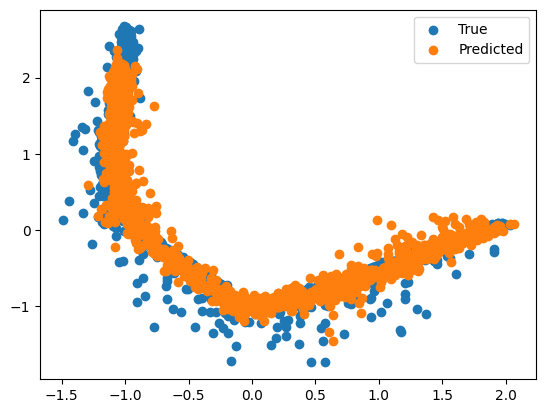

In [19]:
plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
# pred = scaler.inverse_transform(pred)
pred = model.predict(x_train)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()

10/10 [==============================] - 0s 1ms/step


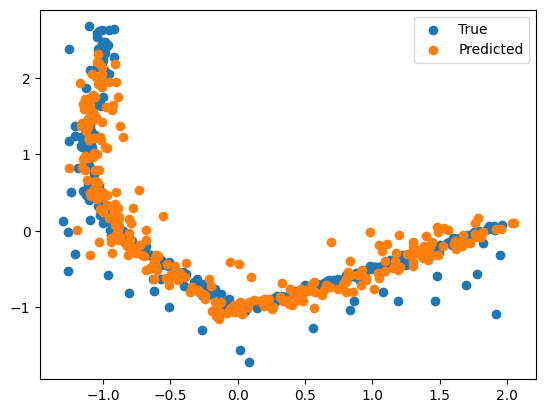

In [20]:
plt.scatter(y_test[:, 0], y_test[:, 1], label="True")
pred = model.predict(x_test)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()